In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 239318 images
Dataset type val label type: species


Loaded 59836 images
Dataset type test label type: species


Loaded 159606 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 glggzinb


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-glggzinb:best, 58.50MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                             | 0/1870 [00:00<?, ?it/s]

  0%|                                                                                                     | 1/1870 [00:00<23:07,  1.35it/s]

  0%|                                                                                                     | 2/1870 [00:00<13:34,  2.29it/s]

  0%|▏                                                                                                    | 3/1870 [00:01<10:29,  2.96it/s]

  0%|▏                                                                                                    | 4/1870 [00:01<09:02,  3.44it/s]

  0%|▎                                                                                                    | 5/1870 [00:01<08:14,  3.77it/s]

  0%|▎                                                                                                    | 6/1870 [00:01<07:45,  4.00it/s]

  0%|▍                                                                                                    | 7/1870 [00:02<07:27,  4.16it/s]

  0%|▍                                                                                                    | 8/1870 [00:02<07:15,  4.28it/s]

  0%|▍                                                                                                    | 9/1870 [00:02<07:06,  4.36it/s]

  1%|▌                                                                                                   | 10/1870 [00:02<07:01,  4.42it/s]

  1%|▌                                                                                                   | 11/1870 [00:02<06:57,  4.45it/s]

  1%|▋                                                                                                   | 12/1870 [00:03<06:54,  4.48it/s]

  1%|▋                                                                                                   | 13/1870 [00:03<06:52,  4.50it/s]

  1%|▋                                                                                                   | 14/1870 [00:03<06:51,  4.51it/s]

  1%|▊                                                                                                   | 15/1870 [00:03<06:49,  4.52it/s]

  1%|▊                                                                                                   | 16/1870 [00:04<06:49,  4.53it/s]

  1%|▉                                                                                                   | 17/1870 [00:04<06:48,  4.54it/s]

  1%|▉                                                                                                   | 18/1870 [00:04<06:48,  4.54it/s]

  1%|█                                                                                                   | 19/1870 [00:04<06:47,  4.54it/s]

  1%|█                                                                                                   | 20/1870 [00:04<06:47,  4.54it/s]

  1%|█                                                                                                   | 21/1870 [00:05<06:46,  4.54it/s]

  1%|█▏                                                                                                  | 22/1870 [00:05<06:46,  4.55it/s]

  1%|█▏                                                                                                  | 23/1870 [00:05<06:46,  4.55it/s]

  1%|█▎                                                                                                  | 24/1870 [00:05<06:45,  4.55it/s]

  1%|█▎                                                                                                  | 25/1870 [00:06<06:45,  4.55it/s]

  1%|█▍                                                                                                  | 26/1870 [00:06<06:45,  4.55it/s]

  1%|█▍                                                                                                  | 27/1870 [00:06<06:45,  4.55it/s]

  1%|█▍                                                                                                  | 28/1870 [00:06<06:45,  4.54it/s]

  2%|█▌                                                                                                  | 29/1870 [00:06<06:45,  4.54it/s]

  2%|█▌                                                                                                  | 30/1870 [00:07<06:45,  4.54it/s]

  2%|█▋                                                                                                  | 31/1870 [00:07<06:44,  4.54it/s]

  2%|█▋                                                                                                  | 32/1870 [00:07<06:44,  4.54it/s]

  2%|█▊                                                                                                  | 33/1870 [00:07<06:44,  4.54it/s]

  2%|█▊                                                                                                  | 34/1870 [00:08<06:43,  4.55it/s]

  2%|█▊                                                                                                  | 35/1870 [00:08<06:43,  4.54it/s]

  2%|█▉                                                                                                  | 36/1870 [00:08<06:43,  4.55it/s]

  2%|█▉                                                                                                  | 37/1870 [00:08<06:43,  4.55it/s]

  2%|██                                                                                                  | 38/1870 [00:08<06:42,  4.55it/s]

  2%|██                                                                                                  | 39/1870 [00:09<06:42,  4.55it/s]

  2%|██▏                                                                                                 | 40/1870 [00:09<06:42,  4.55it/s]

  2%|██▏                                                                                                 | 41/1870 [00:09<06:42,  4.55it/s]

  2%|██▏                                                                                                 | 42/1870 [00:09<06:42,  4.55it/s]

  2%|██▎                                                                                                 | 43/1870 [00:09<06:41,  4.55it/s]

  2%|██▎                                                                                                 | 44/1870 [00:10<06:41,  4.55it/s]

  2%|██▍                                                                                                 | 45/1870 [00:10<06:41,  4.55it/s]

  2%|██▍                                                                                                 | 46/1870 [00:10<06:41,  4.55it/s]

  3%|██▌                                                                                                 | 47/1870 [00:10<06:40,  4.55it/s]

  3%|██▌                                                                                                 | 48/1870 [00:11<06:40,  4.55it/s]

  3%|██▌                                                                                                 | 49/1870 [00:11<06:40,  4.54it/s]

  3%|██▋                                                                                                 | 50/1870 [00:11<06:40,  4.54it/s]

  3%|██▋                                                                                                 | 51/1870 [00:11<06:40,  4.54it/s]

  3%|██▊                                                                                                 | 52/1870 [00:11<06:39,  4.55it/s]

  3%|██▊                                                                                                 | 53/1870 [00:12<06:39,  4.54it/s]

  3%|██▉                                                                                                 | 54/1870 [00:12<06:39,  4.54it/s]

  3%|██▉                                                                                                 | 55/1870 [00:12<06:39,  4.54it/s]

  3%|██▉                                                                                                 | 56/1870 [00:12<06:39,  4.54it/s]

  3%|███                                                                                                 | 57/1870 [00:13<06:38,  4.55it/s]

  3%|███                                                                                                 | 58/1870 [00:13<06:38,  4.55it/s]

  3%|███▏                                                                                                | 59/1870 [00:13<06:38,  4.55it/s]

  3%|███▏                                                                                                | 60/1870 [00:13<06:38,  4.54it/s]

  3%|███▎                                                                                                | 61/1870 [00:13<06:38,  4.54it/s]

  3%|███▎                                                                                                | 62/1870 [00:14<06:37,  4.55it/s]

  3%|███▎                                                                                                | 63/1870 [00:14<06:37,  4.54it/s]

  3%|███▍                                                                                                | 64/1870 [00:14<06:37,  4.54it/s]

  3%|███▍                                                                                                | 65/1870 [00:14<06:37,  4.55it/s]

  4%|███▌                                                                                                | 66/1870 [00:15<06:36,  4.55it/s]

  4%|███▌                                                                                                | 67/1870 [00:15<06:36,  4.54it/s]

  4%|███▋                                                                                                | 68/1870 [00:15<06:36,  4.55it/s]

  4%|███▋                                                                                                | 69/1870 [00:15<06:36,  4.55it/s]

  4%|███▋                                                                                                | 70/1870 [00:15<06:35,  4.55it/s]

  4%|███▊                                                                                                | 71/1870 [00:16<06:35,  4.55it/s]

  4%|███▊                                                                                                | 72/1870 [00:16<06:35,  4.55it/s]

  4%|███▉                                                                                                | 73/1870 [00:16<06:35,  4.55it/s]

  4%|███▉                                                                                                | 74/1870 [00:16<06:34,  4.55it/s]

  4%|████                                                                                                | 75/1870 [00:17<06:34,  4.55it/s]

  4%|████                                                                                                | 76/1870 [00:17<06:34,  4.55it/s]

  4%|████                                                                                                | 77/1870 [00:17<06:34,  4.54it/s]

  4%|████▏                                                                                               | 78/1870 [00:17<06:34,  4.55it/s]

  4%|████▏                                                                                               | 79/1870 [00:17<06:33,  4.55it/s]

  4%|████▎                                                                                               | 80/1870 [00:18<06:33,  4.55it/s]

  4%|████▎                                                                                               | 81/1870 [00:18<06:33,  4.54it/s]

  4%|████▍                                                                                               | 82/1870 [00:18<06:33,  4.55it/s]

  4%|████▍                                                                                               | 83/1870 [00:18<06:33,  4.55it/s]

  4%|████▍                                                                                               | 84/1870 [00:19<06:32,  4.54it/s]

  5%|████▌                                                                                               | 85/1870 [00:19<06:32,  4.55it/s]

  5%|████▌                                                                                               | 86/1870 [00:19<06:32,  4.55it/s]

  5%|████▋                                                                                               | 87/1870 [00:19<06:32,  4.55it/s]

  5%|████▋                                                                                               | 88/1870 [00:19<06:32,  4.55it/s]

  5%|████▊                                                                                               | 89/1870 [00:20<06:31,  4.55it/s]

  5%|████▊                                                                                               | 90/1870 [00:20<06:31,  4.55it/s]

  5%|████▊                                                                                               | 91/1870 [00:20<06:31,  4.54it/s]

  5%|████▉                                                                                               | 92/1870 [00:20<06:31,  4.54it/s]

  5%|████▉                                                                                               | 93/1870 [00:20<06:31,  4.54it/s]

  5%|█████                                                                                               | 94/1870 [00:21<06:30,  4.54it/s]

  5%|█████                                                                                               | 95/1870 [00:21<06:30,  4.54it/s]

  5%|█████▏                                                                                              | 96/1870 [00:21<06:30,  4.54it/s]

  5%|█████▏                                                                                              | 97/1870 [00:21<06:30,  4.54it/s]

  5%|█████▏                                                                                              | 98/1870 [00:22<06:30,  4.54it/s]

  5%|█████▎                                                                                              | 99/1870 [00:22<06:29,  4.54it/s]

  5%|█████▎                                                                                             | 100/1870 [00:22<06:29,  4.54it/s]

  5%|█████▎                                                                                             | 101/1870 [00:22<06:29,  4.55it/s]

  5%|█████▍                                                                                             | 102/1870 [00:22<06:29,  4.54it/s]

  6%|█████▍                                                                                             | 103/1870 [00:23<06:28,  4.55it/s]

  6%|█████▌                                                                                             | 104/1870 [00:23<06:28,  4.55it/s]

  6%|█████▌                                                                                             | 105/1870 [00:23<06:28,  4.54it/s]

  6%|█████▌                                                                                             | 106/1870 [00:23<06:28,  4.55it/s]

  6%|█████▋                                                                                             | 107/1870 [00:24<06:27,  4.55it/s]

  6%|█████▋                                                                                             | 108/1870 [00:24<06:27,  4.55it/s]

  6%|█████▊                                                                                             | 109/1870 [00:24<06:27,  4.55it/s]

  6%|█████▊                                                                                             | 110/1870 [00:24<06:27,  4.55it/s]

  6%|█████▉                                                                                             | 111/1870 [00:24<06:26,  4.55it/s]

  6%|█████▉                                                                                             | 112/1870 [00:25<06:26,  4.54it/s]

  6%|█████▉                                                                                             | 113/1870 [00:25<06:26,  4.55it/s]

  6%|██████                                                                                             | 114/1870 [00:25<06:26,  4.55it/s]

  6%|██████                                                                                             | 115/1870 [00:25<06:25,  4.55it/s]

  6%|██████▏                                                                                            | 116/1870 [00:26<06:25,  4.55it/s]

  6%|██████▏                                                                                            | 117/1870 [00:26<06:25,  4.55it/s]

  6%|██████▏                                                                                            | 118/1870 [00:26<06:25,  4.55it/s]

  6%|██████▎                                                                                            | 119/1870 [00:26<06:25,  4.55it/s]

  6%|██████▎                                                                                            | 120/1870 [00:26<06:24,  4.55it/s]

  6%|██████▍                                                                                            | 121/1870 [00:27<06:24,  4.55it/s]

  7%|██████▍                                                                                            | 122/1870 [00:27<06:24,  4.55it/s]

  7%|██████▌                                                                                            | 123/1870 [00:27<06:24,  4.55it/s]

  7%|██████▌                                                                                            | 124/1870 [00:27<06:23,  4.55it/s]

  7%|██████▌                                                                                            | 125/1870 [00:28<06:23,  4.55it/s]

  7%|██████▋                                                                                            | 126/1870 [00:28<06:23,  4.55it/s]

  7%|██████▋                                                                                            | 127/1870 [00:28<06:23,  4.55it/s]

  7%|██████▊                                                                                            | 128/1870 [00:28<06:22,  4.55it/s]

  7%|██████▊                                                                                            | 129/1870 [00:28<06:22,  4.55it/s]

  7%|██████▉                                                                                            | 130/1870 [00:29<06:22,  4.55it/s]

  7%|██████▉                                                                                            | 131/1870 [00:29<06:22,  4.55it/s]

  7%|██████▉                                                                                            | 132/1870 [00:29<06:21,  4.55it/s]

  7%|███████                                                                                            | 133/1870 [00:29<06:22,  4.55it/s]

  7%|███████                                                                                            | 134/1870 [00:29<06:21,  4.55it/s]

  7%|███████▏                                                                                           | 135/1870 [00:30<06:21,  4.55it/s]

  7%|███████▏                                                                                           | 136/1870 [00:30<06:21,  4.55it/s]

  7%|███████▎                                                                                           | 137/1870 [00:30<06:21,  4.55it/s]

  7%|███████▎                                                                                           | 138/1870 [00:30<06:20,  4.55it/s]

  7%|███████▎                                                                                           | 139/1870 [00:31<06:20,  4.55it/s]

  7%|███████▍                                                                                           | 140/1870 [00:31<06:20,  4.55it/s]

  8%|███████▍                                                                                           | 141/1870 [00:31<06:20,  4.55it/s]

  8%|███████▌                                                                                           | 142/1870 [00:31<06:19,  4.55it/s]

  8%|███████▌                                                                                           | 143/1870 [00:31<06:19,  4.55it/s]

  8%|███████▌                                                                                           | 144/1870 [00:32<06:19,  4.55it/s]

  8%|███████▋                                                                                           | 145/1870 [00:32<06:19,  4.55it/s]

  8%|███████▋                                                                                           | 146/1870 [00:32<06:19,  4.55it/s]

  8%|███████▊                                                                                           | 147/1870 [00:32<06:19,  4.55it/s]

  8%|███████▊                                                                                           | 148/1870 [00:33<06:18,  4.55it/s]

  8%|███████▉                                                                                           | 149/1870 [00:33<06:18,  4.55it/s]

  8%|███████▉                                                                                           | 150/1870 [00:33<06:18,  4.55it/s]

  8%|███████▉                                                                                           | 151/1870 [00:33<06:18,  4.55it/s]

  8%|████████                                                                                           | 152/1870 [00:33<06:17,  4.55it/s]

  8%|████████                                                                                           | 153/1870 [00:34<06:17,  4.55it/s]

  8%|████████▏                                                                                          | 154/1870 [00:34<06:17,  4.55it/s]

  8%|████████▏                                                                                          | 155/1870 [00:34<06:17,  4.55it/s]

  8%|████████▎                                                                                          | 156/1870 [00:34<06:16,  4.55it/s]

  8%|████████▎                                                                                          | 157/1870 [00:35<06:16,  4.55it/s]

  8%|████████▎                                                                                          | 158/1870 [00:35<06:16,  4.55it/s]

  9%|████████▍                                                                                          | 159/1870 [00:35<06:16,  4.55it/s]

  9%|████████▍                                                                                          | 160/1870 [00:35<06:15,  4.55it/s]

  9%|████████▌                                                                                          | 161/1870 [00:35<06:15,  4.55it/s]

  9%|████████▌                                                                                          | 162/1870 [00:36<06:15,  4.55it/s]

  9%|████████▋                                                                                          | 163/1870 [00:36<06:15,  4.55it/s]

  9%|████████▋                                                                                          | 164/1870 [00:36<06:14,  4.55it/s]

  9%|████████▋                                                                                          | 165/1870 [00:36<06:14,  4.55it/s]

  9%|████████▊                                                                                          | 166/1870 [00:37<06:14,  4.55it/s]

  9%|████████▊                                                                                          | 167/1870 [00:37<06:14,  4.55it/s]

  9%|████████▉                                                                                          | 168/1870 [00:37<06:14,  4.55it/s]

  9%|████████▉                                                                                          | 169/1870 [00:37<06:13,  4.55it/s]

  9%|█████████                                                                                          | 170/1870 [00:37<06:13,  4.55it/s]

  9%|█████████                                                                                          | 171/1870 [00:38<06:13,  4.55it/s]

  9%|█████████                                                                                          | 172/1870 [00:38<06:13,  4.55it/s]

  9%|█████████▏                                                                                         | 173/1870 [00:38<06:13,  4.55it/s]

  9%|█████████▏                                                                                         | 174/1870 [00:38<06:11,  4.56it/s]

  9%|█████████▎                                                                                         | 175/1870 [00:39<06:10,  4.57it/s]

  9%|█████████▎                                                                                         | 176/1870 [00:39<06:10,  4.58it/s]

  9%|█████████▎                                                                                         | 177/1870 [00:39<06:09,  4.58it/s]

 10%|█████████▍                                                                                         | 178/1870 [00:39<06:08,  4.59it/s]

 10%|█████████▍                                                                                         | 179/1870 [00:39<06:08,  4.59it/s]

 10%|█████████▌                                                                                         | 180/1870 [00:40<06:08,  4.59it/s]

 10%|█████████▌                                                                                         | 181/1870 [00:40<06:07,  4.59it/s]

 10%|█████████▋                                                                                         | 182/1870 [00:40<06:07,  4.59it/s]

 10%|█████████▋                                                                                         | 183/1870 [00:40<06:07,  4.59it/s]

 10%|█████████▋                                                                                         | 184/1870 [00:40<06:07,  4.59it/s]

 10%|█████████▊                                                                                         | 185/1870 [00:41<06:07,  4.59it/s]

 10%|█████████▊                                                                                         | 186/1870 [00:41<06:06,  4.59it/s]

 10%|█████████▉                                                                                         | 187/1870 [00:41<06:06,  4.59it/s]

 10%|█████████▉                                                                                         | 188/1870 [00:41<06:06,  4.59it/s]

 10%|██████████                                                                                         | 189/1870 [00:42<06:06,  4.59it/s]

 10%|██████████                                                                                         | 190/1870 [00:42<06:05,  4.59it/s]

 10%|██████████                                                                                         | 191/1870 [00:42<06:05,  4.59it/s]

 10%|██████████▏                                                                                        | 192/1870 [00:42<06:05,  4.59it/s]

 10%|██████████▏                                                                                        | 193/1870 [00:42<06:05,  4.59it/s]

 10%|██████████▎                                                                                        | 194/1870 [00:43<06:04,  4.59it/s]

 10%|██████████▎                                                                                        | 195/1870 [00:43<06:04,  4.59it/s]

 10%|██████████▍                                                                                        | 196/1870 [00:43<06:04,  4.59it/s]

 11%|██████████▍                                                                                        | 197/1870 [00:43<06:04,  4.59it/s]

 11%|██████████▍                                                                                        | 198/1870 [00:44<06:04,  4.59it/s]

 11%|██████████▌                                                                                        | 199/1870 [00:44<06:03,  4.59it/s]

 11%|██████████▌                                                                                        | 200/1870 [00:44<06:03,  4.59it/s]

 11%|██████████▋                                                                                        | 201/1870 [00:44<06:03,  4.59it/s]

 11%|██████████▋                                                                                        | 202/1870 [00:44<06:03,  4.59it/s]

 11%|██████████▋                                                                                        | 203/1870 [00:45<06:03,  4.59it/s]

 11%|██████████▊                                                                                        | 204/1870 [00:45<06:02,  4.59it/s]

 11%|██████████▊                                                                                        | 205/1870 [00:45<06:02,  4.59it/s]

 11%|██████████▉                                                                                        | 206/1870 [00:45<06:02,  4.59it/s]

 11%|██████████▉                                                                                        | 207/1870 [00:45<06:02,  4.59it/s]

 11%|███████████                                                                                        | 208/1870 [00:46<06:01,  4.59it/s]

 11%|███████████                                                                                        | 209/1870 [00:46<06:01,  4.59it/s]

 11%|███████████                                                                                        | 210/1870 [00:46<06:01,  4.59it/s]

 11%|███████████▏                                                                                       | 211/1870 [00:46<06:01,  4.59it/s]

 11%|███████████▏                                                                                       | 212/1870 [00:47<06:00,  4.59it/s]

 11%|███████████▎                                                                                       | 213/1870 [00:47<06:00,  4.59it/s]

 11%|███████████▎                                                                                       | 214/1870 [00:47<06:00,  4.59it/s]

 11%|███████████▍                                                                                       | 215/1870 [00:47<06:00,  4.59it/s]

 12%|███████████▍                                                                                       | 216/1870 [00:47<06:00,  4.59it/s]

 12%|███████████▍                                                                                       | 217/1870 [00:48<06:00,  4.59it/s]

 12%|███████████▌                                                                                       | 218/1870 [00:48<05:59,  4.59it/s]

 12%|███████████▌                                                                                       | 219/1870 [00:48<05:59,  4.59it/s]

 12%|███████████▋                                                                                       | 220/1870 [00:48<05:59,  4.59it/s]

 12%|███████████▋                                                                                       | 221/1870 [00:49<05:59,  4.59it/s]

 12%|███████████▊                                                                                       | 222/1870 [00:49<05:59,  4.59it/s]

 12%|███████████▊                                                                                       | 223/1870 [00:49<05:58,  4.59it/s]

 12%|███████████▊                                                                                       | 224/1870 [00:49<05:58,  4.59it/s]

 12%|███████████▉                                                                                       | 225/1870 [00:49<05:58,  4.59it/s]

 12%|███████████▉                                                                                       | 226/1870 [00:50<05:57,  4.59it/s]

 12%|████████████                                                                                       | 227/1870 [00:50<05:57,  4.59it/s]

 12%|████████████                                                                                       | 228/1870 [00:50<05:57,  4.59it/s]

 12%|████████████                                                                                       | 229/1870 [00:50<05:57,  4.59it/s]

 12%|████████████▏                                                                                      | 230/1870 [00:50<05:56,  4.59it/s]

 12%|████████████▏                                                                                      | 231/1870 [00:51<05:56,  4.59it/s]

 12%|████████████▎                                                                                      | 232/1870 [00:51<05:56,  4.59it/s]

 12%|████████████▎                                                                                      | 233/1870 [00:51<05:56,  4.59it/s]

 13%|████████████▍                                                                                      | 234/1870 [00:51<05:56,  4.59it/s]

 13%|████████████▍                                                                                      | 235/1870 [00:52<05:55,  4.59it/s]

 13%|████████████▍                                                                                      | 236/1870 [00:52<05:55,  4.59it/s]

 13%|████████████▌                                                                                      | 237/1870 [00:52<05:55,  4.60it/s]

 13%|████████████▌                                                                                      | 238/1870 [00:52<05:55,  4.59it/s]

 13%|████████████▋                                                                                      | 239/1870 [00:52<05:55,  4.59it/s]

 13%|████████████▋                                                                                      | 240/1870 [00:53<05:54,  4.59it/s]

 13%|████████████▊                                                                                      | 241/1870 [00:53<05:54,  4.60it/s]

 13%|████████████▊                                                                                      | 242/1870 [00:53<05:54,  4.59it/s]

 13%|████████████▊                                                                                      | 243/1870 [00:53<05:54,  4.59it/s]

 13%|████████████▉                                                                                      | 244/1870 [00:54<05:53,  4.60it/s]

 13%|████████████▉                                                                                      | 245/1870 [00:54<05:53,  4.59it/s]

 13%|█████████████                                                                                      | 246/1870 [00:54<05:53,  4.59it/s]

 13%|█████████████                                                                                      | 247/1870 [00:54<05:53,  4.59it/s]

 13%|█████████████▏                                                                                     | 248/1870 [00:54<05:52,  4.60it/s]

 13%|█████████████▏                                                                                     | 249/1870 [00:55<05:52,  4.59it/s]

 13%|█████████████▏                                                                                     | 250/1870 [00:55<05:52,  4.59it/s]

 13%|█████████████▎                                                                                     | 251/1870 [00:55<05:52,  4.59it/s]

 13%|█████████████▎                                                                                     | 252/1870 [00:55<05:52,  4.59it/s]

 14%|█████████████▍                                                                                     | 253/1870 [00:55<05:52,  4.59it/s]

 14%|█████████████▍                                                                                     | 254/1870 [00:56<05:51,  4.59it/s]

 14%|█████████████▍                                                                                     | 255/1870 [00:56<05:51,  4.59it/s]

 14%|█████████████▌                                                                                     | 256/1870 [00:56<05:51,  4.59it/s]

 14%|█████████████▌                                                                                     | 257/1870 [00:56<05:51,  4.59it/s]

 14%|█████████████▋                                                                                     | 258/1870 [00:57<05:50,  4.59it/s]

 14%|█████████████▋                                                                                     | 259/1870 [00:57<05:50,  4.59it/s]

 14%|█████████████▊                                                                                     | 260/1870 [00:57<05:50,  4.59it/s]

 14%|█████████████▊                                                                                     | 261/1870 [00:57<05:50,  4.59it/s]

 14%|█████████████▊                                                                                     | 262/1870 [00:57<05:50,  4.59it/s]

 14%|█████████████▉                                                                                     | 263/1870 [00:58<05:49,  4.59it/s]

 14%|█████████████▉                                                                                     | 264/1870 [00:58<05:49,  4.59it/s]

 14%|██████████████                                                                                     | 265/1870 [00:58<05:49,  4.60it/s]

 14%|██████████████                                                                                     | 266/1870 [00:58<05:49,  4.59it/s]

 14%|██████████████▏                                                                                    | 267/1870 [00:59<05:48,  4.59it/s]

 14%|██████████████▏                                                                                    | 268/1870 [00:59<05:48,  4.59it/s]

 14%|██████████████▏                                                                                    | 269/1870 [00:59<05:48,  4.59it/s]

 14%|██████████████▎                                                                                    | 270/1870 [00:59<05:48,  4.59it/s]

 14%|██████████████▎                                                                                    | 271/1870 [00:59<05:48,  4.59it/s]

 15%|██████████████▍                                                                                    | 272/1870 [01:00<05:47,  4.59it/s]

 15%|██████████████▍                                                                                    | 273/1870 [01:00<05:47,  4.59it/s]

 15%|██████████████▌                                                                                    | 274/1870 [01:00<05:47,  4.59it/s]

 15%|██████████████▌                                                                                    | 275/1870 [01:00<05:47,  4.59it/s]

 15%|██████████████▌                                                                                    | 276/1870 [01:00<05:47,  4.59it/s]

 15%|██████████████▋                                                                                    | 277/1870 [01:01<05:46,  4.59it/s]

 15%|██████████████▋                                                                                    | 278/1870 [01:01<05:46,  4.59it/s]

 15%|██████████████▊                                                                                    | 279/1870 [01:01<05:46,  4.59it/s]

 15%|██████████████▊                                                                                    | 280/1870 [01:01<05:46,  4.59it/s]

 15%|██████████████▉                                                                                    | 281/1870 [01:02<05:46,  4.59it/s]

 15%|██████████████▉                                                                                    | 282/1870 [01:02<05:45,  4.59it/s]

 15%|██████████████▉                                                                                    | 283/1870 [01:02<05:45,  4.59it/s]

 15%|███████████████                                                                                    | 284/1870 [01:02<05:45,  4.59it/s]

 15%|███████████████                                                                                    | 285/1870 [01:02<05:45,  4.59it/s]

 15%|███████████████▏                                                                                   | 286/1870 [01:03<05:44,  4.59it/s]

 15%|███████████████▏                                                                                   | 287/1870 [01:03<05:44,  4.59it/s]

 15%|███████████████▏                                                                                   | 288/1870 [01:03<05:44,  4.59it/s]

 15%|███████████████▎                                                                                   | 289/1870 [01:03<05:44,  4.59it/s]

 16%|███████████████▎                                                                                   | 290/1870 [01:04<05:43,  4.59it/s]

 16%|███████████████▍                                                                                   | 291/1870 [01:04<05:43,  4.59it/s]

 16%|███████████████▍                                                                                   | 292/1870 [01:04<05:43,  4.60it/s]

 16%|███████████████▌                                                                                   | 293/1870 [01:04<05:43,  4.59it/s]

 16%|███████████████▌                                                                                   | 294/1870 [01:04<05:42,  4.60it/s]

 16%|███████████████▌                                                                                   | 295/1870 [01:05<05:42,  4.60it/s]

 16%|███████████████▋                                                                                   | 296/1870 [01:05<05:42,  4.59it/s]

 16%|███████████████▋                                                                                   | 297/1870 [01:05<05:42,  4.59it/s]

 16%|███████████████▊                                                                                   | 298/1870 [01:05<05:42,  4.60it/s]

 16%|███████████████▊                                                                                   | 299/1870 [01:06<05:41,  4.60it/s]

 16%|███████████████▉                                                                                   | 300/1870 [01:06<05:41,  4.59it/s]

 16%|███████████████▉                                                                                   | 301/1870 [01:06<05:41,  4.59it/s]

 16%|███████████████▉                                                                                   | 302/1870 [01:06<05:41,  4.60it/s]

 16%|████████████████                                                                                   | 303/1870 [01:06<05:41,  4.59it/s]

 16%|████████████████                                                                                   | 304/1870 [01:07<05:40,  4.59it/s]

 16%|████████████████▏                                                                                  | 305/1870 [01:07<05:40,  4.59it/s]

 16%|████████████████▏                                                                                  | 306/1870 [01:07<05:40,  4.60it/s]

 16%|████████████████▎                                                                                  | 307/1870 [01:07<05:40,  4.59it/s]

 16%|████████████████▎                                                                                  | 308/1870 [01:07<05:40,  4.59it/s]

 17%|████████████████▎                                                                                  | 309/1870 [01:08<05:39,  4.59it/s]

 17%|████████████████▍                                                                                  | 310/1870 [01:08<05:39,  4.59it/s]

 17%|████████████████▍                                                                                  | 311/1870 [01:08<05:39,  4.59it/s]

 17%|████████████████▌                                                                                  | 312/1870 [01:08<05:39,  4.59it/s]

 17%|████████████████▌                                                                                  | 313/1870 [01:09<05:38,  4.59it/s]

 17%|████████████████▌                                                                                  | 314/1870 [01:09<05:38,  4.59it/s]

 17%|████████████████▋                                                                                  | 315/1870 [01:09<05:38,  4.59it/s]

 17%|████████████████▋                                                                                  | 316/1870 [01:09<05:38,  4.59it/s]

 17%|████████████████▊                                                                                  | 317/1870 [01:09<05:38,  4.59it/s]

 17%|████████████████▊                                                                                  | 318/1870 [01:10<05:37,  4.59it/s]

 17%|████████████████▉                                                                                  | 319/1870 [01:10<05:37,  4.59it/s]

 17%|████████████████▉                                                                                  | 320/1870 [01:10<05:37,  4.59it/s]

 17%|████████████████▉                                                                                  | 321/1870 [01:10<05:37,  4.59it/s]

 17%|█████████████████                                                                                  | 322/1870 [01:11<05:36,  4.60it/s]

 17%|█████████████████                                                                                  | 323/1870 [01:11<05:36,  4.60it/s]

 17%|█████████████████▏                                                                                 | 324/1870 [01:11<05:36,  4.59it/s]

 17%|█████████████████▏                                                                                 | 325/1870 [01:11<05:36,  4.59it/s]

 17%|█████████████████▎                                                                                 | 326/1870 [01:11<05:35,  4.60it/s]

 17%|█████████████████▎                                                                                 | 327/1870 [01:12<05:35,  4.59it/s]

 18%|█████████████████▎                                                                                 | 328/1870 [01:12<05:35,  4.59it/s]

 18%|█████████████████▍                                                                                 | 329/1870 [01:12<05:35,  4.60it/s]

 18%|█████████████████▍                                                                                 | 330/1870 [01:12<05:35,  4.60it/s]

 18%|█████████████████▌                                                                                 | 331/1870 [01:12<05:34,  4.59it/s]

 18%|█████████████████▌                                                                                 | 332/1870 [01:13<05:34,  4.59it/s]

 18%|█████████████████▋                                                                                 | 333/1870 [01:13<05:34,  4.60it/s]

 18%|█████████████████▋                                                                                 | 334/1870 [01:13<05:34,  4.59it/s]

 18%|█████████████████▋                                                                                 | 335/1870 [01:13<05:34,  4.60it/s]

 18%|█████████████████▊                                                                                 | 336/1870 [01:14<05:33,  4.60it/s]

 18%|█████████████████▊                                                                                 | 337/1870 [01:14<05:33,  4.60it/s]

 18%|█████████████████▉                                                                                 | 338/1870 [01:14<05:33,  4.59it/s]

 18%|█████████████████▉                                                                                 | 339/1870 [01:14<05:33,  4.59it/s]

 18%|██████████████████                                                                                 | 340/1870 [01:14<05:32,  4.60it/s]

 18%|██████████████████                                                                                 | 341/1870 [01:15<05:32,  4.59it/s]

 18%|██████████████████                                                                                 | 342/1870 [01:15<05:32,  4.59it/s]

 18%|██████████████████▏                                                                                | 343/1870 [01:15<05:32,  4.59it/s]

 18%|██████████████████▏                                                                                | 344/1870 [01:15<05:32,  4.59it/s]

 18%|██████████████████▎                                                                                | 345/1870 [01:16<05:31,  4.59it/s]

 19%|██████████████████▎                                                                                | 346/1870 [01:16<05:31,  4.60it/s]

 19%|██████████████████▎                                                                                | 347/1870 [01:16<05:31,  4.60it/s]

 19%|██████████████████▍                                                                                | 348/1870 [01:16<05:31,  4.59it/s]

 19%|██████████████████▍                                                                                | 349/1870 [01:16<05:31,  4.59it/s]

 19%|██████████████████▌                                                                                | 350/1870 [01:17<05:30,  4.60it/s]

 19%|██████████████████▌                                                                                | 351/1870 [01:17<05:30,  4.60it/s]

 19%|██████████████████▋                                                                                | 352/1870 [01:17<05:30,  4.59it/s]

 19%|██████████████████▋                                                                                | 353/1870 [01:17<05:30,  4.60it/s]

 19%|██████████████████▋                                                                                | 354/1870 [01:17<05:29,  4.60it/s]

 19%|██████████████████▊                                                                                | 355/1870 [01:18<05:29,  4.59it/s]

 19%|██████████████████▊                                                                                | 356/1870 [01:18<05:29,  4.59it/s]

 19%|██████████████████▉                                                                                | 357/1870 [01:18<05:29,  4.59it/s]

 19%|██████████████████▉                                                                                | 358/1870 [01:18<05:29,  4.59it/s]

 19%|███████████████████                                                                                | 359/1870 [01:19<05:29,  4.59it/s]

 19%|███████████████████                                                                                | 360/1870 [01:19<05:28,  4.59it/s]

 19%|███████████████████                                                                                | 361/1870 [01:19<05:28,  4.59it/s]

 19%|███████████████████▏                                                                               | 362/1870 [01:19<05:28,  4.59it/s]

 19%|███████████████████▏                                                                               | 363/1870 [01:19<05:27,  4.59it/s]

 19%|███████████████████▎                                                                               | 364/1870 [01:20<05:27,  4.59it/s]

 20%|███████████████████▎                                                                               | 365/1870 [01:20<05:27,  4.59it/s]

 20%|███████████████████▍                                                                               | 366/1870 [01:20<05:27,  4.59it/s]

 20%|███████████████████▍                                                                               | 367/1870 [01:20<05:27,  4.59it/s]

 20%|███████████████████▍                                                                               | 368/1870 [01:21<05:27,  4.59it/s]

 20%|███████████████████▌                                                                               | 369/1870 [01:21<05:26,  4.59it/s]

 20%|███████████████████▌                                                                               | 370/1870 [01:21<05:26,  4.59it/s]

 20%|███████████████████▋                                                                               | 371/1870 [01:21<05:26,  4.60it/s]

 20%|███████████████████▋                                                                               | 372/1870 [01:21<05:26,  4.59it/s]

 20%|███████████████████▋                                                                               | 373/1870 [01:22<05:25,  4.59it/s]

 20%|███████████████████▊                                                                               | 374/1870 [01:22<05:25,  4.59it/s]

 20%|███████████████████▊                                                                               | 375/1870 [01:22<05:25,  4.59it/s]

 20%|███████████████████▉                                                                               | 376/1870 [01:22<05:25,  4.59it/s]

 20%|███████████████████▉                                                                               | 377/1870 [01:22<05:24,  4.60it/s]

 20%|████████████████████                                                                               | 378/1870 [01:23<05:24,  4.60it/s]

 20%|████████████████████                                                                               | 379/1870 [01:23<05:24,  4.59it/s]

 20%|████████████████████                                                                               | 380/1870 [01:23<05:24,  4.59it/s]

 20%|████████████████████▏                                                                              | 381/1870 [01:23<05:24,  4.60it/s]

 20%|████████████████████▏                                                                              | 382/1870 [01:24<05:23,  4.59it/s]

 20%|████████████████████▎                                                                              | 383/1870 [01:24<05:23,  4.59it/s]

 21%|████████████████████▎                                                                              | 384/1870 [01:24<05:23,  4.60it/s]

 21%|████████████████████▍                                                                              | 385/1870 [01:24<05:23,  4.60it/s]

 21%|████████████████████▍                                                                              | 386/1870 [01:24<05:23,  4.59it/s]

 21%|████████████████████▍                                                                              | 387/1870 [01:25<05:22,  4.60it/s]

 21%|████████████████████▌                                                                              | 388/1870 [01:25<05:22,  4.60it/s]

 21%|████████████████████▌                                                                              | 389/1870 [01:25<05:22,  4.59it/s]

 21%|████████████████████▋                                                                              | 390/1870 [01:25<05:22,  4.60it/s]

 21%|████████████████████▋                                                                              | 391/1870 [01:26<05:21,  4.60it/s]

 21%|████████████████████▊                                                                              | 392/1870 [01:26<05:21,  4.60it/s]

 21%|████████████████████▊                                                                              | 393/1870 [01:26<05:21,  4.59it/s]

 21%|████████████████████▊                                                                              | 394/1870 [01:26<05:21,  4.59it/s]

 21%|████████████████████▉                                                                              | 395/1870 [01:26<05:20,  4.60it/s]

 21%|████████████████████▉                                                                              | 396/1870 [01:27<05:20,  4.59it/s]

 21%|█████████████████████                                                                              | 397/1870 [01:27<05:20,  4.59it/s]

 21%|█████████████████████                                                                              | 398/1870 [01:27<05:20,  4.59it/s]

 21%|█████████████████████                                                                              | 399/1870 [01:27<05:20,  4.60it/s]

 21%|█████████████████████▏                                                                             | 400/1870 [01:27<05:20,  4.59it/s]

 21%|█████████████████████▏                                                                             | 401/1870 [01:28<05:19,  4.59it/s]

 21%|█████████████████████▎                                                                             | 402/1870 [01:28<05:19,  4.59it/s]

 22%|█████████████████████▎                                                                             | 403/1870 [01:28<05:19,  4.59it/s]

 22%|█████████████████████▍                                                                             | 404/1870 [01:28<05:19,  4.59it/s]

 22%|█████████████████████▍                                                                             | 405/1870 [01:29<05:18,  4.59it/s]

 22%|█████████████████████▍                                                                             | 406/1870 [01:29<05:18,  4.59it/s]

 22%|█████████████████████▌                                                                             | 407/1870 [01:29<05:18,  4.59it/s]

 22%|█████████████████████▌                                                                             | 408/1870 [01:29<05:18,  4.60it/s]

 22%|█████████████████████▋                                                                             | 409/1870 [01:29<05:18,  4.59it/s]

 22%|█████████████████████▋                                                                             | 410/1870 [01:30<05:17,  4.60it/s]

 22%|█████████████████████▊                                                                             | 411/1870 [01:30<05:17,  4.60it/s]

 22%|█████████████████████▊                                                                             | 412/1870 [01:30<05:17,  4.60it/s]

 22%|█████████████████████▊                                                                             | 413/1870 [01:30<05:17,  4.59it/s]

 22%|█████████████████████▉                                                                             | 414/1870 [01:31<05:16,  4.59it/s]

 22%|█████████████████████▉                                                                             | 415/1870 [01:31<05:16,  4.60it/s]

 22%|██████████████████████                                                                             | 416/1870 [01:31<05:16,  4.59it/s]

 22%|██████████████████████                                                                             | 417/1870 [01:31<05:16,  4.60it/s]

 22%|██████████████████████▏                                                                            | 418/1870 [01:31<05:15,  4.60it/s]

 22%|██████████████████████▏                                                                            | 419/1870 [01:32<05:15,  4.60it/s]

 22%|██████████████████████▏                                                                            | 420/1870 [01:32<05:15,  4.59it/s]

 23%|██████████████████████▎                                                                            | 421/1870 [01:32<05:15,  4.59it/s]

 23%|██████████████████████▎                                                                            | 422/1870 [01:32<05:15,  4.59it/s]

 23%|██████████████████████▍                                                                            | 423/1870 [01:32<05:15,  4.59it/s]

 23%|██████████████████████▍                                                                            | 424/1870 [01:33<05:14,  4.59it/s]

 23%|██████████████████████▌                                                                            | 425/1870 [01:33<05:14,  4.59it/s]

 23%|██████████████████████▌                                                                            | 426/1870 [01:33<05:14,  4.59it/s]

 23%|██████████████████████▌                                                                            | 427/1870 [01:33<05:14,  4.59it/s]

 23%|██████████████████████▋                                                                            | 428/1870 [01:34<05:13,  4.59it/s]

 23%|██████████████████████▋                                                                            | 429/1870 [01:34<05:13,  4.59it/s]

 23%|██████████████████████▊                                                                            | 430/1870 [01:34<05:13,  4.59it/s]

 23%|██████████████████████▊                                                                            | 431/1870 [01:34<05:13,  4.59it/s]

 23%|██████████████████████▊                                                                            | 432/1870 [01:34<05:13,  4.59it/s]

 23%|██████████████████████▉                                                                            | 433/1870 [01:35<05:13,  4.59it/s]

 23%|██████████████████████▉                                                                            | 434/1870 [01:35<05:12,  4.59it/s]

 23%|███████████████████████                                                                            | 435/1870 [01:35<05:12,  4.59it/s]

 23%|███████████████████████                                                                            | 436/1870 [01:35<05:12,  4.59it/s]

 23%|███████████████████████▏                                                                           | 437/1870 [01:36<05:12,  4.59it/s]

 23%|███████████████████████▏                                                                           | 438/1870 [01:36<05:11,  4.59it/s]

 23%|███████████████████████▏                                                                           | 439/1870 [01:36<05:11,  4.59it/s]

 24%|███████████████████████▎                                                                           | 440/1870 [01:36<05:11,  4.59it/s]

 24%|███████████████████████▎                                                                           | 441/1870 [01:36<05:11,  4.59it/s]

 24%|███████████████████████▍                                                                           | 442/1870 [01:37<05:11,  4.59it/s]

 24%|███████████████████████▍                                                                           | 443/1870 [01:37<05:10,  4.59it/s]

 24%|███████████████████████▌                                                                           | 444/1870 [01:37<05:10,  4.59it/s]

 24%|███████████████████████▌                                                                           | 445/1870 [01:37<05:10,  4.59it/s]

 24%|███████████████████████▌                                                                           | 446/1870 [01:38<05:09,  4.59it/s]

 24%|███████████████████████▋                                                                           | 447/1870 [01:38<05:09,  4.59it/s]

 24%|███████████████████████▋                                                                           | 448/1870 [01:38<05:09,  4.59it/s]

 24%|███████████████████████▊                                                                           | 449/1870 [01:38<05:09,  4.59it/s]

 24%|███████████████████████▊                                                                           | 450/1870 [01:38<05:09,  4.60it/s]

 24%|███████████████████████▉                                                                           | 451/1870 [01:39<05:08,  4.59it/s]

 24%|███████████████████████▉                                                                           | 452/1870 [01:39<05:08,  4.59it/s]

 24%|███████████████████████▉                                                                           | 453/1870 [01:39<05:08,  4.59it/s]

 24%|████████████████████████                                                                           | 454/1870 [01:39<05:08,  4.59it/s]

 24%|████████████████████████                                                                           | 455/1870 [01:39<05:08,  4.59it/s]

 24%|████████████████████████▏                                                                          | 456/1870 [01:40<05:07,  4.59it/s]

 24%|████████████████████████▏                                                                          | 457/1870 [01:40<05:07,  4.60it/s]

 24%|████████████████████████▏                                                                          | 458/1870 [01:40<05:07,  4.59it/s]

 25%|████████████████████████▎                                                                          | 459/1870 [01:40<05:07,  4.59it/s]

 25%|████████████████████████▎                                                                          | 460/1870 [01:41<05:06,  4.60it/s]

 25%|████████████████████████▍                                                                          | 461/1870 [01:41<05:06,  4.59it/s]

 25%|████████████████████████▍                                                                          | 462/1870 [01:41<05:06,  4.60it/s]

 25%|████████████████████████▌                                                                          | 463/1870 [01:41<05:06,  4.60it/s]

 25%|████████████████████████▌                                                                          | 464/1870 [01:41<05:05,  4.60it/s]

 25%|████████████████████████▌                                                                          | 465/1870 [01:42<05:05,  4.59it/s]

 25%|████████████████████████▋                                                                          | 466/1870 [01:42<05:05,  4.60it/s]

 25%|████████████████████████▋                                                                          | 467/1870 [01:42<05:05,  4.60it/s]

 25%|████████████████████████▊                                                                          | 468/1870 [01:42<05:05,  4.59it/s]

 25%|████████████████████████▊                                                                          | 469/1870 [01:43<05:04,  4.59it/s]

 25%|████████████████████████▉                                                                          | 470/1870 [01:43<05:04,  4.59it/s]

 25%|████████████████████████▉                                                                          | 471/1870 [01:43<05:04,  4.59it/s]

 25%|████████████████████████▉                                                                          | 472/1870 [01:43<05:04,  4.59it/s]

 25%|█████████████████████████                                                                          | 473/1870 [01:43<05:04,  4.59it/s]

 25%|█████████████████████████                                                                          | 474/1870 [01:44<05:03,  4.59it/s]

 25%|█████████████████████████▏                                                                         | 475/1870 [01:44<05:03,  4.59it/s]

 25%|█████████████████████████▏                                                                         | 476/1870 [01:44<05:03,  4.59it/s]

 26%|█████████████████████████▎                                                                         | 477/1870 [01:44<05:03,  4.59it/s]

 26%|█████████████████████████▎                                                                         | 478/1870 [01:44<05:02,  4.59it/s]

 26%|█████████████████████████▎                                                                         | 479/1870 [01:45<05:02,  4.59it/s]

 26%|█████████████████████████▍                                                                         | 480/1870 [01:45<05:02,  4.59it/s]

 26%|█████████████████████████▍                                                                         | 481/1870 [01:45<05:02,  4.60it/s]

 26%|█████████████████████████▌                                                                         | 482/1870 [01:45<05:02,  4.59it/s]

 26%|█████████████████████████▌                                                                         | 483/1870 [01:46<05:01,  4.59it/s]

 26%|█████████████████████████▌                                                                         | 484/1870 [01:46<05:01,  4.60it/s]

 26%|█████████████████████████▋                                                                         | 485/1870 [01:46<05:01,  4.60it/s]

 26%|█████████████████████████▋                                                                         | 486/1870 [01:46<05:01,  4.59it/s]

 26%|█████████████████████████▊                                                                         | 487/1870 [01:46<05:01,  4.59it/s]

 26%|█████████████████████████▊                                                                         | 488/1870 [01:47<05:00,  4.59it/s]

 26%|█████████████████████████▉                                                                         | 489/1870 [01:47<05:00,  4.59it/s]

 26%|█████████████████████████▉                                                                         | 490/1870 [01:47<05:00,  4.59it/s]

 26%|█████████████████████████▉                                                                         | 491/1870 [01:47<05:00,  4.60it/s]

 26%|██████████████████████████                                                                         | 492/1870 [01:48<04:59,  4.60it/s]

 26%|██████████████████████████                                                                         | 493/1870 [01:48<04:59,  4.59it/s]

 26%|██████████████████████████▏                                                                        | 494/1870 [01:48<04:59,  4.59it/s]

 26%|██████████████████████████▏                                                                        | 495/1870 [01:48<04:59,  4.59it/s]

 27%|██████████████████████████▎                                                                        | 496/1870 [01:48<05:00,  4.57it/s]

 27%|██████████████████████████▎                                                                        | 497/1870 [01:49<05:00,  4.57it/s]

 27%|██████████████████████████▎                                                                        | 498/1870 [01:49<05:00,  4.56it/s]

 27%|██████████████████████████▍                                                                        | 499/1870 [01:49<05:00,  4.56it/s]

 27%|██████████████████████████▍                                                                        | 500/1870 [01:49<05:00,  4.56it/s]

 27%|██████████████████████████▌                                                                        | 501/1870 [01:49<05:00,  4.56it/s]

 27%|██████████████████████████▌                                                                        | 502/1870 [01:50<05:00,  4.56it/s]

 27%|██████████████████████████▋                                                                        | 503/1870 [01:50<05:00,  4.55it/s]

 27%|██████████████████████████▋                                                                        | 504/1870 [01:50<05:00,  4.55it/s]

 27%|██████████████████████████▋                                                                        | 505/1870 [01:50<04:59,  4.55it/s]

 27%|██████████████████████████▊                                                                        | 506/1870 [01:51<04:59,  4.55it/s]

 27%|██████████████████████████▊                                                                        | 507/1870 [01:51<04:59,  4.55it/s]

 27%|██████████████████████████▉                                                                        | 508/1870 [01:51<04:59,  4.55it/s]

 27%|██████████████████████████▉                                                                        | 509/1870 [01:51<04:58,  4.55it/s]

 27%|██████████████████████████▉                                                                        | 510/1870 [01:51<04:59,  4.55it/s]

 27%|███████████████████████████                                                                        | 511/1870 [01:52<04:58,  4.55it/s]

 27%|███████████████████████████                                                                        | 512/1870 [01:52<04:58,  4.55it/s]

 27%|███████████████████████████▏                                                                       | 513/1870 [01:52<04:58,  4.55it/s]

 27%|███████████████████████████▏                                                                       | 514/1870 [01:52<04:57,  4.55it/s]

 28%|███████████████████████████▎                                                                       | 515/1870 [01:53<04:57,  4.55it/s]

 28%|███████████████████████████▎                                                                       | 516/1870 [01:53<04:57,  4.55it/s]

 28%|███████████████████████████▎                                                                       | 517/1870 [01:53<04:57,  4.55it/s]

 28%|███████████████████████████▍                                                                       | 518/1870 [01:53<04:57,  4.55it/s]

 28%|███████████████████████████▍                                                                       | 519/1870 [01:53<04:56,  4.55it/s]

 28%|███████████████████████████▌                                                                       | 520/1870 [01:54<04:56,  4.55it/s]

 28%|███████████████████████████▌                                                                       | 521/1870 [01:54<04:56,  4.55it/s]

 28%|███████████████████████████▋                                                                       | 522/1870 [01:54<04:56,  4.55it/s]

 28%|███████████████████████████▋                                                                       | 523/1870 [01:54<04:56,  4.55it/s]

 28%|███████████████████████████▋                                                                       | 524/1870 [01:55<04:55,  4.55it/s]

 28%|███████████████████████████▊                                                                       | 525/1870 [01:55<04:55,  4.55it/s]

 28%|███████████████████████████▊                                                                       | 526/1870 [01:55<04:55,  4.55it/s]

 28%|███████████████████████████▉                                                                       | 527/1870 [01:55<04:55,  4.55it/s]

 28%|███████████████████████████▉                                                                       | 528/1870 [01:55<04:54,  4.55it/s]

 28%|████████████████████████████                                                                       | 529/1870 [01:56<04:54,  4.55it/s]

 28%|████████████████████████████                                                                       | 530/1870 [01:56<04:54,  4.55it/s]

 28%|████████████████████████████                                                                       | 531/1870 [01:56<04:54,  4.55it/s]

 28%|████████████████████████████▏                                                                      | 532/1870 [01:56<04:54,  4.55it/s]

 29%|████████████████████████████▏                                                                      | 533/1870 [01:57<04:54,  4.55it/s]

 29%|████████████████████████████▎                                                                      | 534/1870 [01:57<04:53,  4.55it/s]

 29%|████████████████████████████▎                                                                      | 535/1870 [01:57<04:53,  4.55it/s]

 29%|████████████████████████████▍                                                                      | 536/1870 [01:57<04:53,  4.55it/s]

 29%|████████████████████████████▍                                                                      | 537/1870 [01:57<04:53,  4.55it/s]

 29%|████████████████████████████▍                                                                      | 538/1870 [01:58<04:52,  4.55it/s]

 29%|████████████████████████████▌                                                                      | 539/1870 [01:58<04:52,  4.55it/s]

 29%|████████████████████████████▌                                                                      | 540/1870 [01:58<04:52,  4.55it/s]

 29%|████████████████████████████▋                                                                      | 541/1870 [01:58<04:52,  4.55it/s]

 29%|████████████████████████████▋                                                                      | 542/1870 [01:59<04:51,  4.55it/s]

 29%|████████████████████████████▋                                                                      | 543/1870 [01:59<04:51,  4.55it/s]

 29%|████████████████████████████▊                                                                      | 544/1870 [01:59<04:51,  4.55it/s]

 29%|████████████████████████████▊                                                                      | 545/1870 [01:59<04:51,  4.55it/s]

 29%|████████████████████████████▉                                                                      | 546/1870 [01:59<04:50,  4.55it/s]

 29%|████████████████████████████▉                                                                      | 547/1870 [02:00<04:50,  4.55it/s]

 29%|█████████████████████████████                                                                      | 548/1870 [02:00<04:50,  4.55it/s]

 29%|█████████████████████████████                                                                      | 549/1870 [02:00<04:50,  4.55it/s]

 29%|█████████████████████████████                                                                      | 550/1870 [02:00<04:50,  4.55it/s]

 29%|█████████████████████████████▏                                                                     | 551/1870 [02:00<04:49,  4.55it/s]

 30%|█████████████████████████████▏                                                                     | 552/1870 [02:01<04:49,  4.55it/s]

 30%|█████████████████████████████▎                                                                     | 553/1870 [02:01<04:49,  4.55it/s]

 30%|█████████████████████████████▎                                                                     | 554/1870 [02:01<04:49,  4.55it/s]

 30%|█████████████████████████████▍                                                                     | 555/1870 [02:01<04:48,  4.55it/s]

 30%|█████████████████████████████▍                                                                     | 556/1870 [02:02<04:48,  4.55it/s]

 30%|█████████████████████████████▍                                                                     | 557/1870 [02:02<04:48,  4.55it/s]

 30%|█████████████████████████████▌                                                                     | 558/1870 [02:02<04:48,  4.55it/s]

 30%|█████████████████████████████▌                                                                     | 559/1870 [02:02<04:48,  4.55it/s]

 30%|█████████████████████████████▋                                                                     | 560/1870 [02:02<04:47,  4.55it/s]

 30%|█████████████████████████████▋                                                                     | 561/1870 [02:03<04:47,  4.55it/s]

 30%|█████████████████████████████▊                                                                     | 562/1870 [02:03<04:47,  4.55it/s]

 30%|█████████████████████████████▊                                                                     | 563/1870 [02:03<04:47,  4.55it/s]

 30%|█████████████████████████████▊                                                                     | 564/1870 [02:03<04:47,  4.55it/s]

 30%|█████████████████████████████▉                                                                     | 565/1870 [02:04<04:46,  4.55it/s]

 30%|█████████████████████████████▉                                                                     | 566/1870 [02:04<04:46,  4.55it/s]

 30%|██████████████████████████████                                                                     | 567/1870 [02:04<04:46,  4.55it/s]

 30%|██████████████████████████████                                                                     | 568/1870 [02:04<04:46,  4.55it/s]

 30%|██████████████████████████████                                                                     | 569/1870 [02:04<04:46,  4.55it/s]

 30%|██████████████████████████████▏                                                                    | 570/1870 [02:05<04:45,  4.55it/s]

 31%|██████████████████████████████▏                                                                    | 571/1870 [02:05<04:45,  4.55it/s]

 31%|██████████████████████████████▎                                                                    | 572/1870 [02:05<04:45,  4.55it/s]

 31%|██████████████████████████████▎                                                                    | 573/1870 [02:05<04:45,  4.55it/s]

 31%|██████████████████████████████▍                                                                    | 574/1870 [02:06<04:45,  4.54it/s]

 31%|██████████████████████████████▍                                                                    | 575/1870 [02:06<04:44,  4.55it/s]

 31%|██████████████████████████████▍                                                                    | 576/1870 [02:06<04:43,  4.56it/s]

 31%|██████████████████████████████▌                                                                    | 577/1870 [02:06<04:43,  4.57it/s]

 31%|██████████████████████████████▌                                                                    | 578/1870 [02:06<04:42,  4.57it/s]

 31%|██████████████████████████████▋                                                                    | 579/1870 [02:07<04:41,  4.58it/s]

 31%|██████████████████████████████▋                                                                    | 580/1870 [02:07<04:41,  4.58it/s]

 31%|██████████████████████████████▊                                                                    | 581/1870 [02:07<04:41,  4.58it/s]

 31%|██████████████████████████████▊                                                                    | 582/1870 [02:07<04:40,  4.59it/s]

 31%|██████████████████████████████▊                                                                    | 583/1870 [02:07<04:40,  4.59it/s]

 31%|██████████████████████████████▉                                                                    | 584/1870 [02:08<04:40,  4.59it/s]

 31%|██████████████████████████████▉                                                                    | 585/1870 [02:08<04:40,  4.59it/s]

 31%|███████████████████████████████                                                                    | 586/1870 [02:08<04:39,  4.59it/s]

 31%|███████████████████████████████                                                                    | 587/1870 [02:08<04:39,  4.59it/s]

 31%|███████████████████████████████▏                                                                   | 588/1870 [02:09<04:39,  4.59it/s]

 31%|███████████████████████████████▏                                                                   | 589/1870 [02:09<04:39,  4.59it/s]

 32%|███████████████████████████████▏                                                                   | 590/1870 [02:09<04:38,  4.59it/s]

 32%|███████████████████████████████▎                                                                   | 591/1870 [02:09<04:38,  4.59it/s]

 32%|███████████████████████████████▎                                                                   | 592/1870 [02:09<04:38,  4.59it/s]

 32%|███████████████████████████████▍                                                                   | 593/1870 [02:10<04:38,  4.59it/s]

 32%|███████████████████████████████▍                                                                   | 594/1870 [02:10<04:37,  4.59it/s]

 32%|███████████████████████████████▌                                                                   | 595/1870 [02:10<04:37,  4.59it/s]

 32%|███████████████████████████████▌                                                                   | 596/1870 [02:10<04:37,  4.59it/s]

 32%|███████████████████████████████▌                                                                   | 597/1870 [02:11<04:37,  4.59it/s]

 32%|███████████████████████████████▋                                                                   | 598/1870 [02:11<04:37,  4.59it/s]

 32%|███████████████████████████████▋                                                                   | 599/1870 [02:11<04:36,  4.59it/s]

 32%|███████████████████████████████▊                                                                   | 600/1870 [02:11<04:36,  4.59it/s]

 32%|███████████████████████████████▊                                                                   | 601/1870 [02:11<04:36,  4.59it/s]

 32%|███████████████████████████████▊                                                                   | 602/1870 [02:12<04:36,  4.59it/s]

 32%|███████████████████████████████▉                                                                   | 603/1870 [02:12<04:36,  4.59it/s]

 32%|███████████████████████████████▉                                                                   | 604/1870 [02:12<04:35,  4.59it/s]

 32%|████████████████████████████████                                                                   | 605/1870 [02:12<04:35,  4.59it/s]

 32%|████████████████████████████████                                                                   | 606/1870 [02:13<04:35,  4.59it/s]

 32%|████████████████████████████████▏                                                                  | 607/1870 [02:13<04:35,  4.59it/s]

 33%|████████████████████████████████▏                                                                  | 608/1870 [02:13<04:34,  4.59it/s]

 33%|████████████████████████████████▏                                                                  | 609/1870 [02:13<04:34,  4.59it/s]

 33%|████████████████████████████████▎                                                                  | 610/1870 [02:13<04:34,  4.59it/s]

 33%|████████████████████████████████▎                                                                  | 611/1870 [02:14<04:34,  4.59it/s]

 33%|████████████████████████████████▍                                                                  | 612/1870 [02:14<04:34,  4.59it/s]

 33%|████████████████████████████████▍                                                                  | 613/1870 [02:14<04:33,  4.59it/s]

 33%|████████████████████████████████▌                                                                  | 614/1870 [02:14<04:33,  4.59it/s]

 33%|████████████████████████████████▌                                                                  | 615/1870 [02:14<04:33,  4.59it/s]

 33%|████████████████████████████████▌                                                                  | 616/1870 [02:15<04:33,  4.59it/s]

 33%|████████████████████████████████▋                                                                  | 617/1870 [02:15<04:33,  4.59it/s]

 33%|████████████████████████████████▋                                                                  | 618/1870 [02:15<04:32,  4.59it/s]

 33%|████████████████████████████████▊                                                                  | 619/1870 [02:15<04:32,  4.59it/s]

 33%|████████████████████████████████▊                                                                  | 620/1870 [02:16<04:32,  4.59it/s]

 33%|████████████████████████████████▉                                                                  | 621/1870 [02:16<04:32,  4.59it/s]

 33%|████████████████████████████████▉                                                                  | 622/1870 [02:16<04:31,  4.59it/s]

 33%|████████████████████████████████▉                                                                  | 623/1870 [02:16<04:31,  4.59it/s]

 33%|█████████████████████████████████                                                                  | 624/1870 [02:16<04:31,  4.59it/s]

 33%|█████████████████████████████████                                                                  | 625/1870 [02:17<04:31,  4.59it/s]

 33%|█████████████████████████████████▏                                                                 | 626/1870 [02:17<04:31,  4.59it/s]

 34%|█████████████████████████████████▏                                                                 | 627/1870 [02:17<04:30,  4.59it/s]

 34%|█████████████████████████████████▏                                                                 | 628/1870 [02:17<04:30,  4.59it/s]

 34%|█████████████████████████████████▎                                                                 | 629/1870 [02:18<04:30,  4.59it/s]

 34%|█████████████████████████████████▎                                                                 | 630/1870 [02:18<04:30,  4.59it/s]

 34%|█████████████████████████████████▍                                                                 | 631/1870 [02:18<04:29,  4.59it/s]

 34%|█████████████████████████████████▍                                                                 | 632/1870 [02:18<04:29,  4.59it/s]

 34%|█████████████████████████████████▌                                                                 | 633/1870 [02:18<04:29,  4.59it/s]

 34%|█████████████████████████████████▌                                                                 | 634/1870 [02:19<04:29,  4.59it/s]

 34%|█████████████████████████████████▌                                                                 | 635/1870 [02:19<04:29,  4.59it/s]

 34%|█████████████████████████████████▋                                                                 | 636/1870 [02:19<04:28,  4.59it/s]

 34%|█████████████████████████████████▋                                                                 | 637/1870 [02:19<04:28,  4.59it/s]

 34%|█████████████████████████████████▊                                                                 | 638/1870 [02:19<04:28,  4.59it/s]

 34%|█████████████████████████████████▊                                                                 | 639/1870 [02:20<04:28,  4.59it/s]

 34%|█████████████████████████████████▉                                                                 | 640/1870 [02:20<04:27,  4.59it/s]

 34%|█████████████████████████████████▉                                                                 | 641/1870 [02:20<04:27,  4.59it/s]

 34%|█████████████████████████████████▉                                                                 | 642/1870 [02:20<04:27,  4.59it/s]

 34%|██████████████████████████████████                                                                 | 643/1870 [02:21<04:27,  4.59it/s]

 34%|██████████████████████████████████                                                                 | 644/1870 [02:21<04:27,  4.59it/s]

 34%|██████████████████████████████████▏                                                                | 645/1870 [02:21<04:27,  4.59it/s]

 35%|██████████████████████████████████▏                                                                | 646/1870 [02:21<04:27,  4.58it/s]

 35%|██████████████████████████████████▎                                                                | 647/1870 [02:21<04:26,  4.58it/s]

 35%|██████████████████████████████████▎                                                                | 648/1870 [02:22<04:26,  4.59it/s]

 35%|██████████████████████████████████▎                                                                | 649/1870 [02:22<04:26,  4.59it/s]

 35%|██████████████████████████████████▍                                                                | 650/1870 [02:22<04:25,  4.59it/s]

 35%|██████████████████████████████████▍                                                                | 651/1870 [02:22<04:25,  4.59it/s]

 35%|██████████████████████████████████▌                                                                | 652/1870 [02:23<04:25,  4.59it/s]

 35%|██████████████████████████████████▌                                                                | 653/1870 [02:23<04:25,  4.59it/s]

 35%|██████████████████████████████████▌                                                                | 654/1870 [02:23<04:24,  4.59it/s]

 35%|██████████████████████████████████▋                                                                | 655/1870 [02:23<04:24,  4.59it/s]

 35%|██████████████████████████████████▋                                                                | 656/1870 [02:23<04:24,  4.59it/s]

 35%|██████████████████████████████████▊                                                                | 657/1870 [02:24<04:24,  4.59it/s]

 35%|██████████████████████████████████▊                                                                | 658/1870 [02:24<04:24,  4.59it/s]

 35%|██████████████████████████████████▉                                                                | 659/1870 [02:24<04:23,  4.59it/s]

 35%|██████████████████████████████████▉                                                                | 660/1870 [02:24<04:23,  4.59it/s]

 35%|██████████████████████████████████▉                                                                | 661/1870 [02:24<04:23,  4.59it/s]

 35%|███████████████████████████████████                                                                | 662/1870 [02:25<04:23,  4.59it/s]

 35%|███████████████████████████████████                                                                | 663/1870 [02:25<04:22,  4.59it/s]

 36%|███████████████████████████████████▏                                                               | 664/1870 [02:25<04:22,  4.59it/s]

 36%|███████████████████████████████████▏                                                               | 665/1870 [02:25<04:22,  4.59it/s]

 36%|███████████████████████████████████▎                                                               | 666/1870 [02:26<04:22,  4.59it/s]

 36%|███████████████████████████████████▎                                                               | 667/1870 [02:26<04:22,  4.59it/s]

 36%|███████████████████████████████████▎                                                               | 668/1870 [02:26<04:21,  4.59it/s]

 36%|███████████████████████████████████▍                                                               | 669/1870 [02:26<04:21,  4.59it/s]

 36%|███████████████████████████████████▍                                                               | 670/1870 [02:26<04:21,  4.59it/s]

 36%|███████████████████████████████████▌                                                               | 671/1870 [02:27<04:21,  4.59it/s]

 36%|███████████████████████████████████▌                                                               | 672/1870 [02:27<04:20,  4.59it/s]

 36%|███████████████████████████████████▋                                                               | 673/1870 [02:27<04:20,  4.59it/s]

 36%|███████████████████████████████████▋                                                               | 674/1870 [02:27<04:20,  4.59it/s]

 36%|███████████████████████████████████▋                                                               | 675/1870 [02:28<04:20,  4.59it/s]

 36%|███████████████████████████████████▊                                                               | 676/1870 [02:28<04:20,  4.59it/s]

 36%|███████████████████████████████████▊                                                               | 677/1870 [02:28<04:19,  4.59it/s]

 36%|███████████████████████████████████▉                                                               | 678/1870 [02:28<04:19,  4.59it/s]

 36%|███████████████████████████████████▉                                                               | 679/1870 [02:28<04:19,  4.59it/s]

 36%|████████████████████████████████████                                                               | 680/1870 [02:29<04:19,  4.59it/s]

 36%|████████████████████████████████████                                                               | 681/1870 [02:29<04:18,  4.59it/s]

 36%|████████████████████████████████████                                                               | 682/1870 [02:29<04:18,  4.59it/s]

 37%|████████████████████████████████████▏                                                              | 683/1870 [02:29<04:18,  4.59it/s]

 37%|████████████████████████████████████▏                                                              | 684/1870 [02:30<04:18,  4.59it/s]

 37%|████████████████████████████████████▎                                                              | 685/1870 [02:30<04:18,  4.59it/s]

 37%|████████████████████████████████████▎                                                              | 686/1870 [02:30<04:17,  4.59it/s]

 37%|████████████████████████████████████▎                                                              | 687/1870 [02:30<04:17,  4.59it/s]

 37%|████████████████████████████████████▍                                                              | 688/1870 [02:30<04:17,  4.59it/s]

 37%|████████████████████████████████████▍                                                              | 689/1870 [02:31<04:17,  4.59it/s]

 37%|████████████████████████████████████▌                                                              | 690/1870 [02:31<04:17,  4.59it/s]

 37%|████████████████████████████████████▌                                                              | 691/1870 [02:31<04:16,  4.59it/s]

 37%|████████████████████████████████████▋                                                              | 692/1870 [02:31<04:16,  4.59it/s]

 37%|████████████████████████████████████▋                                                              | 693/1870 [02:31<04:16,  4.59it/s]

 37%|████████████████████████████████████▋                                                              | 694/1870 [02:32<04:16,  4.59it/s]

 37%|████████████████████████████████████▊                                                              | 695/1870 [02:32<04:16,  4.59it/s]

 37%|████████████████████████████████████▊                                                              | 696/1870 [02:32<04:15,  4.59it/s]

 37%|████████████████████████████████████▉                                                              | 697/1870 [02:32<04:15,  4.59it/s]

 37%|████████████████████████████████████▉                                                              | 698/1870 [02:33<04:15,  4.59it/s]

 37%|█████████████████████████████████████                                                              | 699/1870 [02:33<04:15,  4.59it/s]

 37%|█████████████████████████████████████                                                              | 700/1870 [02:33<04:14,  4.59it/s]

 37%|█████████████████████████████████████                                                              | 701/1870 [02:33<04:14,  4.59it/s]

 38%|█████████████████████████████████████▏                                                             | 702/1870 [02:33<04:14,  4.59it/s]

 38%|█████████████████████████████████████▏                                                             | 703/1870 [02:34<04:14,  4.59it/s]

 38%|█████████████████████████████████████▎                                                             | 704/1870 [02:34<04:14,  4.59it/s]

 38%|█████████████████████████████████████▎                                                             | 705/1870 [02:34<04:13,  4.59it/s]

 38%|█████████████████████████████████████▍                                                             | 706/1870 [02:34<04:13,  4.59it/s]

 38%|█████████████████████████████████████▍                                                             | 707/1870 [02:35<04:13,  4.59it/s]

 38%|█████████████████████████████████████▍                                                             | 708/1870 [02:35<04:13,  4.59it/s]

 38%|█████████████████████████████████████▌                                                             | 709/1870 [02:35<04:13,  4.59it/s]

 38%|█████████████████████████████████████▌                                                             | 710/1870 [02:35<04:12,  4.59it/s]

 38%|█████████████████████████████████████▋                                                             | 711/1870 [02:35<04:12,  4.59it/s]

 38%|█████████████████████████████████████▋                                                             | 712/1870 [02:36<04:12,  4.59it/s]

 38%|█████████████████████████████████████▋                                                             | 713/1870 [02:36<04:12,  4.59it/s]

 38%|█████████████████████████████████████▊                                                             | 714/1870 [02:36<04:11,  4.59it/s]

 38%|█████████████████████████████████████▊                                                             | 715/1870 [02:36<04:11,  4.59it/s]

 38%|█████████████████████████████████████▉                                                             | 716/1870 [02:36<04:11,  4.59it/s]

 38%|█████████████████████████████████████▉                                                             | 717/1870 [02:37<04:11,  4.59it/s]

 38%|██████████████████████████████████████                                                             | 718/1870 [02:37<04:10,  4.59it/s]

 38%|██████████████████████████████████████                                                             | 719/1870 [02:37<04:10,  4.59it/s]

 39%|██████████████████████████████████████                                                             | 720/1870 [02:37<04:10,  4.59it/s]

 39%|██████████████████████████████████████▏                                                            | 721/1870 [02:38<04:10,  4.59it/s]

 39%|██████████████████████████████████████▏                                                            | 722/1870 [02:38<04:10,  4.59it/s]

 39%|██████████████████████████████████████▎                                                            | 723/1870 [02:38<04:09,  4.59it/s]

 39%|██████████████████████████████████████▎                                                            | 724/1870 [02:38<04:09,  4.59it/s]

 39%|██████████████████████████████████████▍                                                            | 725/1870 [02:38<04:09,  4.59it/s]

 39%|██████████████████████████████████████▍                                                            | 726/1870 [02:39<04:09,  4.59it/s]

 39%|██████████████████████████████████████▍                                                            | 727/1870 [02:39<04:09,  4.58it/s]

 39%|██████████████████████████████████████▌                                                            | 728/1870 [02:39<04:09,  4.59it/s]

 39%|██████████████████████████████████████▌                                                            | 729/1870 [02:39<04:08,  4.59it/s]

 39%|██████████████████████████████████████▋                                                            | 730/1870 [02:40<04:08,  4.58it/s]

 39%|██████████████████████████████████████▋                                                            | 731/1870 [02:40<04:09,  4.57it/s]

 39%|██████████████████████████████████████▊                                                            | 732/1870 [02:40<04:09,  4.56it/s]

 39%|██████████████████████████████████████▊                                                            | 733/1870 [02:40<04:09,  4.56it/s]

 39%|██████████████████████████████████████▊                                                            | 734/1870 [02:40<04:09,  4.55it/s]

 39%|██████████████████████████████████████▉                                                            | 735/1870 [02:41<04:09,  4.55it/s]

 39%|██████████████████████████████████████▉                                                            | 736/1870 [02:41<04:09,  4.55it/s]

 39%|███████████████████████████████████████                                                            | 737/1870 [02:41<04:09,  4.55it/s]

 39%|███████████████████████████████████████                                                            | 738/1870 [02:41<04:08,  4.55it/s]

 40%|███████████████████████████████████████                                                            | 739/1870 [02:42<04:08,  4.55it/s]

 40%|███████████████████████████████████████▏                                                           | 740/1870 [02:42<04:08,  4.55it/s]

 40%|███████████████████████████████████████▏                                                           | 741/1870 [02:42<04:08,  4.55it/s]

 40%|███████████████████████████████████████▎                                                           | 742/1870 [02:42<04:08,  4.55it/s]

 40%|███████████████████████████████████████▎                                                           | 743/1870 [02:42<04:07,  4.55it/s]

 40%|███████████████████████████████████████▍                                                           | 744/1870 [02:43<04:07,  4.55it/s]

 40%|███████████████████████████████████████▍                                                           | 745/1870 [02:43<04:07,  4.55it/s]

 40%|███████████████████████████████████████▍                                                           | 746/1870 [02:43<04:07,  4.54it/s]

 40%|███████████████████████████████████████▌                                                           | 747/1870 [02:43<04:07,  4.54it/s]

 40%|███████████████████████████████████████▌                                                           | 748/1870 [02:43<04:06,  4.55it/s]

 40%|███████████████████████████████████████▋                                                           | 749/1870 [02:44<04:06,  4.55it/s]

 40%|███████████████████████████████████████▋                                                           | 750/1870 [02:44<04:06,  4.55it/s]

 40%|███████████████████████████████████████▊                                                           | 751/1870 [02:44<04:06,  4.55it/s]

 40%|███████████████████████████████████████▊                                                           | 752/1870 [02:44<04:06,  4.54it/s]

 40%|███████████████████████████████████████▊                                                           | 753/1870 [02:45<04:05,  4.54it/s]

 40%|███████████████████████████████████████▉                                                           | 754/1870 [02:45<04:05,  4.54it/s]

 40%|███████████████████████████████████████▉                                                           | 755/1870 [02:45<04:05,  4.54it/s]

 40%|████████████████████████████████████████                                                           | 756/1870 [02:45<04:05,  4.54it/s]

 40%|████████████████████████████████████████                                                           | 757/1870 [02:45<04:04,  4.54it/s]

 41%|████████████████████████████████████████▏                                                          | 758/1870 [02:46<04:04,  4.55it/s]

 41%|████████████████████████████████████████▏                                                          | 759/1870 [02:46<04:04,  4.55it/s]

 41%|████████████████████████████████████████▏                                                          | 760/1870 [02:46<04:04,  4.55it/s]

 41%|████████████████████████████████████████▎                                                          | 761/1870 [02:46<04:03,  4.55it/s]

 41%|████████████████████████████████████████▎                                                          | 762/1870 [02:47<04:03,  4.55it/s]

 41%|████████████████████████████████████████▍                                                          | 763/1870 [02:47<04:03,  4.55it/s]

 41%|████████████████████████████████████████▍                                                          | 764/1870 [02:47<04:03,  4.54it/s]

 41%|████████████████████████████████████████▌                                                          | 765/1870 [02:47<04:03,  4.55it/s]

 41%|████████████████████████████████████████▌                                                          | 766/1870 [02:47<04:02,  4.55it/s]

 41%|████████████████████████████████████████▌                                                          | 767/1870 [02:48<04:02,  4.55it/s]

 41%|████████████████████████████████████████▋                                                          | 768/1870 [02:48<04:02,  4.55it/s]

 41%|████████████████████████████████████████▋                                                          | 769/1870 [02:48<04:02,  4.54it/s]

 41%|████████████████████████████████████████▊                                                          | 770/1870 [02:48<04:02,  4.54it/s]

 41%|████████████████████████████████████████▊                                                          | 771/1870 [02:49<04:02,  4.54it/s]

 41%|████████████████████████████████████████▊                                                          | 772/1870 [02:49<04:02,  4.54it/s]

 41%|████████████████████████████████████████▉                                                          | 773/1870 [02:49<04:01,  4.54it/s]

 41%|████████████████████████████████████████▉                                                          | 774/1870 [02:49<04:01,  4.54it/s]

 41%|█████████████████████████████████████████                                                          | 775/1870 [02:49<04:01,  4.54it/s]

 41%|█████████████████████████████████████████                                                          | 776/1870 [02:50<04:00,  4.54it/s]

 42%|█████████████████████████████████████████▏                                                         | 777/1870 [02:50<04:00,  4.54it/s]

 42%|█████████████████████████████████████████▏                                                         | 778/1870 [02:50<04:00,  4.54it/s]

 42%|█████████████████████████████████████████▏                                                         | 779/1870 [02:50<04:00,  4.54it/s]

 42%|█████████████████████████████████████████▎                                                         | 780/1870 [02:51<03:59,  4.54it/s]

 42%|█████████████████████████████████████████▎                                                         | 781/1870 [02:51<03:59,  4.54it/s]

 42%|█████████████████████████████████████████▍                                                         | 782/1870 [02:51<03:59,  4.54it/s]

 42%|█████████████████████████████████████████▍                                                         | 783/1870 [02:51<03:59,  4.54it/s]

 42%|█████████████████████████████████████████▌                                                         | 784/1870 [02:51<03:58,  4.54it/s]

 42%|█████████████████████████████████████████▌                                                         | 785/1870 [02:52<03:58,  4.55it/s]

 42%|█████████████████████████████████████████▌                                                         | 786/1870 [02:52<03:58,  4.55it/s]

 42%|█████████████████████████████████████████▋                                                         | 787/1870 [02:52<03:58,  4.55it/s]

 42%|█████████████████████████████████████████▋                                                         | 788/1870 [02:52<03:58,  4.55it/s]

 42%|█████████████████████████████████████████▊                                                         | 789/1870 [02:53<03:57,  4.55it/s]

 42%|█████████████████████████████████████████▊                                                         | 790/1870 [02:53<03:57,  4.55it/s]

 42%|█████████████████████████████████████████▉                                                         | 791/1870 [02:53<03:57,  4.55it/s]

 42%|█████████████████████████████████████████▉                                                         | 792/1870 [02:53<03:57,  4.55it/s]

 42%|█████████████████████████████████████████▉                                                         | 793/1870 [02:53<03:56,  4.55it/s]

 42%|██████████████████████████████████████████                                                         | 794/1870 [02:54<03:56,  4.55it/s]

 43%|██████████████████████████████████████████                                                         | 795/1870 [02:54<03:56,  4.55it/s]

 43%|██████████████████████████████████████████▏                                                        | 796/1870 [02:54<03:56,  4.55it/s]

 43%|██████████████████████████████████████████▏                                                        | 797/1870 [02:54<03:56,  4.55it/s]

 43%|██████████████████████████████████████████▏                                                        | 798/1870 [02:54<03:55,  4.55it/s]

 43%|██████████████████████████████████████████▎                                                        | 799/1870 [02:55<03:55,  4.55it/s]

 43%|██████████████████████████████████████████▎                                                        | 800/1870 [02:55<03:55,  4.54it/s]

 43%|██████████████████████████████████████████▍                                                        | 801/1870 [02:55<03:55,  4.54it/s]

 43%|██████████████████████████████████████████▍                                                        | 802/1870 [02:55<03:55,  4.54it/s]

 43%|██████████████████████████████████████████▌                                                        | 803/1870 [02:56<03:54,  4.54it/s]

 43%|██████████████████████████████████████████▌                                                        | 804/1870 [02:56<03:54,  4.54it/s]

 43%|██████████████████████████████████████████▌                                                        | 805/1870 [02:56<03:54,  4.54it/s]

 43%|██████████████████████████████████████████▋                                                        | 806/1870 [02:56<03:54,  4.54it/s]

 43%|██████████████████████████████████████████▋                                                        | 807/1870 [02:56<03:54,  4.54it/s]

 43%|██████████████████████████████████████████▊                                                        | 808/1870 [02:57<03:53,  4.54it/s]

 43%|██████████████████████████████████████████▊                                                        | 809/1870 [02:57<03:53,  4.54it/s]

 43%|██████████████████████████████████████████▉                                                        | 810/1870 [02:57<03:53,  4.54it/s]

 43%|██████████████████████████████████████████▉                                                        | 811/1870 [02:57<03:53,  4.54it/s]

 43%|██████████████████████████████████████████▉                                                        | 812/1870 [02:58<03:52,  4.54it/s]

 43%|███████████████████████████████████████████                                                        | 813/1870 [02:58<03:52,  4.54it/s]

 44%|███████████████████████████████████████████                                                        | 814/1870 [02:58<03:52,  4.54it/s]

 44%|███████████████████████████████████████████▏                                                       | 815/1870 [02:58<03:52,  4.54it/s]

 44%|███████████████████████████████████████████▏                                                       | 816/1870 [02:58<03:52,  4.54it/s]

 44%|███████████████████████████████████████████▎                                                       | 817/1870 [02:59<03:51,  4.54it/s]

 44%|███████████████████████████████████████████▎                                                       | 818/1870 [02:59<03:51,  4.54it/s]

 44%|███████████████████████████████████████████▎                                                       | 819/1870 [02:59<03:51,  4.54it/s]

 44%|███████████████████████████████████████████▍                                                       | 820/1870 [02:59<03:51,  4.54it/s]

 44%|███████████████████████████████████████████▍                                                       | 821/1870 [03:00<03:51,  4.54it/s]

 44%|███████████████████████████████████████████▌                                                       | 822/1870 [03:00<03:50,  4.54it/s]

 44%|███████████████████████████████████████████▌                                                       | 823/1870 [03:00<03:50,  4.54it/s]

 44%|███████████████████████████████████████████▌                                                       | 824/1870 [03:00<03:50,  4.54it/s]

 44%|███████████████████████████████████████████▋                                                       | 825/1870 [03:00<03:50,  4.54it/s]

 44%|███████████████████████████████████████████▋                                                       | 826/1870 [03:01<03:50,  4.54it/s]

 44%|███████████████████████████████████████████▊                                                       | 827/1870 [03:01<03:49,  4.54it/s]

 44%|███████████████████████████████████████████▊                                                       | 828/1870 [03:01<03:49,  4.54it/s]

 44%|███████████████████████████████████████████▉                                                       | 829/1870 [03:01<03:49,  4.54it/s]

 44%|███████████████████████████████████████████▉                                                       | 830/1870 [03:02<03:49,  4.54it/s]

 44%|███████████████████████████████████████████▉                                                       | 831/1870 [03:02<03:48,  4.54it/s]

 44%|████████████████████████████████████████████                                                       | 832/1870 [03:02<03:48,  4.54it/s]

 45%|████████████████████████████████████████████                                                       | 833/1870 [03:02<03:48,  4.54it/s]

 45%|████████████████████████████████████████████▏                                                      | 834/1870 [03:02<03:48,  4.54it/s]

 45%|████████████████████████████████████████████▏                                                      | 835/1870 [03:03<03:47,  4.54it/s]

 45%|████████████████████████████████████████████▎                                                      | 836/1870 [03:03<03:47,  4.54it/s]

 45%|████████████████████████████████████████████▎                                                      | 837/1870 [03:03<03:47,  4.54it/s]

 45%|████████████████████████████████████████████▎                                                      | 838/1870 [03:03<03:47,  4.54it/s]

 45%|████████████████████████████████████████████▍                                                      | 839/1870 [03:04<03:47,  4.54it/s]

 45%|████████████████████████████████████████████▍                                                      | 840/1870 [03:04<03:46,  4.54it/s]

 45%|████████████████████████████████████████████▌                                                      | 841/1870 [03:04<03:46,  4.54it/s]

 45%|████████████████████████████████████████████▌                                                      | 842/1870 [03:04<03:46,  4.54it/s]

 45%|████████████████████████████████████████████▋                                                      | 843/1870 [03:04<03:46,  4.54it/s]

 45%|████████████████████████████████████████████▋                                                      | 844/1870 [03:05<03:45,  4.54it/s]

 45%|████████████████████████████████████████████▋                                                      | 845/1870 [03:05<03:45,  4.54it/s]

 45%|████████████████████████████████████████████▊                                                      | 846/1870 [03:05<03:45,  4.54it/s]

 45%|████████████████████████████████████████████▊                                                      | 847/1870 [03:05<03:45,  4.54it/s]

 45%|████████████████████████████████████████████▉                                                      | 848/1870 [03:06<03:44,  4.54it/s]

 45%|████████████████████████████████████████████▉                                                      | 849/1870 [03:06<03:44,  4.55it/s]

 45%|█████████████████████████████████████████████                                                      | 850/1870 [03:06<03:44,  4.55it/s]

 46%|█████████████████████████████████████████████                                                      | 851/1870 [03:06<03:44,  4.55it/s]

 46%|█████████████████████████████████████████████                                                      | 852/1870 [03:06<03:43,  4.55it/s]

 46%|█████████████████████████████████████████████▏                                                     | 853/1870 [03:07<03:43,  4.55it/s]

 46%|█████████████████████████████████████████████▏                                                     | 854/1870 [03:07<03:43,  4.55it/s]

 46%|█████████████████████████████████████████████▎                                                     | 855/1870 [03:07<03:43,  4.55it/s]

 46%|█████████████████████████████████████████████▎                                                     | 856/1870 [03:07<03:43,  4.55it/s]

 46%|█████████████████████████████████████████████▎                                                     | 857/1870 [03:07<03:42,  4.55it/s]

 46%|█████████████████████████████████████████████▍                                                     | 858/1870 [03:08<03:42,  4.55it/s]

 46%|█████████████████████████████████████████████▍                                                     | 859/1870 [03:08<03:42,  4.55it/s]

 46%|█████████████████████████████████████████████▌                                                     | 860/1870 [03:08<03:42,  4.55it/s]

 46%|█████████████████████████████████████████████▌                                                     | 861/1870 [03:08<03:42,  4.54it/s]

 46%|█████████████████████████████████████████████▋                                                     | 862/1870 [03:09<03:41,  4.54it/s]

 46%|█████████████████████████████████████████████▋                                                     | 863/1870 [03:09<03:41,  4.54it/s]

 46%|█████████████████████████████████████████████▋                                                     | 864/1870 [03:09<03:41,  4.54it/s]

 46%|█████████████████████████████████████████████▊                                                     | 865/1870 [03:09<03:41,  4.54it/s]

 46%|█████████████████████████████████████████████▊                                                     | 866/1870 [03:09<03:40,  4.54it/s]

 46%|█████████████████████████████████████████████▉                                                     | 867/1870 [03:10<03:40,  4.54it/s]

 46%|█████████████████████████████████████████████▉                                                     | 868/1870 [03:10<03:40,  4.54it/s]

 46%|██████████████████████████████████████████████                                                     | 869/1870 [03:10<03:40,  4.54it/s]

 47%|██████████████████████████████████████████████                                                     | 870/1870 [03:10<03:40,  4.54it/s]

 47%|██████████████████████████████████████████████                                                     | 871/1870 [03:11<03:39,  4.54it/s]

 47%|██████████████████████████████████████████████▏                                                    | 872/1870 [03:11<03:39,  4.54it/s]

 47%|██████████████████████████████████████████████▏                                                    | 873/1870 [03:11<03:39,  4.54it/s]

 47%|██████████████████████████████████████████████▎                                                    | 874/1870 [03:11<03:39,  4.54it/s]

 47%|██████████████████████████████████████████████▎                                                    | 875/1870 [03:11<03:38,  4.54it/s]

 47%|██████████████████████████████████████████████▍                                                    | 876/1870 [03:12<03:38,  4.54it/s]

 47%|██████████████████████████████████████████████▍                                                    | 877/1870 [03:12<03:38,  4.54it/s]

 47%|██████████████████████████████████████████████▍                                                    | 878/1870 [03:12<03:38,  4.54it/s]

 47%|██████████████████████████████████████████████▌                                                    | 879/1870 [03:12<03:38,  4.55it/s]

 47%|██████████████████████████████████████████████▌                                                    | 880/1870 [03:13<03:37,  4.54it/s]

 47%|██████████████████████████████████████████████▋                                                    | 881/1870 [03:13<03:37,  4.55it/s]

 47%|██████████████████████████████████████████████▋                                                    | 882/1870 [03:13<03:37,  4.55it/s]

 47%|██████████████████████████████████████████████▋                                                    | 883/1870 [03:13<03:37,  4.55it/s]

 47%|██████████████████████████████████████████████▊                                                    | 884/1870 [03:13<03:36,  4.55it/s]

 47%|██████████████████████████████████████████████▊                                                    | 885/1870 [03:14<03:36,  4.55it/s]

 47%|██████████████████████████████████████████████▉                                                    | 886/1870 [03:14<03:36,  4.54it/s]

 47%|██████████████████████████████████████████████▉                                                    | 887/1870 [03:14<03:36,  4.54it/s]

 47%|███████████████████████████████████████████████                                                    | 888/1870 [03:14<03:36,  4.54it/s]

 48%|███████████████████████████████████████████████                                                    | 889/1870 [03:15<03:35,  4.54it/s]

 48%|███████████████████████████████████████████████                                                    | 890/1870 [03:15<03:35,  4.54it/s]

 48%|███████████████████████████████████████████████▏                                                   | 891/1870 [03:15<03:35,  4.54it/s]

 48%|███████████████████████████████████████████████▏                                                   | 892/1870 [03:15<03:35,  4.54it/s]

 48%|███████████████████████████████████████████████▎                                                   | 893/1870 [03:15<03:35,  4.54it/s]

 48%|███████████████████████████████████████████████▎                                                   | 894/1870 [03:16<03:34,  4.54it/s]

 48%|███████████████████████████████████████████████▍                                                   | 895/1870 [03:16<03:34,  4.54it/s]

 48%|███████████████████████████████████████████████▍                                                   | 896/1870 [03:16<03:34,  4.54it/s]

 48%|███████████████████████████████████████████████▍                                                   | 897/1870 [03:16<03:34,  4.54it/s]

 48%|███████████████████████████████████████████████▌                                                   | 898/1870 [03:17<03:33,  4.54it/s]

 48%|███████████████████████████████████████████████▌                                                   | 899/1870 [03:17<03:33,  4.54it/s]

 48%|███████████████████████████████████████████████▋                                                   | 900/1870 [03:17<03:33,  4.54it/s]

 48%|███████████████████████████████████████████████▋                                                   | 901/1870 [03:17<03:33,  4.54it/s]

 48%|███████████████████████████████████████████████▊                                                   | 902/1870 [03:17<03:33,  4.54it/s]

 48%|███████████████████████████████████████████████▊                                                   | 903/1870 [03:18<03:32,  4.54it/s]

 48%|███████████████████████████████████████████████▊                                                   | 904/1870 [03:18<03:32,  4.54it/s]

 48%|███████████████████████████████████████████████▉                                                   | 905/1870 [03:18<03:32,  4.54it/s]

 48%|███████████████████████████████████████████████▉                                                   | 906/1870 [03:18<03:32,  4.54it/s]

 49%|████████████████████████████████████████████████                                                   | 907/1870 [03:18<03:32,  4.54it/s]

 49%|████████████████████████████████████████████████                                                   | 908/1870 [03:19<03:31,  4.54it/s]

 49%|████████████████████████████████████████████████                                                   | 909/1870 [03:19<03:31,  4.54it/s]

 49%|████████████████████████████████████████████████▏                                                  | 910/1870 [03:19<03:31,  4.54it/s]

 49%|████████████████████████████████████████████████▏                                                  | 911/1870 [03:19<03:31,  4.54it/s]

 49%|████████████████████████████████████████████████▎                                                  | 912/1870 [03:20<03:31,  4.54it/s]

 49%|████████████████████████████████████████████████▎                                                  | 913/1870 [03:20<03:30,  4.54it/s]

 49%|████████████████████████████████████████████████▍                                                  | 914/1870 [03:20<03:30,  4.54it/s]

 49%|████████████████████████████████████████████████▍                                                  | 915/1870 [03:20<03:30,  4.54it/s]

 49%|████████████████████████████████████████████████▍                                                  | 916/1870 [03:20<03:30,  4.54it/s]

 49%|████████████████████████████████████████████████▌                                                  | 917/1870 [03:21<03:29,  4.54it/s]

 49%|████████████████████████████████████████████████▌                                                  | 918/1870 [03:21<03:29,  4.54it/s]

 49%|████████████████████████████████████████████████▋                                                  | 919/1870 [03:21<03:29,  4.54it/s]

 49%|████████████████████████████████████████████████▋                                                  | 920/1870 [03:21<03:29,  4.54it/s]

 49%|████████████████████████████████████████████████▊                                                  | 921/1870 [03:22<03:29,  4.53it/s]

 49%|████████████████████████████████████████████████▊                                                  | 922/1870 [03:22<03:29,  4.53it/s]

 49%|████████████████████████████████████████████████▊                                                  | 923/1870 [03:22<03:28,  4.53it/s]

 49%|████████████████████████████████████████████████▉                                                  | 924/1870 [03:22<03:28,  4.54it/s]

 49%|████████████████████████████████████████████████▉                                                  | 925/1870 [03:22<03:28,  4.54it/s]

 50%|█████████████████████████████████████████████████                                                  | 926/1870 [03:23<03:27,  4.54it/s]

 50%|█████████████████████████████████████████████████                                                  | 927/1870 [03:23<03:27,  4.54it/s]

 50%|█████████████████████████████████████████████████▏                                                 | 928/1870 [03:23<03:27,  4.54it/s]

 50%|█████████████████████████████████████████████████▏                                                 | 929/1870 [03:23<03:27,  4.54it/s]

 50%|█████████████████████████████████████████████████▏                                                 | 930/1870 [03:24<03:26,  4.54it/s]

 50%|█████████████████████████████████████████████████▎                                                 | 931/1870 [03:24<03:26,  4.54it/s]

 50%|█████████████████████████████████████████████████▎                                                 | 932/1870 [03:24<03:26,  4.54it/s]

 50%|█████████████████████████████████████████████████▍                                                 | 933/1870 [03:24<03:26,  4.54it/s]

 50%|█████████████████████████████████████████████████▍                                                 | 934/1870 [03:24<03:25,  4.54it/s]

 50%|█████████████████████████████████████████████████▌                                                 | 935/1870 [03:25<03:25,  4.54it/s]

 50%|█████████████████████████████████████████████████▌                                                 | 936/1870 [03:25<03:25,  4.54it/s]

 50%|█████████████████████████████████████████████████▌                                                 | 937/1870 [03:25<03:25,  4.54it/s]

 50%|█████████████████████████████████████████████████▋                                                 | 938/1870 [03:25<03:25,  4.55it/s]

 50%|█████████████████████████████████████████████████▋                                                 | 939/1870 [03:26<03:24,  4.55it/s]

 50%|█████████████████████████████████████████████████▊                                                 | 940/1870 [03:26<03:24,  4.55it/s]

 50%|█████████████████████████████████████████████████▊                                                 | 941/1870 [03:26<03:24,  4.55it/s]

 50%|█████████████████████████████████████████████████▊                                                 | 942/1870 [03:26<03:24,  4.55it/s]

 50%|█████████████████████████████████████████████████▉                                                 | 943/1870 [03:26<03:23,  4.55it/s]

 50%|█████████████████████████████████████████████████▉                                                 | 944/1870 [03:27<03:23,  4.55it/s]

 51%|██████████████████████████████████████████████████                                                 | 945/1870 [03:27<03:23,  4.55it/s]

 51%|██████████████████████████████████████████████████                                                 | 946/1870 [03:27<03:23,  4.55it/s]

 51%|██████████████████████████████████████████████████▏                                                | 947/1870 [03:27<03:23,  4.54it/s]

 51%|██████████████████████████████████████████████████▏                                                | 948/1870 [03:28<03:22,  4.54it/s]

 51%|██████████████████████████████████████████████████▏                                                | 949/1870 [03:28<03:22,  4.54it/s]

 51%|██████████████████████████████████████████████████▎                                                | 950/1870 [03:28<03:22,  4.54it/s]

 51%|██████████████████████████████████████████████████▎                                                | 951/1870 [03:28<03:22,  4.54it/s]

 51%|██████████████████████████████████████████████████▍                                                | 952/1870 [03:28<03:22,  4.54it/s]

 51%|██████████████████████████████████████████████████▍                                                | 953/1870 [03:29<03:21,  4.54it/s]

 51%|██████████████████████████████████████████████████▌                                                | 954/1870 [03:29<03:21,  4.54it/s]

 51%|██████████████████████████████████████████████████▌                                                | 955/1870 [03:29<03:21,  4.54it/s]

 51%|██████████████████████████████████████████████████▌                                                | 956/1870 [03:29<03:21,  4.54it/s]

 51%|██████████████████████████████████████████████████▋                                                | 957/1870 [03:29<03:20,  4.54it/s]

 51%|██████████████████████████████████████████████████▋                                                | 958/1870 [03:30<03:20,  4.54it/s]

 51%|██████████████████████████████████████████████████▊                                                | 959/1870 [03:30<03:20,  4.55it/s]

 51%|██████████████████████████████████████████████████▊                                                | 960/1870 [03:30<03:20,  4.54it/s]

 51%|██████████████████████████████████████████████████▉                                                | 961/1870 [03:30<03:19,  4.55it/s]

 51%|██████████████████████████████████████████████████▉                                                | 962/1870 [03:31<03:19,  4.55it/s]

 51%|██████████████████████████████████████████████████▉                                                | 963/1870 [03:31<03:19,  4.54it/s]

 52%|███████████████████████████████████████████████████                                                | 964/1870 [03:31<03:19,  4.55it/s]

 52%|███████████████████████████████████████████████████                                                | 965/1870 [03:31<03:19,  4.55it/s]

 52%|███████████████████████████████████████████████████▏                                               | 966/1870 [03:31<03:18,  4.55it/s]

 52%|███████████████████████████████████████████████████▏                                               | 967/1870 [03:32<03:18,  4.54it/s]

 52%|███████████████████████████████████████████████████▏                                               | 968/1870 [03:32<03:18,  4.54it/s]

 52%|███████████████████████████████████████████████████▎                                               | 969/1870 [03:32<03:18,  4.54it/s]

 52%|███████████████████████████████████████████████████▎                                               | 970/1870 [03:32<03:18,  4.54it/s]

 52%|███████████████████████████████████████████████████▍                                               | 971/1870 [03:33<03:17,  4.54it/s]

 52%|███████████████████████████████████████████████████▍                                               | 972/1870 [03:33<03:17,  4.54it/s]

 52%|███████████████████████████████████████████████████▌                                               | 973/1870 [03:33<03:17,  4.54it/s]

 52%|███████████████████████████████████████████████████▌                                               | 974/1870 [03:33<03:17,  4.55it/s]

 52%|███████████████████████████████████████████████████▌                                               | 975/1870 [03:33<03:16,  4.55it/s]

 52%|███████████████████████████████████████████████████▋                                               | 976/1870 [03:34<03:16,  4.55it/s]

 52%|███████████████████████████████████████████████████▋                                               | 977/1870 [03:34<03:16,  4.55it/s]

 52%|███████████████████████████████████████████████████▊                                               | 978/1870 [03:34<03:16,  4.55it/s]

 52%|███████████████████████████████████████████████████▊                                               | 979/1870 [03:34<03:16,  4.55it/s]

 52%|███████████████████████████████████████████████████▉                                               | 980/1870 [03:35<03:15,  4.55it/s]

 52%|███████████████████████████████████████████████████▉                                               | 981/1870 [03:35<03:15,  4.54it/s]

 53%|███████████████████████████████████████████████████▉                                               | 982/1870 [03:35<03:15,  4.54it/s]

 53%|████████████████████████████████████████████████████                                               | 983/1870 [03:35<03:15,  4.55it/s]

 53%|████████████████████████████████████████████████████                                               | 984/1870 [03:35<03:14,  4.55it/s]

 53%|████████████████████████████████████████████████████▏                                              | 985/1870 [03:36<03:14,  4.55it/s]

 53%|████████████████████████████████████████████████████▏                                              | 986/1870 [03:36<03:14,  4.55it/s]

 53%|████████████████████████████████████████████████████▎                                              | 987/1870 [03:36<03:14,  4.55it/s]

 53%|████████████████████████████████████████████████████▎                                              | 988/1870 [03:36<03:14,  4.55it/s]

 53%|████████████████████████████████████████████████████▎                                              | 989/1870 [03:37<03:13,  4.55it/s]

 53%|████████████████████████████████████████████████████▍                                              | 990/1870 [03:37<03:13,  4.55it/s]

 53%|████████████████████████████████████████████████████▍                                              | 991/1870 [03:37<03:13,  4.54it/s]

 53%|████████████████████████████████████████████████████▌                                              | 992/1870 [03:37<03:13,  4.55it/s]

 53%|████████████████████████████████████████████████████▌                                              | 993/1870 [03:37<03:12,  4.55it/s]

 53%|████████████████████████████████████████████████████▌                                              | 994/1870 [03:38<03:12,  4.55it/s]

 53%|████████████████████████████████████████████████████▋                                              | 995/1870 [03:38<03:12,  4.55it/s]

 53%|████████████████████████████████████████████████████▋                                              | 996/1870 [03:38<03:12,  4.55it/s]

 53%|████████████████████████████████████████████████████▊                                              | 997/1870 [03:38<03:12,  4.55it/s]

 53%|████████████████████████████████████████████████████▊                                              | 998/1870 [03:39<03:11,  4.55it/s]

 53%|████████████████████████████████████████████████████▉                                              | 999/1870 [03:39<03:11,  4.55it/s]

 53%|████████████████████████████████████████████████████▍                                             | 1000/1870 [03:39<03:11,  4.55it/s]

 54%|████████████████████████████████████████████████████▍                                             | 1001/1870 [03:39<03:11,  4.55it/s]

 54%|████████████████████████████████████████████████████▌                                             | 1002/1870 [03:39<03:10,  4.55it/s]

 54%|████████████████████████████████████████████████████▌                                             | 1003/1870 [03:40<03:10,  4.55it/s]

 54%|████████████████████████████████████████████████████▌                                             | 1004/1870 [03:40<03:10,  4.55it/s]

 54%|████████████████████████████████████████████████████▋                                             | 1005/1870 [03:40<03:10,  4.55it/s]

 54%|████████████████████████████████████████████████████▋                                             | 1006/1870 [03:40<03:10,  4.55it/s]

 54%|████████████████████████████████████████████████████▊                                             | 1007/1870 [03:40<03:09,  4.55it/s]

 54%|████████████████████████████████████████████████████▊                                             | 1008/1870 [03:41<03:09,  4.55it/s]

 54%|████████████████████████████████████████████████████▉                                             | 1009/1870 [03:41<03:09,  4.55it/s]

 54%|████████████████████████████████████████████████████▉                                             | 1010/1870 [03:41<03:09,  4.55it/s]

 54%|████████████████████████████████████████████████████▉                                             | 1011/1870 [03:41<03:08,  4.55it/s]

 54%|█████████████████████████████████████████████████████                                             | 1012/1870 [03:42<03:08,  4.55it/s]

 54%|█████████████████████████████████████████████████████                                             | 1013/1870 [03:42<03:08,  4.55it/s]

 54%|█████████████████████████████████████████████████████▏                                            | 1014/1870 [03:42<03:08,  4.54it/s]

 54%|█████████████████████████████████████████████████████▏                                            | 1015/1870 [03:42<03:08,  4.54it/s]

 54%|█████████████████████████████████████████████████████▏                                            | 1016/1870 [03:42<03:07,  4.54it/s]

 54%|█████████████████████████████████████████████████████▎                                            | 1017/1870 [03:43<03:07,  4.54it/s]

 54%|█████████████████████████████████████████████████████▎                                            | 1018/1870 [03:43<03:07,  4.54it/s]

 54%|█████████████████████████████████████████████████████▍                                            | 1019/1870 [03:43<03:07,  4.54it/s]

 55%|█████████████████████████████████████████████████████▍                                            | 1020/1870 [03:43<03:07,  4.55it/s]

 55%|█████████████████████████████████████████████████████▌                                            | 1021/1870 [03:44<03:06,  4.55it/s]

 55%|█████████████████████████████████████████████████████▌                                            | 1022/1870 [03:44<03:06,  4.55it/s]

 55%|█████████████████████████████████████████████████████▌                                            | 1023/1870 [03:44<03:06,  4.55it/s]

 55%|█████████████████████████████████████████████████████▋                                            | 1024/1870 [03:44<03:06,  4.55it/s]

 55%|█████████████████████████████████████████████████████▋                                            | 1025/1870 [03:44<03:05,  4.55it/s]

 55%|█████████████████████████████████████████████████████▊                                            | 1026/1870 [03:45<03:05,  4.55it/s]

 55%|█████████████████████████████████████████████████████▊                                            | 1027/1870 [03:45<03:05,  4.55it/s]

 55%|█████████████████████████████████████████████████████▊                                            | 1028/1870 [03:45<03:05,  4.55it/s]

 55%|█████████████████████████████████████████████████████▉                                            | 1029/1870 [03:45<03:04,  4.55it/s]

 55%|█████████████████████████████████████████████████████▉                                            | 1030/1870 [03:46<03:04,  4.55it/s]

 55%|██████████████████████████████████████████████████████                                            | 1031/1870 [03:46<03:05,  4.53it/s]

 55%|██████████████████████████████████████████████████████                                            | 1032/1870 [03:46<03:04,  4.54it/s]

 55%|██████████████████████████████████████████████████████▏                                           | 1033/1870 [03:46<03:04,  4.54it/s]

 55%|██████████████████████████████████████████████████████▏                                           | 1034/1870 [03:46<03:04,  4.54it/s]

 55%|██████████████████████████████████████████████████████▏                                           | 1035/1870 [03:47<03:03,  4.54it/s]

 55%|██████████████████████████████████████████████████████▎                                           | 1036/1870 [03:47<03:03,  4.54it/s]

 55%|██████████████████████████████████████████████████████▎                                           | 1037/1870 [03:47<03:04,  4.53it/s]

 56%|██████████████████████████████████████████████████████▍                                           | 1038/1870 [03:47<03:03,  4.53it/s]

 56%|██████████████████████████████████████████████████████▍                                           | 1039/1870 [03:48<03:03,  4.54it/s]

 56%|██████████████████████████████████████████████████████▌                                           | 1040/1870 [03:48<03:02,  4.54it/s]

 56%|██████████████████████████████████████████████████████▌                                           | 1041/1870 [03:48<03:02,  4.54it/s]

 56%|██████████████████████████████████████████████████████▌                                           | 1042/1870 [03:48<03:02,  4.54it/s]

 56%|██████████████████████████████████████████████████████▋                                           | 1043/1870 [03:48<03:02,  4.54it/s]

 56%|██████████████████████████████████████████████████████▋                                           | 1044/1870 [03:49<03:01,  4.54it/s]

 56%|██████████████████████████████████████████████████████▊                                           | 1045/1870 [03:49<03:01,  4.54it/s]

 56%|██████████████████████████████████████████████████████▊                                           | 1046/1870 [03:49<03:01,  4.54it/s]

 56%|██████████████████████████████████████████████████████▊                                           | 1047/1870 [03:49<03:01,  4.54it/s]

 56%|██████████████████████████████████████████████████████▉                                           | 1048/1870 [03:50<03:00,  4.54it/s]

 56%|██████████████████████████████████████████████████████▉                                           | 1049/1870 [03:50<03:00,  4.54it/s]

 56%|███████████████████████████████████████████████████████                                           | 1050/1870 [03:50<03:00,  4.54it/s]

 56%|███████████████████████████████████████████████████████                                           | 1051/1870 [03:50<03:00,  4.54it/s]

 56%|███████████████████████████████████████████████████████▏                                          | 1052/1870 [03:50<03:00,  4.54it/s]

 56%|███████████████████████████████████████████████████████▏                                          | 1053/1870 [03:51<02:59,  4.54it/s]

 56%|███████████████████████████████████████████████████████▏                                          | 1054/1870 [03:51<02:59,  4.54it/s]

 56%|███████████████████████████████████████████████████████▎                                          | 1055/1870 [03:51<02:59,  4.54it/s]

 56%|███████████████████████████████████████████████████████▎                                          | 1056/1870 [03:51<02:59,  4.54it/s]

 57%|███████████████████████████████████████████████████████▍                                          | 1057/1870 [03:52<02:58,  4.54it/s]

 57%|███████████████████████████████████████████████████████▍                                          | 1058/1870 [03:52<02:58,  4.54it/s]

 57%|███████████████████████████████████████████████████████▍                                          | 1059/1870 [03:52<02:58,  4.54it/s]

 57%|███████████████████████████████████████████████████████▌                                          | 1060/1870 [03:52<02:58,  4.54it/s]

 57%|███████████████████████████████████████████████████████▌                                          | 1061/1870 [03:52<02:58,  4.54it/s]

 57%|███████████████████████████████████████████████████████▋                                          | 1062/1870 [03:53<02:57,  4.54it/s]

 57%|███████████████████████████████████████████████████████▋                                          | 1063/1870 [03:53<02:57,  4.54it/s]

 57%|███████████████████████████████████████████████████████▊                                          | 1064/1870 [03:53<02:57,  4.54it/s]

 57%|███████████████████████████████████████████████████████▊                                          | 1065/1870 [03:53<02:57,  4.54it/s]

 57%|███████████████████████████████████████████████████████▊                                          | 1066/1870 [03:53<02:56,  4.55it/s]

 57%|███████████████████████████████████████████████████████▉                                          | 1067/1870 [03:54<02:56,  4.55it/s]

 57%|███████████████████████████████████████████████████████▉                                          | 1068/1870 [03:54<02:56,  4.55it/s]

 57%|████████████████████████████████████████████████████████                                          | 1069/1870 [03:54<02:56,  4.55it/s]

 57%|████████████████████████████████████████████████████████                                          | 1070/1870 [03:54<02:55,  4.55it/s]

 57%|████████████████████████████████████████████████████████▏                                         | 1071/1870 [03:55<02:55,  4.55it/s]

 57%|████████████████████████████████████████████████████████▏                                         | 1072/1870 [03:55<02:55,  4.54it/s]

 57%|████████████████████████████████████████████████████████▏                                         | 1073/1870 [03:55<02:55,  4.55it/s]

 57%|████████████████████████████████████████████████████████▎                                         | 1074/1870 [03:55<02:55,  4.55it/s]

 57%|████████████████████████████████████████████████████████▎                                         | 1075/1870 [03:55<02:54,  4.54it/s]

 58%|████████████████████████████████████████████████████████▍                                         | 1076/1870 [03:56<02:54,  4.54it/s]

 58%|████████████████████████████████████████████████████████▍                                         | 1077/1870 [03:56<02:54,  4.54it/s]

 58%|████████████████████████████████████████████████████████▍                                         | 1078/1870 [03:56<02:54,  4.54it/s]

 58%|████████████████████████████████████████████████████████▌                                         | 1079/1870 [03:56<02:54,  4.54it/s]

 58%|████████████████████████████████████████████████████████▌                                         | 1080/1870 [03:57<02:54,  4.54it/s]

 58%|████████████████████████████████████████████████████████▋                                         | 1081/1870 [03:57<02:53,  4.54it/s]

 58%|████████████████████████████████████████████████████████▋                                         | 1082/1870 [03:57<02:53,  4.54it/s]

 58%|████████████████████████████████████████████████████████▊                                         | 1083/1870 [03:57<02:53,  4.54it/s]

 58%|████████████████████████████████████████████████████████▊                                         | 1084/1870 [03:57<02:53,  4.54it/s]

 58%|████████████████████████████████████████████████████████▊                                         | 1085/1870 [03:58<02:52,  4.54it/s]

 58%|████████████████████████████████████████████████████████▉                                         | 1086/1870 [03:58<02:52,  4.54it/s]

 58%|████████████████████████████████████████████████████████▉                                         | 1087/1870 [03:58<02:52,  4.54it/s]

 58%|█████████████████████████████████████████████████████████                                         | 1088/1870 [03:58<02:52,  4.54it/s]

 58%|█████████████████████████████████████████████████████████                                         | 1089/1870 [03:59<02:51,  4.54it/s]

 58%|█████████████████████████████████████████████████████████                                         | 1090/1870 [03:59<02:51,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▏                                        | 1091/1870 [03:59<02:51,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▏                                        | 1092/1870 [03:59<02:51,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▎                                        | 1093/1870 [03:59<02:50,  4.54it/s]

 59%|█████████████████████████████████████████████████████████▎                                        | 1094/1870 [04:00<02:50,  4.55it/s]

 59%|█████████████████████████████████████████████████████████▍                                        | 1095/1870 [04:00<02:50,  4.55it/s]

 59%|█████████████████████████████████████████████████████████▍                                        | 1096/1870 [04:00<02:50,  4.55it/s]

 59%|█████████████████████████████████████████████████████████▍                                        | 1097/1870 [04:00<02:50,  4.55it/s]

 59%|█████████████████████████████████████████████████████████▌                                        | 1098/1870 [04:01<02:49,  4.55it/s]

 59%|█████████████████████████████████████████████████████████▌                                        | 1099/1870 [04:01<02:49,  4.55it/s]

 59%|█████████████████████████████████████████████████████████▋                                        | 1100/1870 [04:01<02:49,  4.55it/s]

 59%|█████████████████████████████████████████████████████████▋                                        | 1101/1870 [04:01<02:49,  4.55it/s]

 59%|█████████████████████████████████████████████████████████▊                                        | 1102/1870 [04:01<02:48,  4.55it/s]

 59%|█████████████████████████████████████████████████████████▊                                        | 1103/1870 [04:02<02:48,  4.55it/s]

 59%|█████████████████████████████████████████████████████████▊                                        | 1104/1870 [04:02<02:48,  4.55it/s]

 59%|█████████████████████████████████████████████████████████▉                                        | 1105/1870 [04:02<02:48,  4.55it/s]

 59%|█████████████████████████████████████████████████████████▉                                        | 1106/1870 [04:02<02:48,  4.55it/s]

 59%|██████████████████████████████████████████████████████████                                        | 1107/1870 [04:03<02:47,  4.55it/s]

 59%|██████████████████████████████████████████████████████████                                        | 1108/1870 [04:03<02:47,  4.55it/s]

 59%|██████████████████████████████████████████████████████████                                        | 1109/1870 [04:03<02:47,  4.55it/s]

 59%|██████████████████████████████████████████████████████████▏                                       | 1110/1870 [04:03<02:47,  4.55it/s]

 59%|██████████████████████████████████████████████████████████▏                                       | 1111/1870 [04:03<02:46,  4.55it/s]

 59%|██████████████████████████████████████████████████████████▎                                       | 1112/1870 [04:04<02:46,  4.55it/s]

 60%|██████████████████████████████████████████████████████████▎                                       | 1113/1870 [04:04<02:46,  4.55it/s]

 60%|██████████████████████████████████████████████████████████▍                                       | 1114/1870 [04:04<02:46,  4.55it/s]

 60%|██████████████████████████████████████████████████████████▍                                       | 1115/1870 [04:04<02:46,  4.54it/s]

 60%|██████████████████████████████████████████████████████████▍                                       | 1116/1870 [04:04<02:45,  4.54it/s]

 60%|██████████████████████████████████████████████████████████▌                                       | 1117/1870 [04:05<02:45,  4.54it/s]

 60%|██████████████████████████████████████████████████████████▌                                       | 1118/1870 [04:05<02:45,  4.55it/s]

 60%|██████████████████████████████████████████████████████████▋                                       | 1119/1870 [04:05<02:45,  4.55it/s]

 60%|██████████████████████████████████████████████████████████▋                                       | 1120/1870 [04:05<02:44,  4.55it/s]

 60%|██████████████████████████████████████████████████████████▋                                       | 1121/1870 [04:06<02:44,  4.55it/s]

 60%|██████████████████████████████████████████████████████████▊                                       | 1122/1870 [04:06<02:44,  4.55it/s]

 60%|██████████████████████████████████████████████████████████▊                                       | 1123/1870 [04:06<02:44,  4.55it/s]

 60%|██████████████████████████████████████████████████████████▉                                       | 1124/1870 [04:06<02:44,  4.55it/s]

 60%|██████████████████████████████████████████████████████████▉                                       | 1125/1870 [04:06<02:43,  4.55it/s]

 60%|███████████████████████████████████████████████████████████                                       | 1126/1870 [04:07<02:43,  4.54it/s]

 60%|███████████████████████████████████████████████████████████                                       | 1127/1870 [04:07<02:43,  4.54it/s]

 60%|███████████████████████████████████████████████████████████                                       | 1128/1870 [04:07<02:43,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▏                                      | 1129/1870 [04:07<02:43,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▏                                      | 1130/1870 [04:08<02:42,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▎                                      | 1131/1870 [04:08<02:42,  4.55it/s]

 61%|███████████████████████████████████████████████████████████▎                                      | 1132/1870 [04:08<02:42,  4.54it/s]

 61%|███████████████████████████████████████████████████████████▍                                      | 1133/1870 [04:08<02:42,  4.55it/s]

 61%|███████████████████████████████████████████████████████████▍                                      | 1134/1870 [04:08<02:41,  4.55it/s]

 61%|███████████████████████████████████████████████████████████▍                                      | 1135/1870 [04:09<02:41,  4.55it/s]

 61%|███████████████████████████████████████████████████████████▌                                      | 1136/1870 [04:09<02:41,  4.55it/s]

 61%|███████████████████████████████████████████████████████████▌                                      | 1137/1870 [04:09<02:41,  4.55it/s]

 61%|███████████████████████████████████████████████████████████▋                                      | 1138/1870 [04:09<02:41,  4.55it/s]

 61%|███████████████████████████████████████████████████████████▋                                      | 1139/1870 [04:10<02:40,  4.55it/s]

 61%|███████████████████████████████████████████████████████████▋                                      | 1140/1870 [04:10<02:40,  4.55it/s]

 61%|███████████████████████████████████████████████████████████▊                                      | 1141/1870 [04:10<02:40,  4.55it/s]

 61%|███████████████████████████████████████████████████████████▊                                      | 1142/1870 [04:10<02:40,  4.55it/s]

 61%|███████████████████████████████████████████████████████████▉                                      | 1143/1870 [04:10<02:39,  4.55it/s]

 61%|███████████████████████████████████████████████████████████▉                                      | 1144/1870 [04:11<02:39,  4.54it/s]

 61%|████████████████████████████████████████████████████████████                                      | 1145/1870 [04:11<02:39,  4.54it/s]

 61%|████████████████████████████████████████████████████████████                                      | 1146/1870 [04:11<02:39,  4.54it/s]

 61%|████████████████████████████████████████████████████████████                                      | 1147/1870 [04:11<02:39,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▏                                     | 1148/1870 [04:12<02:38,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▏                                     | 1149/1870 [04:12<02:38,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▎                                     | 1150/1870 [04:12<02:38,  4.54it/s]

 62%|████████████████████████████████████████████████████████████▎                                     | 1151/1870 [04:12<02:38,  4.55it/s]

 62%|████████████████████████████████████████████████████████████▎                                     | 1152/1870 [04:12<02:37,  4.55it/s]

 62%|████████████████████████████████████████████████████████████▍                                     | 1153/1870 [04:13<02:37,  4.55it/s]

 62%|████████████████████████████████████████████████████████████▍                                     | 1154/1870 [04:13<02:37,  4.55it/s]

 62%|████████████████████████████████████████████████████████████▌                                     | 1155/1870 [04:13<02:37,  4.55it/s]

 62%|████████████████████████████████████████████████████████████▌                                     | 1156/1870 [04:13<02:37,  4.55it/s]

 62%|████████████████████████████████████████████████████████████▋                                     | 1157/1870 [04:14<02:36,  4.55it/s]

 62%|████████████████████████████████████████████████████████████▋                                     | 1158/1870 [04:14<02:36,  4.55it/s]

 62%|████████████████████████████████████████████████████████████▋                                     | 1159/1870 [04:14<02:36,  4.55it/s]

 62%|████████████████████████████████████████████████████████████▊                                     | 1160/1870 [04:14<02:36,  4.55it/s]

 62%|████████████████████████████████████████████████████████████▊                                     | 1161/1870 [04:14<02:35,  4.55it/s]

 62%|████████████████████████████████████████████████████████████▉                                     | 1162/1870 [04:15<02:35,  4.55it/s]

 62%|████████████████████████████████████████████████████████████▉                                     | 1163/1870 [04:15<02:35,  4.55it/s]

 62%|█████████████████████████████████████████████████████████████                                     | 1164/1870 [04:15<02:35,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████                                     | 1165/1870 [04:15<02:35,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████                                     | 1166/1870 [04:15<02:34,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▏                                    | 1167/1870 [04:16<02:35,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████▏                                    | 1168/1870 [04:16<02:34,  4.53it/s]

 63%|█████████████████████████████████████████████████████████████▎                                    | 1169/1870 [04:16<02:34,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████▎                                    | 1170/1870 [04:16<02:34,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████▎                                    | 1171/1870 [04:17<02:33,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████▍                                    | 1172/1870 [04:17<02:33,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████▍                                    | 1173/1870 [04:17<02:33,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████▌                                    | 1174/1870 [04:17<02:33,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████▌                                    | 1175/1870 [04:17<02:32,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████▋                                    | 1176/1870 [04:18<02:32,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████▋                                    | 1177/1870 [04:18<02:32,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████▋                                    | 1178/1870 [04:18<02:32,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████▊                                    | 1179/1870 [04:18<02:32,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████▊                                    | 1180/1870 [04:19<02:31,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████▉                                    | 1181/1870 [04:19<02:31,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████▉                                    | 1182/1870 [04:19<02:31,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████▉                                    | 1183/1870 [04:19<02:31,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████                                    | 1184/1870 [04:19<02:30,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████                                    | 1185/1870 [04:20<02:30,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▏                                   | 1186/1870 [04:20<02:30,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▏                                   | 1187/1870 [04:20<02:30,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▎                                   | 1188/1870 [04:20<02:30,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▎                                   | 1189/1870 [04:21<02:29,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▎                                   | 1190/1870 [04:21<02:29,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▍                                   | 1191/1870 [04:21<02:29,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▍                                   | 1192/1870 [04:21<02:29,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▌                                   | 1193/1870 [04:21<02:28,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▌                                   | 1194/1870 [04:22<02:28,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▋                                   | 1195/1870 [04:22<02:28,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▋                                   | 1196/1870 [04:22<02:28,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▋                                   | 1197/1870 [04:22<02:28,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▊                                   | 1198/1870 [04:23<02:27,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▊                                   | 1199/1870 [04:23<02:27,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▉                                   | 1200/1870 [04:23<02:27,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▉                                   | 1201/1870 [04:23<02:27,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▉                                   | 1202/1870 [04:23<02:26,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████                                   | 1203/1870 [04:24<02:26,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████                                   | 1204/1870 [04:24<02:26,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▏                                  | 1205/1870 [04:24<02:26,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▏                                  | 1206/1870 [04:24<02:26,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████▎                                  | 1207/1870 [04:25<02:26,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████▎                                  | 1208/1870 [04:25<02:25,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████▎                                  | 1209/1870 [04:25<02:25,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████▍                                  | 1210/1870 [04:25<02:25,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████▍                                  | 1211/1870 [04:25<02:25,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████▌                                  | 1212/1870 [04:26<02:24,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████▌                                  | 1213/1870 [04:26<02:24,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████▌                                  | 1214/1870 [04:26<02:24,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████▋                                  | 1215/1870 [04:26<02:24,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████▋                                  | 1216/1870 [04:26<02:24,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████▊                                  | 1217/1870 [04:27<02:23,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████▊                                  | 1218/1870 [04:27<02:23,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████▉                                  | 1219/1870 [04:27<02:23,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████▉                                  | 1220/1870 [04:27<02:23,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████▉                                  | 1221/1870 [04:28<02:22,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████                                  | 1222/1870 [04:28<02:22,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████                                  | 1223/1870 [04:28<02:22,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████▏                                 | 1224/1870 [04:28<02:22,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████▏                                 | 1225/1870 [04:28<02:21,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████▎                                 | 1226/1870 [04:29<02:21,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████▎                                 | 1227/1870 [04:29<02:21,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████▎                                 | 1228/1870 [04:29<02:21,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████▍                                 | 1229/1870 [04:29<02:21,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████▍                                 | 1230/1870 [04:30<02:20,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████▌                                 | 1231/1870 [04:30<02:20,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████▌                                 | 1232/1870 [04:30<02:20,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████▌                                 | 1233/1870 [04:30<02:20,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████▋                                 | 1234/1870 [04:30<02:19,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████▋                                 | 1235/1870 [04:31<02:19,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████▊                                 | 1236/1870 [04:31<02:19,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████▊                                 | 1237/1870 [04:31<02:19,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████▉                                 | 1238/1870 [04:31<02:19,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████▉                                 | 1239/1870 [04:32<02:18,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████▉                                 | 1240/1870 [04:32<02:18,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████████                                 | 1241/1870 [04:32<02:18,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████████                                 | 1242/1870 [04:32<02:18,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████████▏                                | 1243/1870 [04:32<02:18,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████▏                                | 1244/1870 [04:33<02:17,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████▏                                | 1245/1870 [04:33<02:17,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████▎                                | 1246/1870 [04:33<02:17,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████▎                                | 1247/1870 [04:33<02:17,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████▍                                | 1248/1870 [04:34<02:17,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████▍                                | 1249/1870 [04:34<02:16,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████▌                                | 1250/1870 [04:34<02:16,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████▌                                | 1251/1870 [04:34<02:16,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████▌                                | 1252/1870 [04:34<02:16,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████▋                                | 1253/1870 [04:35<02:16,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████▋                                | 1254/1870 [04:35<02:15,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████▊                                | 1255/1870 [04:35<02:15,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████▊                                | 1256/1870 [04:35<02:15,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████▊                                | 1257/1870 [04:36<02:15,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████▉                                | 1258/1870 [04:36<02:14,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████▉                                | 1259/1870 [04:36<02:14,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████████                                | 1260/1870 [04:36<02:14,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████████                                | 1261/1870 [04:36<02:14,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████████▏                               | 1262/1870 [04:37<02:13,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▏                               | 1263/1870 [04:37<02:13,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▏                               | 1264/1870 [04:37<02:13,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▎                               | 1265/1870 [04:37<02:13,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▎                               | 1266/1870 [04:38<02:13,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▍                               | 1267/1870 [04:38<02:12,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▍                               | 1268/1870 [04:38<02:12,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▌                               | 1269/1870 [04:38<02:12,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▌                               | 1270/1870 [04:38<02:12,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▌                               | 1271/1870 [04:39<02:11,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▋                               | 1272/1870 [04:39<02:11,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▋                               | 1273/1870 [04:39<02:11,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▊                               | 1274/1870 [04:39<02:11,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▊                               | 1275/1870 [04:39<02:11,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▊                               | 1276/1870 [04:40<02:10,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▉                               | 1277/1870 [04:40<02:10,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████▉                               | 1278/1870 [04:40<02:10,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████                               | 1279/1870 [04:40<02:10,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████                               | 1280/1870 [04:41<02:09,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▏                              | 1281/1870 [04:41<02:09,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▏                              | 1282/1870 [04:41<02:09,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▏                              | 1283/1870 [04:41<02:09,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▎                              | 1284/1870 [04:41<02:09,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▎                              | 1285/1870 [04:42<02:08,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▍                              | 1286/1870 [04:42<02:08,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▍                              | 1287/1870 [04:42<02:08,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▍                              | 1288/1870 [04:42<02:08,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▌                              | 1289/1870 [04:43<02:07,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▌                              | 1290/1870 [04:43<02:07,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▋                              | 1291/1870 [04:43<02:07,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▋                              | 1292/1870 [04:43<02:07,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▊                              | 1293/1870 [04:43<02:07,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▊                              | 1294/1870 [04:44<02:06,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▊                              | 1295/1870 [04:44<02:06,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▉                              | 1296/1870 [04:44<02:06,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▉                              | 1297/1870 [04:44<02:06,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████                              | 1298/1870 [04:45<02:05,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████                              | 1299/1870 [04:45<02:05,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████▏                             | 1300/1870 [04:45<02:05,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████▏                             | 1301/1870 [04:45<02:05,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████▏                             | 1302/1870 [04:45<02:04,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████▎                             | 1303/1870 [04:46<02:04,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████▎                             | 1304/1870 [04:46<02:04,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████▍                             | 1305/1870 [04:46<02:04,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████▍                             | 1306/1870 [04:46<02:04,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████▍                             | 1307/1870 [04:47<02:03,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████▌                             | 1308/1870 [04:47<02:03,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████▌                             | 1309/1870 [04:47<02:03,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████▋                             | 1310/1870 [04:47<02:03,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████▋                             | 1311/1870 [04:47<02:03,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████▊                             | 1312/1870 [04:48<02:02,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████▊                             | 1313/1870 [04:48<02:03,  4.52it/s]

 70%|████████████████████████████████████████████████████████████████████▊                             | 1314/1870 [04:48<02:02,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████████▉                             | 1315/1870 [04:48<02:02,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████████▉                             | 1316/1870 [04:49<02:02,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████                             | 1317/1870 [04:49<02:01,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████                             | 1318/1870 [04:49<02:01,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████                             | 1319/1870 [04:49<02:01,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████▏                            | 1320/1870 [04:49<02:01,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████▏                            | 1321/1870 [04:50<02:00,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████▎                            | 1322/1870 [04:50<02:00,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████▎                            | 1323/1870 [04:50<02:00,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████▍                            | 1324/1870 [04:50<02:00,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████▍                            | 1325/1870 [04:51<01:59,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████▍                            | 1326/1870 [04:51<01:59,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████████▌                            | 1327/1870 [04:51<01:59,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████████▌                            | 1328/1870 [04:51<01:59,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████████▋                            | 1329/1870 [04:51<01:59,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████████▋                            | 1330/1870 [04:52<01:58,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████████▊                            | 1331/1870 [04:52<01:58,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████████▊                            | 1332/1870 [04:52<01:58,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████████▊                            | 1333/1870 [04:52<01:58,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████████▉                            | 1334/1870 [04:52<01:57,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████████▉                            | 1335/1870 [04:53<01:57,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████████                            | 1336/1870 [04:53<01:57,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████████                            | 1337/1870 [04:53<01:57,  4.55it/s]

 72%|██████████████████████████████████████████████████████████████████████                            | 1338/1870 [04:53<01:57,  4.55it/s]

 72%|██████████████████████████████████████████████████████████████████████▏                           | 1339/1870 [04:54<01:56,  4.55it/s]

 72%|██████████████████████████████████████████████████████████████████████▏                           | 1340/1870 [04:54<01:56,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▎                           | 1341/1870 [04:54<01:56,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▎                           | 1342/1870 [04:54<01:56,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▍                           | 1343/1870 [04:54<01:56,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▍                           | 1344/1870 [04:55<01:55,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▍                           | 1345/1870 [04:55<01:55,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▌                           | 1346/1870 [04:55<01:55,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▌                           | 1347/1870 [04:55<01:55,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▋                           | 1348/1870 [04:56<01:54,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▋                           | 1349/1870 [04:56<01:54,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▋                           | 1350/1870 [04:56<01:54,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▊                           | 1351/1870 [04:56<01:54,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▊                           | 1352/1870 [04:56<01:54,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▉                           | 1353/1870 [04:57<01:53,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▉                           | 1354/1870 [04:57<01:53,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████                           | 1355/1870 [04:57<01:53,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████                           | 1356/1870 [04:57<01:53,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████                           | 1357/1870 [04:58<01:52,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▏                          | 1358/1870 [04:58<01:52,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▏                          | 1359/1870 [04:58<01:52,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▎                          | 1360/1870 [04:58<01:52,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▎                          | 1361/1870 [04:58<01:52,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▍                          | 1362/1870 [04:59<01:51,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▍                          | 1363/1870 [04:59<01:51,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▍                          | 1364/1870 [04:59<01:51,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▌                          | 1365/1870 [04:59<01:51,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▌                          | 1366/1870 [05:00<01:50,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▋                          | 1367/1870 [05:00<01:50,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▋                          | 1368/1870 [05:00<01:50,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▋                          | 1369/1870 [05:00<01:50,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▊                          | 1370/1870 [05:00<01:50,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▊                          | 1371/1870 [05:01<01:49,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▉                          | 1372/1870 [05:01<01:49,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▉                          | 1373/1870 [05:01<01:49,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████                          | 1374/1870 [05:01<01:49,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████                          | 1375/1870 [05:02<01:48,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████                          | 1376/1870 [05:02<01:48,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▏                         | 1377/1870 [05:02<01:48,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▏                         | 1378/1870 [05:02<01:48,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▎                         | 1379/1870 [05:02<01:48,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▎                         | 1380/1870 [05:03<01:47,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▎                         | 1381/1870 [05:03<01:47,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▍                         | 1382/1870 [05:03<01:47,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▍                         | 1383/1870 [05:03<01:47,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▌                         | 1384/1870 [05:03<01:46,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▌                         | 1385/1870 [05:04<01:46,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▋                         | 1386/1870 [05:04<01:46,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▋                         | 1387/1870 [05:04<01:46,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▋                         | 1388/1870 [05:04<01:46,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▊                         | 1389/1870 [05:05<01:45,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▊                         | 1390/1870 [05:05<01:45,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▉                         | 1391/1870 [05:05<01:45,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▉                         | 1392/1870 [05:05<01:45,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████                         | 1393/1870 [05:05<01:44,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████                         | 1394/1870 [05:06<01:44,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████                         | 1395/1870 [05:06<01:44,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▏                        | 1396/1870 [05:06<01:44,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▏                        | 1397/1870 [05:06<01:44,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▎                        | 1398/1870 [05:07<01:43,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▎                        | 1399/1870 [05:07<01:43,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▎                        | 1400/1870 [05:07<01:43,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▍                        | 1401/1870 [05:07<01:43,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▍                        | 1402/1870 [05:07<01:42,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▌                        | 1403/1870 [05:08<01:42,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▌                        | 1404/1870 [05:08<01:42,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▋                        | 1405/1870 [05:08<01:42,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▋                        | 1406/1870 [05:08<01:42,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▋                        | 1407/1870 [05:09<01:41,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▊                        | 1408/1870 [05:09<01:41,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▊                        | 1409/1870 [05:09<01:41,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▉                        | 1410/1870 [05:09<01:41,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▉                        | 1411/1870 [05:09<01:40,  4.54it/s]

 76%|█████████████████████████████████████████████████████████████████████████▉                        | 1412/1870 [05:10<01:40,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████                        | 1413/1870 [05:10<01:40,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████                        | 1414/1870 [05:10<01:40,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▏                       | 1415/1870 [05:10<01:40,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▏                       | 1416/1870 [05:11<01:39,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▎                       | 1417/1870 [05:11<01:39,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▎                       | 1418/1870 [05:11<01:39,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▎                       | 1419/1870 [05:11<01:39,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▍                       | 1420/1870 [05:11<01:39,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▍                       | 1421/1870 [05:12<01:38,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▌                       | 1422/1870 [05:12<01:38,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▌                       | 1423/1870 [05:12<01:38,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▋                       | 1424/1870 [05:12<01:38,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▋                       | 1425/1870 [05:13<01:37,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▋                       | 1426/1870 [05:13<01:37,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▊                       | 1427/1870 [05:13<01:37,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▊                       | 1428/1870 [05:13<01:37,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▉                       | 1429/1870 [05:13<01:37,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▉                       | 1430/1870 [05:14<01:36,  4.54it/s]

 77%|██████████████████████████████████████████████████████████████████████████▉                       | 1431/1870 [05:14<01:36,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████                       | 1432/1870 [05:14<01:36,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████                       | 1433/1870 [05:14<01:36,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▏                      | 1434/1870 [05:14<01:36,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▏                      | 1435/1870 [05:15<01:35,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▎                      | 1436/1870 [05:15<01:35,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▎                      | 1437/1870 [05:15<01:35,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▎                      | 1438/1870 [05:15<01:35,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▍                      | 1439/1870 [05:16<01:34,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▍                      | 1440/1870 [05:16<01:34,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▌                      | 1441/1870 [05:16<01:34,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▌                      | 1442/1870 [05:16<01:34,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▌                      | 1443/1870 [05:16<01:34,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▋                      | 1444/1870 [05:17<01:33,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▋                      | 1445/1870 [05:17<01:33,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▊                      | 1446/1870 [05:17<01:33,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▊                      | 1447/1870 [05:17<01:33,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▉                      | 1448/1870 [05:18<01:32,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▉                      | 1449/1870 [05:18<01:32,  4.54it/s]

 78%|███████████████████████████████████████████████████████████████████████████▉                      | 1450/1870 [05:18<01:32,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████                      | 1451/1870 [05:18<01:32,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████                      | 1452/1870 [05:18<01:32,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▏                     | 1453/1870 [05:19<01:31,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▏                     | 1454/1870 [05:19<01:31,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▎                     | 1455/1870 [05:19<01:31,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▎                     | 1456/1870 [05:19<01:31,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▎                     | 1457/1870 [05:20<01:30,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▍                     | 1458/1870 [05:20<01:30,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▍                     | 1459/1870 [05:20<01:30,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▌                     | 1460/1870 [05:20<01:30,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▌                     | 1461/1870 [05:20<01:30,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▌                     | 1462/1870 [05:21<01:29,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▋                     | 1463/1870 [05:21<01:29,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▋                     | 1464/1870 [05:21<01:29,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▊                     | 1465/1870 [05:21<01:29,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▊                     | 1466/1870 [05:22<01:28,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▉                     | 1467/1870 [05:22<01:28,  4.54it/s]

 79%|████████████████████████████████████████████████████████████████████████████▉                     | 1468/1870 [05:22<01:28,  4.54it/s]

 79%|████████████████████████████████████████████████████████████████████████████▉                     | 1469/1870 [05:22<01:28,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████                     | 1470/1870 [05:22<01:28,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████                     | 1471/1870 [05:23<01:27,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▏                    | 1472/1870 [05:23<01:27,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▏                    | 1473/1870 [05:23<01:27,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▏                    | 1474/1870 [05:23<01:27,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▎                    | 1475/1870 [05:24<01:26,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▎                    | 1476/1870 [05:24<01:26,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▍                    | 1477/1870 [05:24<01:26,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▍                    | 1478/1870 [05:24<01:26,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▌                    | 1479/1870 [05:24<01:26,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▌                    | 1480/1870 [05:25<01:26,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▌                    | 1481/1870 [05:25<01:25,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▋                    | 1482/1870 [05:25<01:25,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▋                    | 1483/1870 [05:25<01:25,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▊                    | 1484/1870 [05:26<01:24,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▊                    | 1485/1870 [05:26<01:24,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▉                    | 1486/1870 [05:26<01:24,  4.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▉                    | 1487/1870 [05:26<01:24,  4.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▉                    | 1488/1870 [05:26<01:24,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████                    | 1489/1870 [05:27<01:23,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████                    | 1490/1870 [05:27<01:23,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▏                   | 1491/1870 [05:27<01:23,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▏                   | 1492/1870 [05:27<01:23,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▏                   | 1493/1870 [05:27<01:22,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▎                   | 1494/1870 [05:28<01:22,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▎                   | 1495/1870 [05:28<01:22,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▍                   | 1496/1870 [05:28<01:22,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▍                   | 1497/1870 [05:28<01:22,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▌                   | 1498/1870 [05:29<01:21,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▌                   | 1499/1870 [05:29<01:21,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▌                   | 1500/1870 [05:29<01:21,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▋                   | 1501/1870 [05:29<01:21,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▋                   | 1502/1870 [05:29<01:20,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▊                   | 1503/1870 [05:30<01:20,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▊                   | 1504/1870 [05:30<01:20,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▊                   | 1505/1870 [05:30<01:20,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▉                   | 1506/1870 [05:30<01:20,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▉                   | 1507/1870 [05:31<01:19,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████                   | 1508/1870 [05:31<01:19,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████                   | 1509/1870 [05:31<01:19,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▏                  | 1510/1870 [05:31<01:19,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▏                  | 1511/1870 [05:31<01:19,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▏                  | 1512/1870 [05:32<01:18,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▎                  | 1513/1870 [05:32<01:18,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▎                  | 1514/1870 [05:32<01:18,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▍                  | 1515/1870 [05:32<01:18,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▍                  | 1516/1870 [05:33<01:17,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▌                  | 1517/1870 [05:33<01:17,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▌                  | 1518/1870 [05:33<01:17,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▌                  | 1519/1870 [05:33<01:17,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▋                  | 1520/1870 [05:33<01:17,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▋                  | 1521/1870 [05:34<01:16,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▊                  | 1522/1870 [05:34<01:16,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▊                  | 1523/1870 [05:34<01:16,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▊                  | 1524/1870 [05:34<01:16,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████████▉                  | 1525/1870 [05:35<01:15,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████████▉                  | 1526/1870 [05:35<01:15,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████                  | 1527/1870 [05:35<01:15,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████                  | 1528/1870 [05:35<01:15,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▏                 | 1529/1870 [05:35<01:15,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▏                 | 1530/1870 [05:36<01:14,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▏                 | 1531/1870 [05:36<01:14,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▎                 | 1532/1870 [05:36<01:14,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▎                 | 1533/1870 [05:36<01:14,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▍                 | 1534/1870 [05:37<01:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▍                 | 1535/1870 [05:37<01:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▍                 | 1536/1870 [05:37<01:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▌                 | 1537/1870 [05:37<01:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▌                 | 1538/1870 [05:37<01:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▋                 | 1539/1870 [05:38<01:12,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▋                 | 1540/1870 [05:38<01:12,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▊                 | 1541/1870 [05:38<01:12,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▊                 | 1542/1870 [05:38<01:12,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▊                 | 1543/1870 [05:38<01:11,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▉                 | 1544/1870 [05:39<01:11,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▉                 | 1545/1870 [05:39<01:11,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████                 | 1546/1870 [05:39<01:11,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████                 | 1547/1870 [05:39<01:11,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▏                | 1548/1870 [05:40<01:10,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▏                | 1549/1870 [05:40<01:10,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▏                | 1550/1870 [05:40<01:10,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▎                | 1551/1870 [05:40<01:10,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▎                | 1552/1870 [05:40<01:09,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▍                | 1553/1870 [05:41<01:09,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▍                | 1554/1870 [05:41<01:09,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▍                | 1555/1870 [05:41<01:09,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▌                | 1556/1870 [05:41<01:09,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▌                | 1557/1870 [05:42<01:08,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▋                | 1558/1870 [05:42<01:08,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▋                | 1559/1870 [05:42<01:08,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▊                | 1560/1870 [05:42<01:08,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▊                | 1561/1870 [05:42<01:08,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▊                | 1562/1870 [05:43<01:07,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▉                | 1563/1870 [05:43<01:07,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▉                | 1564/1870 [05:43<01:07,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████                | 1565/1870 [05:43<01:07,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████                | 1566/1870 [05:44<01:06,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████                | 1567/1870 [05:44<01:06,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▏               | 1568/1870 [05:44<01:06,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▏               | 1569/1870 [05:44<01:06,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▎               | 1570/1870 [05:44<01:06,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▎               | 1571/1870 [05:45<01:05,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▍               | 1572/1870 [05:45<01:05,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▍               | 1573/1870 [05:45<01:05,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▍               | 1574/1870 [05:45<01:05,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▌               | 1575/1870 [05:46<01:04,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▌               | 1576/1870 [05:46<01:04,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▋               | 1577/1870 [05:46<01:04,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▋               | 1578/1870 [05:46<01:04,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▋               | 1579/1870 [05:46<01:04,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▊               | 1580/1870 [05:47<01:03,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▊               | 1581/1870 [05:47<01:03,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▉               | 1582/1870 [05:47<01:03,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▉               | 1583/1870 [05:47<01:03,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████               | 1584/1870 [05:48<01:02,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████               | 1585/1870 [05:48<01:02,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████               | 1586/1870 [05:48<01:02,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▏              | 1587/1870 [05:48<01:02,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▏              | 1588/1870 [05:48<01:02,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▎              | 1589/1870 [05:49<01:01,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▎              | 1590/1870 [05:49<01:01,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▍              | 1591/1870 [05:49<01:01,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▍              | 1592/1870 [05:49<01:01,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▍              | 1593/1870 [05:49<01:00,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▌              | 1594/1870 [05:50<01:00,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▌              | 1595/1870 [05:50<01:00,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▋              | 1596/1870 [05:50<01:00,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▋              | 1597/1870 [05:50<01:00,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▋              | 1598/1870 [05:51<00:59,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▊              | 1599/1870 [05:51<00:59,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▊              | 1600/1870 [05:51<00:59,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▉              | 1601/1870 [05:51<00:59,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▉              | 1602/1870 [05:51<00:58,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████              | 1603/1870 [05:52<00:58,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████              | 1604/1870 [05:52<00:58,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████              | 1605/1870 [05:52<00:58,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▏             | 1606/1870 [05:52<00:58,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▏             | 1607/1870 [05:53<00:57,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▎             | 1608/1870 [05:53<00:57,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▎             | 1609/1870 [05:53<00:57,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▎             | 1610/1870 [05:53<00:57,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▍             | 1611/1870 [05:53<00:57,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▍             | 1612/1870 [05:54<00:56,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▌             | 1613/1870 [05:54<00:56,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▌             | 1614/1870 [05:54<00:56,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▋             | 1615/1870 [05:54<00:56,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▋             | 1616/1870 [05:55<00:55,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▋             | 1617/1870 [05:55<00:55,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▊             | 1618/1870 [05:55<00:55,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▊             | 1619/1870 [05:55<00:55,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▉             | 1620/1870 [05:55<00:55,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▉             | 1621/1870 [05:56<00:54,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████             | 1622/1870 [05:56<00:54,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████             | 1623/1870 [05:56<00:54,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████             | 1624/1870 [05:56<00:54,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 1625/1870 [05:57<00:53,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 1626/1870 [05:57<00:53,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▎            | 1627/1870 [05:57<00:53,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▎            | 1628/1870 [05:57<00:53,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▎            | 1629/1870 [05:57<00:53,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▍            | 1630/1870 [05:58<00:52,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▍            | 1631/1870 [05:58<00:52,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▌            | 1632/1870 [05:58<00:52,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▌            | 1633/1870 [05:58<00:52,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▋            | 1634/1870 [05:59<00:51,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▋            | 1635/1870 [05:59<00:51,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▋            | 1636/1870 [05:59<00:51,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▊            | 1637/1870 [05:59<00:51,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▊            | 1638/1870 [05:59<00:51,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▉            | 1639/1870 [06:00<00:50,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▉            | 1640/1870 [06:00<00:50,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▉            | 1641/1870 [06:00<00:50,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████            | 1642/1870 [06:00<00:50,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████            | 1643/1870 [06:01<00:49,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 1644/1870 [06:01<00:49,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 1645/1870 [06:01<00:49,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 1646/1870 [06:01<00:49,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 1647/1870 [06:01<00:49,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 1648/1870 [06:02<00:48,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▍           | 1649/1870 [06:02<00:48,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▍           | 1650/1870 [06:02<00:48,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▌           | 1651/1870 [06:02<00:48,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▌           | 1652/1870 [06:02<00:47,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▋           | 1653/1870 [06:03<00:47,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▋           | 1654/1870 [06:03<00:47,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▋           | 1655/1870 [06:03<00:47,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 1656/1870 [06:03<00:47,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 1657/1870 [06:04<00:46,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▉           | 1658/1870 [06:04<00:46,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▉           | 1659/1870 [06:04<00:46,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▉           | 1660/1870 [06:04<00:46,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████           | 1661/1870 [06:04<00:45,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████           | 1662/1870 [06:05<00:45,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▏          | 1663/1870 [06:05<00:45,  4.52it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▏          | 1664/1870 [06:05<00:45,  4.52it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▎          | 1665/1870 [06:05<00:45,  4.53it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▎          | 1666/1870 [06:06<00:44,  4.53it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▎          | 1667/1870 [06:06<00:44,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 1668/1870 [06:06<00:44,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 1669/1870 [06:06<00:44,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▌          | 1670/1870 [06:06<00:44,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▌          | 1671/1870 [06:07<00:43,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▌          | 1672/1870 [06:07<00:43,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▋          | 1673/1870 [06:07<00:43,  4.55it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▋          | 1674/1870 [06:07<00:43,  4.55it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 1675/1870 [06:08<00:42,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 1676/1870 [06:08<00:42,  4.55it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 1677/1870 [06:08<00:42,  4.55it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 1678/1870 [06:08<00:42,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 1679/1870 [06:08<00:42,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████          | 1680/1870 [06:09<00:41,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████          | 1681/1870 [06:09<00:41,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▏         | 1682/1870 [06:09<00:41,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▏         | 1683/1870 [06:09<00:41,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 1684/1870 [06:10<00:40,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 1685/1870 [06:10<00:40,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 1686/1870 [06:10<00:40,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 1687/1870 [06:10<00:40,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 1688/1870 [06:10<00:40,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▌         | 1689/1870 [06:11<00:39,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▌         | 1690/1870 [06:11<00:39,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▌         | 1691/1870 [06:11<00:39,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▋         | 1692/1870 [06:11<00:39,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▋         | 1693/1870 [06:12<00:38,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▊         | 1694/1870 [06:12<00:38,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▊         | 1695/1870 [06:12<00:38,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 1696/1870 [06:12<00:38,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 1697/1870 [06:12<00:38,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 1698/1870 [06:13<00:37,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████         | 1699/1870 [06:13<00:37,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████         | 1700/1870 [06:13<00:37,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▏        | 1701/1870 [06:13<00:37,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▏        | 1702/1870 [06:13<00:36,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▏        | 1703/1870 [06:14<00:36,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▎        | 1704/1870 [06:14<00:36,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▎        | 1705/1870 [06:14<00:36,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 1706/1870 [06:14<00:36,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 1707/1870 [06:15<00:35,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 1708/1870 [06:15<00:35,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 1709/1870 [06:15<00:35,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 1710/1870 [06:15<00:35,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▋        | 1711/1870 [06:15<00:35,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▋        | 1712/1870 [06:16<00:34,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 1713/1870 [06:16<00:34,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 1714/1870 [06:16<00:34,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 1715/1870 [06:16<00:34,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 1716/1870 [06:17<00:33,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 1717/1870 [06:17<00:33,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████        | 1718/1870 [06:17<00:33,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████        | 1719/1870 [06:17<00:33,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 1720/1870 [06:17<00:33,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 1721/1870 [06:18<00:32,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 1722/1870 [06:18<00:32,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▎       | 1723/1870 [06:18<00:32,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▎       | 1724/1870 [06:18<00:32,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 1725/1870 [06:19<00:31,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 1726/1870 [06:19<00:31,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▌       | 1727/1870 [06:19<00:31,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▌       | 1728/1870 [06:19<00:31,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▌       | 1729/1870 [06:19<00:31,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▋       | 1730/1870 [06:20<00:30,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▋       | 1731/1870 [06:20<00:30,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▊       | 1732/1870 [06:20<00:30,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▊       | 1733/1870 [06:20<00:30,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▊       | 1734/1870 [06:21<00:29,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▉       | 1735/1870 [06:21<00:29,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▉       | 1736/1870 [06:21<00:29,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████       | 1737/1870 [06:21<00:29,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████       | 1738/1870 [06:21<00:29,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▏      | 1739/1870 [06:22<00:28,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▏      | 1740/1870 [06:22<00:28,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▏      | 1741/1870 [06:22<00:28,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▎      | 1742/1870 [06:22<00:28,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▎      | 1743/1870 [06:23<00:27,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 1744/1870 [06:23<00:27,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 1745/1870 [06:23<00:27,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▌      | 1746/1870 [06:23<00:27,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▌      | 1747/1870 [06:23<00:27,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▌      | 1748/1870 [06:24<00:26,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▋      | 1749/1870 [06:24<00:26,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▋      | 1750/1870 [06:24<00:26,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▊      | 1751/1870 [06:24<00:26,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▊      | 1752/1870 [06:24<00:25,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▊      | 1753/1870 [06:25<00:25,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 1754/1870 [06:25<00:25,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 1755/1870 [06:25<00:25,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████      | 1756/1870 [06:25<00:25,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████      | 1757/1870 [06:26<00:24,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▏     | 1758/1870 [06:26<00:24,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▏     | 1759/1870 [06:26<00:24,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▏     | 1760/1870 [06:26<00:24,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▎     | 1761/1870 [06:26<00:23,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▎     | 1762/1870 [06:27<00:23,  4.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 1763/1870 [06:27<00:23,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 1764/1870 [06:27<00:23,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 1765/1870 [06:27<00:23,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▌     | 1766/1870 [06:28<00:22,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▌     | 1767/1870 [06:28<00:22,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 1768/1870 [06:28<00:22,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 1769/1870 [06:28<00:22,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 1770/1870 [06:28<00:22,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 1771/1870 [06:29<00:21,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 1772/1870 [06:29<00:21,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 1773/1870 [06:29<00:21,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 1774/1870 [06:29<00:21,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 1775/1870 [06:30<00:20,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 1776/1870 [06:30<00:20,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 1777/1870 [06:30<00:20,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 1778/1870 [06:30<00:20,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 1779/1870 [06:30<00:20,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 1780/1870 [06:31<00:19,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 1781/1870 [06:31<00:19,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▍    | 1782/1870 [06:31<00:19,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▍    | 1783/1870 [06:31<00:19,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▍    | 1784/1870 [06:32<00:18,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 1785/1870 [06:32<00:18,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 1786/1870 [06:32<00:18,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▋    | 1787/1870 [06:32<00:18,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▋    | 1788/1870 [06:32<00:18,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▊    | 1789/1870 [06:33<00:17,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▊    | 1790/1870 [06:33<00:17,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▊    | 1791/1870 [06:33<00:17,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▉    | 1792/1870 [06:33<00:17,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▉    | 1793/1870 [06:34<00:16,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████    | 1794/1870 [06:34<00:16,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████    | 1795/1870 [06:34<00:16,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████    | 1796/1870 [06:34<00:16,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▏   | 1797/1870 [06:34<00:16,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▏   | 1798/1870 [06:35<00:15,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▎   | 1799/1870 [06:35<00:15,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▎   | 1800/1870 [06:35<00:15,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▍   | 1801/1870 [06:35<00:15,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▍   | 1802/1870 [06:36<00:14,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▍   | 1803/1870 [06:36<00:14,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▌   | 1804/1870 [06:36<00:14,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▌   | 1805/1870 [06:36<00:14,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▋   | 1806/1870 [06:36<00:14,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▋   | 1807/1870 [06:37<00:13,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 1808/1870 [06:37<00:13,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 1809/1870 [06:37<00:13,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 1810/1870 [06:37<00:13,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▉   | 1811/1870 [06:37<00:12,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▉   | 1812/1870 [06:38<00:12,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 1813/1870 [06:38<00:12,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 1814/1870 [06:38<00:12,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 1815/1870 [06:38<00:12,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▏  | 1816/1870 [06:39<00:11,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▏  | 1817/1870 [06:39<00:11,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▎  | 1818/1870 [06:39<00:11,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▎  | 1819/1870 [06:39<00:11,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▍  | 1820/1870 [06:39<00:11,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▍  | 1821/1870 [06:40<00:10,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▍  | 1822/1870 [06:40<00:10,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▌  | 1823/1870 [06:40<00:10,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▌  | 1824/1870 [06:40<00:10,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▋  | 1825/1870 [06:41<00:09,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▋  | 1826/1870 [06:41<00:09,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▋  | 1827/1870 [06:41<00:09,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▊  | 1828/1870 [06:41<00:09,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▊  | 1829/1870 [06:41<00:09,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▉  | 1830/1870 [06:42<00:08,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▉  | 1831/1870 [06:42<00:08,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████  | 1832/1870 [06:42<00:08,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████  | 1833/1870 [06:42<00:08,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████  | 1834/1870 [06:43<00:07,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1835/1870 [06:43<00:07,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1836/1870 [06:43<00:07,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1837/1870 [06:43<00:07,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1838/1870 [06:43<00:07,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1839/1870 [06:44<00:06,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1840/1870 [06:44<00:06,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1841/1870 [06:44<00:06,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1842/1870 [06:44<00:06,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1843/1870 [06:45<00:05,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1844/1870 [06:45<00:05,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1845/1870 [06:45<00:05,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1846/1870 [06:45<00:05,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1847/1870 [06:45<00:05,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1848/1870 [06:46<00:04,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1849/1870 [06:46<00:04,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1850/1870 [06:46<00:04,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 1851/1870 [06:46<00:04,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 1852/1870 [06:47<00:03,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 1853/1870 [06:47<00:03,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 1854/1870 [06:47<00:03,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 1855/1870 [06:47<00:03,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 1856/1870 [06:47<00:03,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 1857/1870 [06:48<00:02,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 1858/1870 [06:48<00:02,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 1859/1870 [06:48<00:02,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 1860/1870 [06:48<00:02,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 1861/1870 [06:48<00:01,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 1862/1870 [06:49<00:01,  4.48it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 1863/1870 [06:49<00:01,  4.50it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 1864/1870 [06:49<00:01,  4.51it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 1865/1870 [06:49<00:01,  4.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 1866/1870 [06:50<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 1867/1870 [06:50<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 1868/1870 [06:50<00:00,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 1869/1870 [06:50<00:00,  4.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1870/1870 [06:50<00:00,  4.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1870/1870 [06:50<00:00,  4.55it/s]

train - OK


  0%|                                                                                                              | 0/468 [00:00<?, ?it/s]

  0%|▏                                                                                                     | 1/468 [00:00<04:30,  1.73it/s]

  0%|▍                                                                                                     | 2/468 [00:00<02:52,  2.71it/s]

  1%|▋                                                                                                     | 3/468 [00:01<02:20,  3.32it/s]

  1%|▊                                                                                                     | 4/468 [00:01<02:05,  3.71it/s]

  1%|█                                                                                                     | 5/468 [00:01<01:56,  3.97it/s]

  1%|█▎                                                                                                    | 6/468 [00:01<01:51,  4.15it/s]

  1%|█▌                                                                                                    | 7/468 [00:01<01:48,  4.26it/s]

  2%|█▋                                                                                                    | 8/468 [00:02<01:45,  4.35it/s]

  2%|█▉                                                                                                    | 9/468 [00:02<01:44,  4.40it/s]

  2%|██▏                                                                                                  | 10/468 [00:02<01:43,  4.44it/s]

  2%|██▎                                                                                                  | 11/468 [00:02<01:42,  4.47it/s]

  3%|██▌                                                                                                  | 12/468 [00:03<01:41,  4.49it/s]

  3%|██▊                                                                                                  | 13/468 [00:03<01:41,  4.50it/s]

  3%|███                                                                                                  | 14/468 [00:03<01:40,  4.51it/s]

  3%|███▏                                                                                                 | 15/468 [00:03<01:40,  4.52it/s]

  3%|███▍                                                                                                 | 16/468 [00:03<01:39,  4.52it/s]

  4%|███▋                                                                                                 | 17/468 [00:04<01:39,  4.53it/s]

  4%|███▉                                                                                                 | 18/468 [00:04<01:39,  4.53it/s]

  4%|████                                                                                                 | 19/468 [00:04<01:39,  4.53it/s]

  4%|████▎                                                                                                | 20/468 [00:04<01:38,  4.53it/s]

  4%|████▌                                                                                                | 21/468 [00:04<01:38,  4.53it/s]

  5%|████▋                                                                                                | 22/468 [00:05<01:38,  4.54it/s]

  5%|████▉                                                                                                | 23/468 [00:05<01:38,  4.54it/s]

  5%|█████▏                                                                                               | 24/468 [00:05<01:37,  4.54it/s]

  5%|█████▍                                                                                               | 25/468 [00:05<01:37,  4.54it/s]

  6%|█████▌                                                                                               | 26/468 [00:06<01:37,  4.54it/s]

  6%|█████▊                                                                                               | 27/468 [00:06<01:37,  4.54it/s]

  6%|██████                                                                                               | 28/468 [00:06<01:36,  4.54it/s]

  6%|██████▎                                                                                              | 29/468 [00:06<01:36,  4.54it/s]

  6%|██████▍                                                                                              | 30/468 [00:06<01:36,  4.54it/s]

  7%|██████▋                                                                                              | 31/468 [00:07<01:36,  4.54it/s]

  7%|██████▉                                                                                              | 32/468 [00:07<01:36,  4.54it/s]

  7%|███████                                                                                              | 33/468 [00:07<01:35,  4.54it/s]

  7%|███████▎                                                                                             | 34/468 [00:07<01:35,  4.54it/s]

  7%|███████▌                                                                                             | 35/468 [00:08<01:35,  4.54it/s]

  8%|███████▊                                                                                             | 36/468 [00:08<01:35,  4.54it/s]

  8%|███████▉                                                                                             | 37/468 [00:08<01:35,  4.53it/s]

  8%|████████▏                                                                                            | 38/468 [00:08<01:34,  4.53it/s]

  8%|████████▍                                                                                            | 39/468 [00:08<01:34,  4.53it/s]

  9%|████████▋                                                                                            | 40/468 [00:09<01:34,  4.54it/s]

  9%|████████▊                                                                                            | 41/468 [00:09<01:34,  4.54it/s]

  9%|█████████                                                                                            | 42/468 [00:09<01:33,  4.54it/s]

  9%|█████████▎                                                                                           | 43/468 [00:09<01:33,  4.54it/s]

  9%|█████████▍                                                                                           | 44/468 [00:10<01:33,  4.54it/s]

 10%|█████████▋                                                                                           | 45/468 [00:10<01:33,  4.54it/s]

 10%|█████████▉                                                                                           | 46/468 [00:10<01:33,  4.54it/s]

 10%|██████████▏                                                                                          | 47/468 [00:10<01:32,  4.54it/s]

 10%|██████████▎                                                                                          | 48/468 [00:10<01:32,  4.54it/s]

 10%|██████████▌                                                                                          | 49/468 [00:11<01:32,  4.54it/s]

 11%|██████████▊                                                                                          | 50/468 [00:11<01:32,  4.54it/s]

 11%|███████████                                                                                          | 51/468 [00:11<01:31,  4.54it/s]

 11%|███████████▏                                                                                         | 52/468 [00:11<01:31,  4.54it/s]

 11%|███████████▍                                                                                         | 53/468 [00:12<01:31,  4.54it/s]

 12%|███████████▋                                                                                         | 54/468 [00:12<01:31,  4.54it/s]

 12%|███████████▊                                                                                         | 55/468 [00:12<01:31,  4.54it/s]

 12%|████████████                                                                                         | 56/468 [00:12<01:30,  4.54it/s]

 12%|████████████▎                                                                                        | 57/468 [00:12<01:30,  4.54it/s]

 12%|████████████▌                                                                                        | 58/468 [00:13<01:30,  4.54it/s]

 13%|████████████▋                                                                                        | 59/468 [00:13<01:30,  4.54it/s]

 13%|████████████▉                                                                                        | 60/468 [00:13<01:29,  4.54it/s]

 13%|█████████████▏                                                                                       | 61/468 [00:13<01:29,  4.54it/s]

 13%|█████████████▍                                                                                       | 62/468 [00:14<01:29,  4.54it/s]

 13%|█████████████▌                                                                                       | 63/468 [00:14<01:29,  4.54it/s]

 14%|█████████████▊                                                                                       | 64/468 [00:14<01:29,  4.54it/s]

 14%|██████████████                                                                                       | 65/468 [00:14<01:28,  4.54it/s]

 14%|██████████████▏                                                                                      | 66/468 [00:14<01:28,  4.54it/s]

 14%|██████████████▍                                                                                      | 67/468 [00:15<01:28,  4.54it/s]

 15%|██████████████▋                                                                                      | 68/468 [00:15<01:28,  4.54it/s]

 15%|██████████████▉                                                                                      | 69/468 [00:15<01:27,  4.54it/s]

 15%|███████████████                                                                                      | 70/468 [00:15<01:27,  4.54it/s]

 15%|███████████████▎                                                                                     | 71/468 [00:16<01:27,  4.54it/s]

 15%|███████████████▌                                                                                     | 72/468 [00:16<01:27,  4.54it/s]

 16%|███████████████▊                                                                                     | 73/468 [00:16<01:27,  4.53it/s]

 16%|███████████████▉                                                                                     | 74/468 [00:16<01:26,  4.54it/s]

 16%|████████████████▏                                                                                    | 75/468 [00:16<01:26,  4.54it/s]

 16%|████████████████▍                                                                                    | 76/468 [00:17<01:26,  4.54it/s]

 16%|████████████████▌                                                                                    | 77/468 [00:17<01:26,  4.54it/s]

 17%|████████████████▊                                                                                    | 78/468 [00:17<01:25,  4.54it/s]

 17%|█████████████████                                                                                    | 79/468 [00:17<01:25,  4.54it/s]

 17%|█████████████████▎                                                                                   | 80/468 [00:17<01:25,  4.54it/s]

 17%|█████████████████▍                                                                                   | 81/468 [00:18<01:25,  4.54it/s]

 18%|█████████████████▋                                                                                   | 82/468 [00:18<01:25,  4.54it/s]

 18%|█████████████████▉                                                                                   | 83/468 [00:18<01:24,  4.53it/s]

 18%|██████████████████▏                                                                                  | 84/468 [00:18<01:24,  4.53it/s]

 18%|██████████████████▎                                                                                  | 85/468 [00:19<01:24,  4.54it/s]

 18%|██████████████████▌                                                                                  | 86/468 [00:19<01:24,  4.53it/s]

 19%|██████████████████▊                                                                                  | 87/468 [00:19<01:24,  4.54it/s]

 19%|██████████████████▉                                                                                  | 88/468 [00:19<01:23,  4.54it/s]

 19%|███████████████████▏                                                                                 | 89/468 [00:19<01:23,  4.54it/s]

 19%|███████████████████▍                                                                                 | 90/468 [00:20<01:23,  4.54it/s]

 19%|███████████████████▋                                                                                 | 91/468 [00:20<01:23,  4.54it/s]

 20%|███████████████████▊                                                                                 | 92/468 [00:20<01:22,  4.54it/s]

 20%|████████████████████                                                                                 | 93/468 [00:20<01:22,  4.54it/s]

 20%|████████████████████▎                                                                                | 94/468 [00:21<01:22,  4.54it/s]

 20%|████████████████████▌                                                                                | 95/468 [00:21<01:22,  4.54it/s]

 21%|████████████████████▋                                                                                | 96/468 [00:21<01:21,  4.54it/s]

 21%|████████████████████▉                                                                                | 97/468 [00:21<01:21,  4.54it/s]

 21%|█████████████████████▏                                                                               | 98/468 [00:21<01:21,  4.54it/s]

 21%|█████████████████████▎                                                                               | 99/468 [00:22<01:21,  4.54it/s]

 21%|█████████████████████▎                                                                              | 100/468 [00:22<01:21,  4.54it/s]

 22%|█████████████████████▌                                                                              | 101/468 [00:22<01:20,  4.54it/s]

 22%|█████████████████████▊                                                                              | 102/468 [00:22<01:20,  4.54it/s]

 22%|██████████████████████                                                                              | 103/468 [00:23<01:20,  4.54it/s]

 22%|██████████████████████▏                                                                             | 104/468 [00:23<01:20,  4.54it/s]

 22%|██████████████████████▍                                                                             | 105/468 [00:23<01:20,  4.53it/s]

 23%|██████████████████████▋                                                                             | 106/468 [00:23<01:19,  4.53it/s]

 23%|██████████████████████▊                                                                             | 107/468 [00:23<01:19,  4.53it/s]

 23%|███████████████████████                                                                             | 108/468 [00:24<01:19,  4.53it/s]

 23%|███████████████████████▎                                                                            | 109/468 [00:24<01:19,  4.54it/s]

 24%|███████████████████████▌                                                                            | 110/468 [00:24<01:18,  4.54it/s]

 24%|███████████████████████▋                                                                            | 111/468 [00:24<01:18,  4.54it/s]

 24%|███████████████████████▉                                                                            | 112/468 [00:25<01:18,  4.54it/s]

 24%|████████████████████████▏                                                                           | 113/468 [00:25<01:18,  4.54it/s]

 24%|████████████████████████▎                                                                           | 114/468 [00:25<01:18,  4.54it/s]

 25%|████████████████████████▌                                                                           | 115/468 [00:25<01:17,  4.54it/s]

 25%|████████████████████████▊                                                                           | 116/468 [00:25<01:17,  4.54it/s]

 25%|█████████████████████████                                                                           | 117/468 [00:26<01:17,  4.54it/s]

 25%|█████████████████████████▏                                                                          | 118/468 [00:26<01:17,  4.54it/s]

 25%|█████████████████████████▍                                                                          | 119/468 [00:26<01:16,  4.54it/s]

 26%|█████████████████████████▋                                                                          | 120/468 [00:26<01:16,  4.54it/s]

 26%|█████████████████████████▊                                                                          | 121/468 [00:27<01:16,  4.54it/s]

 26%|██████████████████████████                                                                          | 122/468 [00:27<01:16,  4.54it/s]

 26%|██████████████████████████▎                                                                         | 123/468 [00:27<01:16,  4.54it/s]

 26%|██████████████████████████▍                                                                         | 124/468 [00:27<01:15,  4.54it/s]

 27%|██████████████████████████▋                                                                         | 125/468 [00:27<01:15,  4.54it/s]

 27%|██████████████████████████▉                                                                         | 126/468 [00:28<01:15,  4.54it/s]

 27%|███████████████████████████▏                                                                        | 127/468 [00:28<01:15,  4.54it/s]

 27%|███████████████████████████▎                                                                        | 128/468 [00:28<01:14,  4.54it/s]

 28%|███████████████████████████▌                                                                        | 129/468 [00:28<01:14,  4.54it/s]

 28%|███████████████████████████▊                                                                        | 130/468 [00:29<01:14,  4.54it/s]

 28%|███████████████████████████▉                                                                        | 131/468 [00:29<01:14,  4.54it/s]

 28%|████████████████████████████▏                                                                       | 132/468 [00:29<01:14,  4.54it/s]

 28%|████████████████████████████▍                                                                       | 133/468 [00:29<01:13,  4.54it/s]

 29%|████████████████████████████▋                                                                       | 134/468 [00:29<01:13,  4.54it/s]

 29%|████████████████████████████▊                                                                       | 135/468 [00:30<01:13,  4.54it/s]

 29%|█████████████████████████████                                                                       | 136/468 [00:30<01:13,  4.53it/s]

 29%|█████████████████████████████▎                                                                      | 137/468 [00:30<01:13,  4.53it/s]

 29%|█████████████████████████████▍                                                                      | 138/468 [00:30<01:12,  4.53it/s]

 30%|█████████████████████████████▋                                                                      | 139/468 [00:31<01:12,  4.54it/s]

 30%|█████████████████████████████▉                                                                      | 140/468 [00:31<01:12,  4.54it/s]

 30%|██████████████████████████████▏                                                                     | 141/468 [00:31<01:12,  4.54it/s]

 30%|██████████████████████████████▎                                                                     | 142/468 [00:31<01:11,  4.54it/s]

 31%|██████████████████████████████▌                                                                     | 143/468 [00:31<01:11,  4.54it/s]

 31%|██████████████████████████████▊                                                                     | 144/468 [00:32<01:11,  4.54it/s]

 31%|██████████████████████████████▉                                                                     | 145/468 [00:32<01:11,  4.54it/s]

 31%|███████████████████████████████▏                                                                    | 146/468 [00:32<01:10,  4.54it/s]

 31%|███████████████████████████████▍                                                                    | 147/468 [00:32<01:10,  4.54it/s]

 32%|███████████████████████████████▌                                                                    | 148/468 [00:32<01:10,  4.54it/s]

 32%|███████████████████████████████▊                                                                    | 149/468 [00:33<01:10,  4.54it/s]

 32%|████████████████████████████████                                                                    | 150/468 [00:33<01:10,  4.54it/s]

 32%|████████████████████████████████▎                                                                   | 151/468 [00:33<01:09,  4.54it/s]

 32%|████████████████████████████████▍                                                                   | 152/468 [00:33<01:09,  4.54it/s]

 33%|████████████████████████████████▋                                                                   | 153/468 [00:34<01:09,  4.54it/s]

 33%|████████████████████████████████▉                                                                   | 154/468 [00:34<01:09,  4.53it/s]

 33%|█████████████████████████████████                                                                   | 155/468 [00:34<01:09,  4.53it/s]

 33%|█████████████████████████████████▎                                                                  | 156/468 [00:34<01:08,  4.53it/s]

 34%|█████████████████████████████████▌                                                                  | 157/468 [00:34<01:08,  4.53it/s]

 34%|█████████████████████████████████▊                                                                  | 158/468 [00:35<01:08,  4.53it/s]

 34%|█████████████████████████████████▉                                                                  | 159/468 [00:35<01:08,  4.54it/s]

 34%|██████████████████████████████████▏                                                                 | 160/468 [00:35<01:07,  4.54it/s]

 34%|██████████████████████████████████▍                                                                 | 161/468 [00:35<01:07,  4.54it/s]

 35%|██████████████████████████████████▌                                                                 | 162/468 [00:36<01:07,  4.54it/s]

 35%|██████████████████████████████████▊                                                                 | 163/468 [00:36<01:07,  4.54it/s]

 35%|███████████████████████████████████                                                                 | 164/468 [00:36<01:07,  4.54it/s]

 35%|███████████████████████████████████▎                                                                | 165/468 [00:36<01:06,  4.54it/s]

 35%|███████████████████████████████████▍                                                                | 166/468 [00:36<01:06,  4.54it/s]

 36%|███████████████████████████████████▋                                                                | 167/468 [00:37<01:06,  4.54it/s]

 36%|███████████████████████████████████▉                                                                | 168/468 [00:37<01:06,  4.54it/s]

 36%|████████████████████████████████████                                                                | 169/468 [00:37<01:06,  4.52it/s]

 36%|████████████████████████████████████▎                                                               | 170/468 [00:37<01:05,  4.53it/s]

 37%|████████████████████████████████████▌                                                               | 171/468 [00:38<01:05,  4.53it/s]

 37%|████████████████████████████████████▊                                                               | 172/468 [00:38<01:05,  4.53it/s]

 37%|████████████████████████████████████▉                                                               | 173/468 [00:38<01:05,  4.53it/s]

 37%|█████████████████████████████████████▏                                                              | 174/468 [00:38<01:04,  4.52it/s]

 37%|█████████████████████████████████████▍                                                              | 175/468 [00:38<01:04,  4.53it/s]

 38%|█████████████████████████████████████▌                                                              | 176/468 [00:39<01:04,  4.53it/s]

 38%|█████████████████████████████████████▊                                                              | 177/468 [00:39<01:04,  4.53it/s]

 38%|██████████████████████████████████████                                                              | 178/468 [00:39<01:03,  4.53it/s]

 38%|██████████████████████████████████████▏                                                             | 179/468 [00:39<01:03,  4.53it/s]

 38%|██████████████████████████████████████▍                                                             | 180/468 [00:40<01:03,  4.53it/s]

 39%|██████████████████████████████████████▋                                                             | 181/468 [00:40<01:03,  4.54it/s]

 39%|██████████████████████████████████████▉                                                             | 182/468 [00:40<01:03,  4.54it/s]

 39%|███████████████████████████████████████                                                             | 183/468 [00:40<01:02,  4.54it/s]

 39%|███████████████████████████████████████▎                                                            | 184/468 [00:40<01:02,  4.54it/s]

 40%|███████████████████████████████████████▌                                                            | 185/468 [00:41<01:02,  4.54it/s]

 40%|███████████████████████████████████████▋                                                            | 186/468 [00:41<01:02,  4.54it/s]

 40%|███████████████████████████████████████▉                                                            | 187/468 [00:41<01:01,  4.53it/s]

 40%|████████████████████████████████████████▏                                                           | 188/468 [00:41<01:01,  4.53it/s]

 40%|████████████████████████████████████████▍                                                           | 189/468 [00:42<01:01,  4.54it/s]

 41%|████████████████████████████████████████▌                                                           | 190/468 [00:42<01:01,  4.54it/s]

 41%|████████████████████████████████████████▊                                                           | 191/468 [00:42<01:01,  4.54it/s]

 41%|█████████████████████████████████████████                                                           | 192/468 [00:42<01:00,  4.54it/s]

 41%|█████████████████████████████████████████▏                                                          | 193/468 [00:42<01:00,  4.54it/s]

 41%|█████████████████████████████████████████▍                                                          | 194/468 [00:43<01:00,  4.54it/s]

 42%|█████████████████████████████████████████▋                                                          | 195/468 [00:43<01:00,  4.54it/s]

 42%|█████████████████████████████████████████▉                                                          | 196/468 [00:43<01:00,  4.53it/s]

 42%|██████████████████████████████████████████                                                          | 197/468 [00:43<00:59,  4.53it/s]

 42%|██████████████████████████████████████████▎                                                         | 198/468 [00:44<00:59,  4.53it/s]

 43%|██████████████████████████████████████████▌                                                         | 199/468 [00:44<00:59,  4.53it/s]

 43%|██████████████████████████████████████████▋                                                         | 200/468 [00:44<00:59,  4.53it/s]

 43%|██████████████████████████████████████████▉                                                         | 201/468 [00:44<00:58,  4.53it/s]

 43%|███████████████████████████████████████████▏                                                        | 202/468 [00:44<00:58,  4.53it/s]

 43%|███████████████████████████████████████████▍                                                        | 203/468 [00:45<00:58,  4.54it/s]

 44%|███████████████████████████████████████████▌                                                        | 204/468 [00:45<00:58,  4.54it/s]

 44%|███████████████████████████████████████████▊                                                        | 205/468 [00:45<00:57,  4.54it/s]

 44%|████████████████████████████████████████████                                                        | 206/468 [00:45<00:57,  4.54it/s]

 44%|████████████████████████████████████████████▏                                                       | 207/468 [00:46<00:57,  4.53it/s]

 44%|████████████████████████████████████████████▍                                                       | 208/468 [00:46<00:57,  4.54it/s]

 45%|████████████████████████████████████████████▋                                                       | 209/468 [00:46<00:57,  4.54it/s]

 45%|████████████████████████████████████████████▊                                                       | 210/468 [00:46<00:56,  4.54it/s]

 45%|█████████████████████████████████████████████                                                       | 211/468 [00:46<00:56,  4.54it/s]

 45%|█████████████████████████████████████████████▎                                                      | 212/468 [00:47<00:56,  4.54it/s]

 46%|█████████████████████████████████████████████▌                                                      | 213/468 [00:47<00:56,  4.54it/s]

 46%|█████████████████████████████████████████████▋                                                      | 214/468 [00:47<00:56,  4.54it/s]

 46%|█████████████████████████████████████████████▉                                                      | 215/468 [00:47<00:55,  4.54it/s]

 46%|██████████████████████████████████████████████▏                                                     | 216/468 [00:47<00:55,  4.54it/s]

 46%|██████████████████████████████████████████████▎                                                     | 217/468 [00:48<00:55,  4.54it/s]

 47%|██████████████████████████████████████████████▌                                                     | 218/468 [00:48<00:55,  4.54it/s]

 47%|██████████████████████████████████████████████▊                                                     | 219/468 [00:48<00:54,  4.54it/s]

 47%|███████████████████████████████████████████████                                                     | 220/468 [00:48<00:54,  4.54it/s]

 47%|███████████████████████████████████████████████▏                                                    | 221/468 [00:49<00:54,  4.53it/s]

 47%|███████████████████████████████████████████████▍                                                    | 222/468 [00:49<00:54,  4.53it/s]

 48%|███████████████████████████████████████████████▋                                                    | 223/468 [00:49<00:54,  4.53it/s]

 48%|███████████████████████████████████████████████▊                                                    | 224/468 [00:49<00:53,  4.53it/s]

 48%|████████████████████████████████████████████████                                                    | 225/468 [00:49<00:53,  4.53it/s]

 48%|████████████████████████████████████████████████▎                                                   | 226/468 [00:50<00:53,  4.53it/s]

 49%|████████████████████████████████████████████████▌                                                   | 227/468 [00:50<00:53,  4.54it/s]

 49%|████████████████████████████████████████████████▋                                                   | 228/468 [00:50<00:52,  4.54it/s]

 49%|████████████████████████████████████████████████▉                                                   | 229/468 [00:50<00:52,  4.54it/s]

 49%|█████████████████████████████████████████████████▏                                                  | 230/468 [00:51<00:52,  4.54it/s]

 49%|█████████████████████████████████████████████████▎                                                  | 231/468 [00:51<00:52,  4.54it/s]

 50%|█████████████████████████████████████████████████▌                                                  | 232/468 [00:51<00:52,  4.54it/s]

 50%|█████████████████████████████████████████████████▊                                                  | 233/468 [00:51<00:51,  4.54it/s]

 50%|██████████████████████████████████████████████████                                                  | 234/468 [00:51<00:51,  4.54it/s]

 50%|██████████████████████████████████████████████████▏                                                 | 235/468 [00:52<00:51,  4.54it/s]

 50%|██████████████████████████████████████████████████▍                                                 | 236/468 [00:52<00:51,  4.54it/s]

 51%|██████████████████████████████████████████████████▋                                                 | 237/468 [00:52<00:50,  4.54it/s]

 51%|██████████████████████████████████████████████████▊                                                 | 238/468 [00:52<00:50,  4.54it/s]

 51%|███████████████████████████████████████████████████                                                 | 239/468 [00:53<00:50,  4.54it/s]

 51%|███████████████████████████████████████████████████▎                                                | 240/468 [00:53<00:50,  4.54it/s]

 51%|███████████████████████████████████████████████████▍                                                | 241/468 [00:53<00:50,  4.54it/s]

 52%|███████████████████████████████████████████████████▋                                                | 242/468 [00:53<00:49,  4.54it/s]

 52%|███████████████████████████████████████████████████▉                                                | 243/468 [00:53<00:49,  4.53it/s]

 52%|████████████████████████████████████████████████████▏                                               | 244/468 [00:54<00:49,  4.53it/s]

 52%|████████████████████████████████████████████████████▎                                               | 245/468 [00:54<00:49,  4.53it/s]

 53%|████████████████████████████████████████████████████▌                                               | 246/468 [00:54<00:48,  4.53it/s]

 53%|████████████████████████████████████████████████████▊                                               | 247/468 [00:54<00:48,  4.53it/s]

 53%|████████████████████████████████████████████████████▉                                               | 248/468 [00:55<00:48,  4.53it/s]

 53%|█████████████████████████████████████████████████████▏                                              | 249/468 [00:55<00:48,  4.53it/s]

 53%|█████████████████████████████████████████████████████▍                                              | 250/468 [00:55<00:48,  4.53it/s]

 54%|█████████████████████████████████████████████████████▋                                              | 251/468 [00:55<00:47,  4.53it/s]

 54%|█████████████████████████████████████████████████████▊                                              | 252/468 [00:55<00:47,  4.53it/s]

 54%|██████████████████████████████████████████████████████                                              | 253/468 [00:56<00:47,  4.53it/s]

 54%|██████████████████████████████████████████████████████▎                                             | 254/468 [00:56<00:47,  4.53it/s]

 54%|██████████████████████████████████████████████████████▍                                             | 255/468 [00:56<00:46,  4.53it/s]

 55%|██████████████████████████████████████████████████████▋                                             | 256/468 [00:56<00:46,  4.53it/s]

 55%|██████████████████████████████████████████████████████▉                                             | 257/468 [00:57<00:46,  4.54it/s]

 55%|███████████████████████████████████████████████████████▏                                            | 258/468 [00:57<00:46,  4.54it/s]

 55%|███████████████████████████████████████████████████████▎                                            | 259/468 [00:57<00:46,  4.54it/s]

 56%|███████████████████████████████████████████████████████▌                                            | 260/468 [00:57<00:45,  4.54it/s]

 56%|███████████████████████████████████████████████████████▊                                            | 261/468 [00:57<00:45,  4.54it/s]

 56%|███████████████████████████████████████████████████████▉                                            | 262/468 [00:58<00:45,  4.54it/s]

 56%|████████████████████████████████████████████████████████▏                                           | 263/468 [00:58<00:45,  4.54it/s]

 56%|████████████████████████████████████████████████████████▍                                           | 264/468 [00:58<00:44,  4.54it/s]

 57%|████████████████████████████████████████████████████████▌                                           | 265/468 [00:58<00:44,  4.54it/s]

 57%|████████████████████████████████████████████████████████▊                                           | 266/468 [00:59<00:44,  4.54it/s]

 57%|█████████████████████████████████████████████████████████                                           | 267/468 [00:59<00:44,  4.54it/s]

 57%|█████████████████████████████████████████████████████████▎                                          | 268/468 [00:59<00:44,  4.54it/s]

 57%|█████████████████████████████████████████████████████████▍                                          | 269/468 [00:59<00:43,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▋                                          | 270/468 [00:59<00:43,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▉                                          | 271/468 [01:00<00:43,  4.54it/s]

 58%|██████████████████████████████████████████████████████████                                          | 272/468 [01:00<00:43,  4.54it/s]

 58%|██████████████████████████████████████████████████████████▎                                         | 273/468 [01:00<00:42,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▌                                         | 274/468 [01:00<00:42,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▊                                         | 275/468 [01:00<00:42,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▉                                         | 276/468 [01:01<00:42,  4.54it/s]

 59%|███████████████████████████████████████████████████████████▏                                        | 277/468 [01:01<00:42,  4.54it/s]

 59%|███████████████████████████████████████████████████████████▍                                        | 278/468 [01:01<00:41,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▌                                        | 279/468 [01:01<00:41,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▊                                        | 280/468 [01:02<00:41,  4.54it/s]

 60%|████████████████████████████████████████████████████████████                                        | 281/468 [01:02<00:41,  4.53it/s]

 60%|████████████████████████████████████████████████████████████▎                                       | 282/468 [01:02<00:41,  4.53it/s]

 60%|████████████████████████████████████████████████████████████▍                                       | 283/468 [01:02<00:40,  4.53it/s]

 61%|████████████████████████████████████████████████████████████▋                                       | 284/468 [01:02<00:40,  4.53it/s]

 61%|████████████████████████████████████████████████████████████▉                                       | 285/468 [01:03<00:40,  4.54it/s]

 61%|█████████████████████████████████████████████████████████████                                       | 286/468 [01:03<00:40,  4.54it/s]

 61%|█████████████████████████████████████████████████████████████▎                                      | 287/468 [01:03<00:39,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▌                                      | 288/468 [01:03<00:39,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████▊                                      | 289/468 [01:04<00:39,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████▉                                      | 290/468 [01:04<00:39,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████▏                                     | 291/468 [01:04<00:39,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████▍                                     | 292/468 [01:04<00:38,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████▌                                     | 293/468 [01:04<00:38,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▊                                     | 294/468 [01:05<00:38,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████                                     | 295/468 [01:05<00:38,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████▏                                    | 296/468 [01:05<00:37,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████▍                                    | 297/468 [01:05<00:37,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▋                                    | 298/468 [01:06<00:37,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▉                                    | 299/468 [01:06<00:37,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████                                    | 300/468 [01:06<00:37,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████▎                                   | 301/468 [01:06<00:36,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████▌                                   | 302/468 [01:06<00:36,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████▋                                   | 303/468 [01:07<00:36,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████▉                                   | 304/468 [01:07<00:36,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                  | 305/468 [01:07<00:35,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                  | 306/468 [01:07<00:35,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████████▌                                  | 307/468 [01:08<00:35,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████████▊                                  | 308/468 [01:08<00:35,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████                                  | 309/468 [01:08<00:35,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                 | 310/468 [01:08<00:34,  4.53it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                 | 311/468 [01:08<00:34,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▋                                 | 312/468 [01:09<00:34,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▉                                 | 313/468 [01:09<00:34,  4.53it/s]

 67%|███████████████████████████████████████████████████████████████████                                 | 314/468 [01:09<00:33,  4.53it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                | 315/468 [01:09<00:33,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████▌                                | 316/468 [01:10<00:33,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████▋                                | 317/468 [01:10<00:33,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████▉                                | 318/468 [01:10<00:33,  4.53it/s]

 68%|████████████████████████████████████████████████████████████████████▏                               | 319/468 [01:10<00:32,  4.53it/s]

 68%|████████████████████████████████████████████████████████████████████▍                               | 320/468 [01:10<00:32,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████▌                               | 321/468 [01:11<00:32,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████▊                               | 322/468 [01:11<00:32,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████                               | 323/468 [01:11<00:31,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                              | 324/468 [01:11<00:31,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                              | 325/468 [01:12<00:31,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████▋                              | 326/468 [01:12<00:31,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████▊                              | 327/468 [01:12<00:31,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████                              | 328/468 [01:12<00:30,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                             | 329/468 [01:12<00:30,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▌                             | 330/468 [01:13<00:30,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▋                             | 331/468 [01:13<00:30,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▉                             | 332/468 [01:13<00:29,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                            | 333/468 [01:13<00:29,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                            | 334/468 [01:14<00:29,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▌                            | 335/468 [01:14<00:29,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▊                            | 336/468 [01:14<00:29,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████                            | 337/468 [01:14<00:28,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████▏                           | 338/468 [01:14<00:28,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                           | 339/468 [01:15<00:28,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████▋                           | 340/468 [01:15<00:28,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████▊                           | 341/468 [01:15<00:28,  4.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████                           | 342/468 [01:15<00:27,  4.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                          | 343/468 [01:15<00:27,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████████▌                          | 344/468 [01:16<00:27,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████████▋                          | 345/468 [01:16<00:27,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████████▉                          | 346/468 [01:16<00:26,  4.53it/s]

 74%|██████████████████████████████████████████████████████████████████████████▏                         | 347/468 [01:16<00:26,  4.53it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                         | 348/468 [01:17<00:26,  4.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████▌                         | 349/468 [01:17<00:26,  4.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████▊                         | 350/468 [01:17<00:26,  4.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████                         | 351/468 [01:17<00:25,  4.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████▏                        | 352/468 [01:17<00:25,  4.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                        | 353/468 [01:18<00:25,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████▋                        | 354/468 [01:18<00:25,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████▊                        | 355/468 [01:18<00:24,  4.53it/s]

 76%|████████████████████████████████████████████████████████████████████████████                        | 356/468 [01:18<00:24,  4.53it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                       | 357/468 [01:19<00:24,  4.52it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                       | 358/468 [01:19<00:24,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████▋                       | 359/468 [01:19<00:24,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████▉                       | 360/468 [01:19<00:23,  4.53it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▏                      | 361/468 [01:19<00:23,  4.53it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                      | 362/468 [01:20<00:23,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▌                      | 363/468 [01:20<00:23,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▊                      | 364/468 [01:20<00:22,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▉                      | 365/468 [01:20<00:22,  4.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▏                     | 366/468 [01:21<00:22,  4.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                     | 367/468 [01:21<00:22,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▋                     | 368/468 [01:21<00:22,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▊                     | 369/468 [01:21<00:21,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████                     | 370/468 [01:21<00:21,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                    | 371/468 [01:22<00:21,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                    | 372/468 [01:22<00:21,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▋                    | 373/468 [01:22<00:20,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▉                    | 374/468 [01:22<00:20,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 375/468 [01:23<00:20,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                   | 376/468 [01:23<00:20,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▌                   | 377/468 [01:23<00:20,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▊                   | 378/468 [01:23<00:19,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▉                   | 379/468 [01:23<00:19,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▏                  | 380/468 [01:24<00:19,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                  | 381/468 [01:24<00:19,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▌                  | 382/468 [01:24<00:18,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▊                  | 383/468 [01:24<00:18,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████                  | 384/468 [01:25<00:18,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                 | 385/468 [01:25<00:18,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                 | 386/468 [01:25<00:18,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▋                 | 387/468 [01:25<00:17,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▉                 | 388/468 [01:25<00:17,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████                 | 389/468 [01:26<00:17,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                | 390/468 [01:26<00:17,  4.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▌                | 391/468 [01:26<00:16,  4.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▊                | 392/468 [01:26<00:16,  4.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▉                | 393/468 [01:27<00:16,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▏               | 394/468 [01:27<00:16,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍               | 395/468 [01:27<00:16,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▌               | 396/468 [01:27<00:15,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▊               | 397/468 [01:27<00:15,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████               | 398/468 [01:28<00:15,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▎              | 399/468 [01:28<00:15,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍              | 400/468 [01:28<00:14,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▋              | 401/468 [01:28<00:14,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▉              | 402/468 [01:29<00:14,  4.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████              | 403/468 [01:29<00:14,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▎             | 404/468 [01:29<00:14,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▌             | 405/468 [01:29<00:13,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▊             | 406/468 [01:29<00:13,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▉             | 407/468 [01:30<00:13,  4.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 408/468 [01:30<00:13,  4.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍            | 409/468 [01:30<00:13,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▌            | 410/468 [01:30<00:12,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▊            | 411/468 [01:30<00:12,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████            | 412/468 [01:31<00:12,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 413/468 [01:31<00:12,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍           | 414/468 [01:31<00:11,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▋           | 415/468 [01:31<00:11,  4.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▉           | 416/468 [01:32<00:11,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████           | 417/468 [01:32<00:11,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▎          | 418/468 [01:32<00:11,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▌          | 419/468 [01:32<00:10,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▋          | 420/468 [01:32<00:10,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▉          | 421/468 [01:33<00:10,  4.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 422/468 [01:33<00:10,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 423/468 [01:33<00:09,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▌         | 424/468 [01:33<00:09,  4.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▊         | 425/468 [01:34<00:09,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████         | 426/468 [01:34<00:09,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 427/468 [01:34<00:09,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍        | 428/468 [01:34<00:08,  4.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▋        | 429/468 [01:34<00:08,  4.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▉        | 430/468 [01:35<00:08,  4.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████        | 431/468 [01:35<00:08,  4.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▎       | 432/468 [01:35<00:07,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▌       | 433/468 [01:35<00:07,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▋       | 434/468 [01:36<00:07,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 435/468 [01:36<00:07,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▏      | 436/468 [01:36<00:07,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍      | 437/468 [01:36<00:06,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▌      | 438/468 [01:36<00:06,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▊      | 439/468 [01:37<00:06,  4.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████      | 440/468 [01:37<00:06,  4.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▏     | 441/468 [01:37<00:05,  4.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍     | 442/468 [01:37<00:05,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▋     | 443/468 [01:38<00:05,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▊     | 444/468 [01:38<00:05,  4.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████     | 445/468 [01:38<00:05,  4.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▎    | 446/468 [01:38<00:04,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▌    | 447/468 [01:38<00:04,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▋    | 448/468 [01:39<00:04,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▉    | 449/468 [01:39<00:04,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 450/468 [01:39<00:03,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▎   | 451/468 [01:39<00:03,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▌   | 452/468 [01:40<00:03,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▊   | 453/468 [01:40<00:03,  4.52it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████   | 454/468 [01:40<00:03,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 455/468 [01:40<00:02,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍  | 456/468 [01:40<00:02,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▋  | 457/468 [01:41<00:02,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▊  | 458/468 [01:41<00:02,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 459/468 [01:41<00:01,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▎ | 460/468 [01:41<00:01,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▌ | 461/468 [01:42<00:01,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 462/468 [01:42<00:01,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▉ | 463/468 [01:42<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▏| 464/468 [01:42<00:00,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▎| 465/468 [01:42<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▌| 466/468 [01:43<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:43<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:43<00:00,  5.04it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:43<00:00,  4.52it/s]

val - OK


  0%|                                                                                                             | 0/1247 [00:00<?, ?it/s]

  0%|                                                                                                     | 1/1247 [00:00<13:44,  1.51it/s]

  0%|▏                                                                                                    | 2/1247 [00:00<08:21,  2.48it/s]

  0%|▏                                                                                                    | 3/1247 [00:01<06:37,  3.13it/s]

  0%|▎                                                                                                    | 4/1247 [00:01<05:48,  3.57it/s]

  0%|▍                                                                                                    | 5/1247 [00:01<05:21,  3.86it/s]

  0%|▍                                                                                                    | 6/1247 [00:01<05:05,  4.07it/s]

  1%|▌                                                                                                    | 7/1247 [00:01<04:54,  4.21it/s]

  1%|▋                                                                                                    | 8/1247 [00:02<04:47,  4.31it/s]

  1%|▋                                                                                                    | 9/1247 [00:02<04:42,  4.38it/s]

  1%|▊                                                                                                   | 10/1247 [00:02<04:39,  4.43it/s]

  1%|▉                                                                                                   | 11/1247 [00:02<04:36,  4.46it/s]

  1%|▉                                                                                                   | 12/1247 [00:03<04:35,  4.48it/s]

  1%|█                                                                                                   | 13/1247 [00:03<04:34,  4.50it/s]

  1%|█                                                                                                   | 14/1247 [00:03<04:33,  4.51it/s]

  1%|█▏                                                                                                  | 15/1247 [00:03<04:32,  4.52it/s]

  1%|█▎                                                                                                  | 16/1247 [00:03<04:32,  4.52it/s]

  1%|█▎                                                                                                  | 17/1247 [00:04<04:31,  4.53it/s]

  1%|█▍                                                                                                  | 18/1247 [00:04<04:31,  4.53it/s]

  2%|█▌                                                                                                  | 19/1247 [00:04<04:30,  4.53it/s]

  2%|█▌                                                                                                  | 20/1247 [00:04<04:30,  4.53it/s]

  2%|█▋                                                                                                  | 21/1247 [00:05<04:30,  4.53it/s]

  2%|█▊                                                                                                  | 22/1247 [00:05<04:30,  4.53it/s]

  2%|█▊                                                                                                  | 23/1247 [00:05<04:29,  4.54it/s]

  2%|█▉                                                                                                  | 24/1247 [00:05<04:29,  4.54it/s]

  2%|██                                                                                                  | 25/1247 [00:05<04:29,  4.54it/s]

  2%|██                                                                                                  | 26/1247 [00:06<04:29,  4.54it/s]

  2%|██▏                                                                                                 | 27/1247 [00:06<04:28,  4.54it/s]

  2%|██▏                                                                                                 | 28/1247 [00:06<04:28,  4.53it/s]

  2%|██▎                                                                                                 | 29/1247 [00:06<04:28,  4.53it/s]

  2%|██▍                                                                                                 | 30/1247 [00:07<04:28,  4.53it/s]

  2%|██▍                                                                                                 | 31/1247 [00:07<04:28,  4.54it/s]

  3%|██▌                                                                                                 | 32/1247 [00:07<04:28,  4.53it/s]

  3%|██▋                                                                                                 | 33/1247 [00:07<04:27,  4.53it/s]

  3%|██▋                                                                                                 | 34/1247 [00:07<04:27,  4.53it/s]

  3%|██▊                                                                                                 | 35/1247 [00:08<04:27,  4.54it/s]

  3%|██▉                                                                                                 | 36/1247 [00:08<04:27,  4.54it/s]

  3%|██▉                                                                                                 | 37/1247 [00:08<04:26,  4.54it/s]

  3%|███                                                                                                 | 38/1247 [00:08<04:26,  4.53it/s]

  3%|███▏                                                                                                | 39/1247 [00:09<04:26,  4.53it/s]

  3%|███▏                                                                                                | 40/1247 [00:09<04:26,  4.53it/s]

  3%|███▎                                                                                                | 41/1247 [00:09<04:26,  4.53it/s]

  3%|███▎                                                                                                | 42/1247 [00:09<04:25,  4.53it/s]

  3%|███▍                                                                                                | 43/1247 [00:09<04:25,  4.53it/s]

  4%|███▌                                                                                                | 44/1247 [00:10<04:25,  4.53it/s]

  4%|███▌                                                                                                | 45/1247 [00:10<04:25,  4.53it/s]

  4%|███▋                                                                                                | 46/1247 [00:10<04:24,  4.53it/s]

  4%|███▊                                                                                                | 47/1247 [00:10<04:24,  4.53it/s]

  4%|███▊                                                                                                | 48/1247 [00:11<04:24,  4.54it/s]

  4%|███▉                                                                                                | 49/1247 [00:11<04:24,  4.53it/s]

  4%|████                                                                                                | 50/1247 [00:11<04:23,  4.54it/s]

  4%|████                                                                                                | 51/1247 [00:11<04:23,  4.54it/s]

  4%|████▏                                                                                               | 52/1247 [00:11<04:23,  4.54it/s]

  4%|████▎                                                                                               | 53/1247 [00:12<04:23,  4.54it/s]

  4%|████▎                                                                                               | 54/1247 [00:12<04:22,  4.54it/s]

  4%|████▍                                                                                               | 55/1247 [00:12<04:22,  4.54it/s]

  4%|████▍                                                                                               | 56/1247 [00:12<04:22,  4.54it/s]

  5%|████▌                                                                                               | 57/1247 [00:13<04:22,  4.54it/s]

  5%|████▋                                                                                               | 58/1247 [00:13<04:22,  4.54it/s]

  5%|████▋                                                                                               | 59/1247 [00:13<04:21,  4.54it/s]

  5%|████▊                                                                                               | 60/1247 [00:13<04:21,  4.54it/s]

  5%|████▉                                                                                               | 61/1247 [00:13<04:21,  4.54it/s]

  5%|████▉                                                                                               | 62/1247 [00:14<04:21,  4.54it/s]

  5%|█████                                                                                               | 63/1247 [00:14<04:20,  4.54it/s]

  5%|█████▏                                                                                              | 64/1247 [00:14<04:20,  4.53it/s]

  5%|█████▏                                                                                              | 65/1247 [00:14<04:20,  4.54it/s]

  5%|█████▎                                                                                              | 66/1247 [00:14<04:20,  4.54it/s]

  5%|█████▎                                                                                              | 67/1247 [00:15<04:20,  4.54it/s]

  5%|█████▍                                                                                              | 68/1247 [00:15<04:19,  4.54it/s]

  6%|█████▌                                                                                              | 69/1247 [00:15<04:19,  4.54it/s]

  6%|█████▌                                                                                              | 70/1247 [00:15<04:19,  4.53it/s]

  6%|█████▋                                                                                              | 71/1247 [00:16<04:19,  4.53it/s]

  6%|█████▊                                                                                              | 72/1247 [00:16<04:19,  4.53it/s]

  6%|█████▊                                                                                              | 73/1247 [00:16<04:19,  4.53it/s]

  6%|█████▉                                                                                              | 74/1247 [00:16<04:18,  4.53it/s]

  6%|██████                                                                                              | 75/1247 [00:16<04:18,  4.53it/s]

  6%|██████                                                                                              | 76/1247 [00:17<04:18,  4.54it/s]

  6%|██████▏                                                                                             | 77/1247 [00:17<04:17,  4.54it/s]

  6%|██████▎                                                                                             | 78/1247 [00:17<04:17,  4.54it/s]

  6%|██████▎                                                                                             | 79/1247 [00:17<04:17,  4.54it/s]

  6%|██████▍                                                                                             | 80/1247 [00:18<04:17,  4.54it/s]

  6%|██████▍                                                                                             | 81/1247 [00:18<04:16,  4.54it/s]

  7%|██████▌                                                                                             | 82/1247 [00:18<04:16,  4.54it/s]

  7%|██████▋                                                                                             | 83/1247 [00:18<04:16,  4.53it/s]

  7%|██████▋                                                                                             | 84/1247 [00:18<04:16,  4.54it/s]

  7%|██████▊                                                                                             | 85/1247 [00:19<04:16,  4.54it/s]

  7%|██████▉                                                                                             | 86/1247 [00:19<04:15,  4.54it/s]

  7%|██████▉                                                                                             | 87/1247 [00:19<04:15,  4.54it/s]

  7%|███████                                                                                             | 88/1247 [00:19<04:15,  4.54it/s]

  7%|███████▏                                                                                            | 89/1247 [00:20<04:15,  4.54it/s]

  7%|███████▏                                                                                            | 90/1247 [00:20<04:14,  4.54it/s]

  7%|███████▎                                                                                            | 91/1247 [00:20<04:14,  4.54it/s]

  7%|███████▍                                                                                            | 92/1247 [00:20<04:14,  4.54it/s]

  7%|███████▍                                                                                            | 93/1247 [00:20<04:14,  4.54it/s]

  8%|███████▌                                                                                            | 94/1247 [00:21<04:14,  4.54it/s]

  8%|███████▌                                                                                            | 95/1247 [00:21<04:13,  4.54it/s]

  8%|███████▋                                                                                            | 96/1247 [00:21<04:13,  4.54it/s]

  8%|███████▊                                                                                            | 97/1247 [00:21<04:13,  4.54it/s]

  8%|███████▊                                                                                            | 98/1247 [00:22<04:13,  4.54it/s]

  8%|███████▉                                                                                            | 99/1247 [00:22<04:13,  4.53it/s]

  8%|███████▉                                                                                           | 100/1247 [00:22<04:13,  4.53it/s]

  8%|████████                                                                                           | 101/1247 [00:22<04:12,  4.53it/s]

  8%|████████                                                                                           | 102/1247 [00:22<04:12,  4.53it/s]

  8%|████████▏                                                                                          | 103/1247 [00:23<04:12,  4.53it/s]

  8%|████████▎                                                                                          | 104/1247 [00:23<04:12,  4.53it/s]

  8%|████████▎                                                                                          | 105/1247 [00:23<04:11,  4.53it/s]

  9%|████████▍                                                                                          | 106/1247 [00:23<04:11,  4.53it/s]

  9%|████████▍                                                                                          | 107/1247 [00:24<04:11,  4.53it/s]

  9%|████████▌                                                                                          | 108/1247 [00:24<04:11,  4.54it/s]

  9%|████████▋                                                                                          | 109/1247 [00:24<04:10,  4.54it/s]

  9%|████████▋                                                                                          | 110/1247 [00:24<04:10,  4.54it/s]

  9%|████████▊                                                                                          | 111/1247 [00:24<04:10,  4.54it/s]

  9%|████████▉                                                                                          | 112/1247 [00:25<04:10,  4.54it/s]

  9%|████████▉                                                                                          | 113/1247 [00:25<04:09,  4.54it/s]

  9%|█████████                                                                                          | 114/1247 [00:25<04:09,  4.54it/s]

  9%|█████████▏                                                                                         | 115/1247 [00:25<04:09,  4.54it/s]

  9%|█████████▏                                                                                         | 116/1247 [00:26<04:09,  4.54it/s]

  9%|█████████▎                                                                                         | 117/1247 [00:26<04:09,  4.54it/s]

  9%|█████████▎                                                                                         | 118/1247 [00:26<04:08,  4.54it/s]

 10%|█████████▍                                                                                         | 119/1247 [00:26<04:08,  4.54it/s]

 10%|█████████▌                                                                                         | 120/1247 [00:26<04:08,  4.53it/s]

 10%|█████████▌                                                                                         | 121/1247 [00:27<04:08,  4.53it/s]

 10%|█████████▋                                                                                         | 122/1247 [00:27<04:08,  4.54it/s]

 10%|█████████▊                                                                                         | 123/1247 [00:27<04:07,  4.54it/s]

 10%|█████████▊                                                                                         | 124/1247 [00:27<04:07,  4.54it/s]

 10%|█████████▉                                                                                         | 125/1247 [00:28<04:07,  4.54it/s]

 10%|██████████                                                                                         | 126/1247 [00:28<04:07,  4.54it/s]

 10%|██████████                                                                                         | 127/1247 [00:28<04:06,  4.54it/s]

 10%|██████████▏                                                                                        | 128/1247 [00:28<04:06,  4.54it/s]

 10%|██████████▏                                                                                        | 129/1247 [00:28<04:06,  4.54it/s]

 10%|██████████▎                                                                                        | 130/1247 [00:29<04:06,  4.54it/s]

 11%|██████████▍                                                                                        | 131/1247 [00:29<04:05,  4.54it/s]

 11%|██████████▍                                                                                        | 132/1247 [00:29<04:05,  4.54it/s]

 11%|██████████▌                                                                                        | 133/1247 [00:29<04:05,  4.54it/s]

 11%|██████████▋                                                                                        | 134/1247 [00:29<04:05,  4.54it/s]

 11%|██████████▋                                                                                        | 135/1247 [00:30<04:05,  4.54it/s]

 11%|██████████▊                                                                                        | 136/1247 [00:30<04:05,  4.53it/s]

 11%|██████████▉                                                                                        | 137/1247 [00:30<04:04,  4.54it/s]

 11%|██████████▉                                                                                        | 138/1247 [00:30<04:04,  4.54it/s]

 11%|███████████                                                                                        | 139/1247 [00:31<04:04,  4.54it/s]

 11%|███████████                                                                                        | 140/1247 [00:31<04:03,  4.54it/s]

 11%|███████████▏                                                                                       | 141/1247 [00:31<04:03,  4.54it/s]

 11%|███████████▎                                                                                       | 142/1247 [00:31<04:03,  4.54it/s]

 11%|███████████▎                                                                                       | 143/1247 [00:31<04:03,  4.54it/s]

 12%|███████████▍                                                                                       | 144/1247 [00:32<04:03,  4.54it/s]

 12%|███████████▌                                                                                       | 145/1247 [00:32<04:02,  4.54it/s]

 12%|███████████▌                                                                                       | 146/1247 [00:32<04:02,  4.54it/s]

 12%|███████████▋                                                                                       | 147/1247 [00:32<04:02,  4.54it/s]

 12%|███████████▋                                                                                       | 148/1247 [00:33<04:02,  4.54it/s]

 12%|███████████▊                                                                                       | 149/1247 [00:33<04:01,  4.54it/s]

 12%|███████████▉                                                                                       | 150/1247 [00:33<04:01,  4.54it/s]

 12%|███████████▉                                                                                       | 151/1247 [00:33<04:01,  4.54it/s]

 12%|████████████                                                                                       | 152/1247 [00:33<04:01,  4.54it/s]

 12%|████████████▏                                                                                      | 153/1247 [00:34<04:01,  4.54it/s]

 12%|████████████▏                                                                                      | 154/1247 [00:34<04:01,  4.53it/s]

 12%|████████████▎                                                                                      | 155/1247 [00:34<04:00,  4.53it/s]

 13%|████████████▍                                                                                      | 156/1247 [00:34<04:00,  4.53it/s]

 13%|████████████▍                                                                                      | 157/1247 [00:35<04:00,  4.53it/s]

 13%|████████████▌                                                                                      | 158/1247 [00:35<04:00,  4.54it/s]

 13%|████████████▌                                                                                      | 159/1247 [00:35<03:59,  4.53it/s]

 13%|████████████▋                                                                                      | 160/1247 [00:35<03:59,  4.54it/s]

 13%|████████████▊                                                                                      | 161/1247 [00:35<03:59,  4.54it/s]

 13%|████████████▊                                                                                      | 162/1247 [00:36<03:59,  4.54it/s]

 13%|████████████▉                                                                                      | 163/1247 [00:36<03:58,  4.54it/s]

 13%|█████████████                                                                                      | 164/1247 [00:36<03:58,  4.54it/s]

 13%|█████████████                                                                                      | 165/1247 [00:36<03:58,  4.54it/s]

 13%|█████████████▏                                                                                     | 166/1247 [00:37<03:58,  4.54it/s]

 13%|█████████████▎                                                                                     | 167/1247 [00:37<03:58,  4.54it/s]

 13%|█████████████▎                                                                                     | 168/1247 [00:37<03:57,  4.54it/s]

 14%|█████████████▍                                                                                     | 169/1247 [00:37<03:57,  4.54it/s]

 14%|█████████████▍                                                                                     | 170/1247 [00:37<03:57,  4.54it/s]

 14%|█████████████▌                                                                                     | 171/1247 [00:38<03:57,  4.54it/s]

 14%|█████████████▋                                                                                     | 172/1247 [00:38<03:56,  4.54it/s]

 14%|█████████████▋                                                                                     | 173/1247 [00:38<03:56,  4.54it/s]

 14%|█████████████▊                                                                                     | 174/1247 [00:38<03:57,  4.53it/s]

 14%|█████████████▉                                                                                     | 175/1247 [00:39<03:56,  4.53it/s]

 14%|█████████████▉                                                                                     | 176/1247 [00:39<03:56,  4.53it/s]

 14%|██████████████                                                                                     | 177/1247 [00:39<03:56,  4.53it/s]

 14%|██████████████▏                                                                                    | 178/1247 [00:39<03:55,  4.53it/s]

 14%|██████████████▏                                                                                    | 179/1247 [00:39<03:55,  4.53it/s]

 14%|██████████████▎                                                                                    | 180/1247 [00:40<03:55,  4.54it/s]

 15%|██████████████▎                                                                                    | 181/1247 [00:40<03:55,  4.54it/s]

 15%|██████████████▍                                                                                    | 182/1247 [00:40<03:54,  4.54it/s]

 15%|██████████████▌                                                                                    | 183/1247 [00:40<03:54,  4.54it/s]

 15%|██████████████▌                                                                                    | 184/1247 [00:41<03:54,  4.54it/s]

 15%|██████████████▋                                                                                    | 185/1247 [00:41<03:54,  4.54it/s]

 15%|██████████████▊                                                                                    | 186/1247 [00:41<03:53,  4.54it/s]

 15%|██████████████▊                                                                                    | 187/1247 [00:41<03:53,  4.54it/s]

 15%|██████████████▉                                                                                    | 188/1247 [00:41<03:53,  4.54it/s]

 15%|███████████████                                                                                    | 189/1247 [00:42<03:53,  4.54it/s]

 15%|███████████████                                                                                    | 190/1247 [00:42<03:52,  4.54it/s]

 15%|███████████████▏                                                                                   | 191/1247 [00:42<03:52,  4.54it/s]

 15%|███████████████▏                                                                                   | 192/1247 [00:42<03:52,  4.54it/s]

 15%|███████████████▎                                                                                   | 193/1247 [00:42<03:52,  4.54it/s]

 16%|███████████████▍                                                                                   | 194/1247 [00:43<03:52,  4.54it/s]

 16%|███████████████▍                                                                                   | 195/1247 [00:43<03:51,  4.54it/s]

 16%|███████████████▌                                                                                   | 196/1247 [00:43<03:51,  4.53it/s]

 16%|███████████████▋                                                                                   | 197/1247 [00:43<03:51,  4.53it/s]

 16%|███████████████▋                                                                                   | 198/1247 [00:44<03:51,  4.53it/s]

 16%|███████████████▊                                                                                   | 199/1247 [00:44<03:51,  4.54it/s]

 16%|███████████████▉                                                                                   | 200/1247 [00:44<03:50,  4.54it/s]

 16%|███████████████▉                                                                                   | 201/1247 [00:44<03:50,  4.54it/s]

 16%|████████████████                                                                                   | 202/1247 [00:44<03:50,  4.54it/s]

 16%|████████████████                                                                                   | 203/1247 [00:45<03:50,  4.54it/s]

 16%|████████████████▏                                                                                  | 204/1247 [00:45<03:49,  4.54it/s]

 16%|████████████████▎                                                                                  | 205/1247 [00:45<03:49,  4.53it/s]

 17%|████████████████▎                                                                                  | 206/1247 [00:45<03:49,  4.54it/s]

 17%|████████████████▍                                                                                  | 207/1247 [00:46<03:49,  4.54it/s]

 17%|████████████████▌                                                                                  | 208/1247 [00:46<03:48,  4.54it/s]

 17%|████████████████▌                                                                                  | 209/1247 [00:46<03:48,  4.53it/s]

 17%|████████████████▋                                                                                  | 210/1247 [00:46<03:48,  4.54it/s]

 17%|████████████████▊                                                                                  | 211/1247 [00:46<03:48,  4.54it/s]

 17%|████████████████▊                                                                                  | 212/1247 [00:47<03:48,  4.54it/s]

 17%|████████████████▉                                                                                  | 213/1247 [00:47<03:47,  4.54it/s]

 17%|████████████████▉                                                                                  | 214/1247 [00:47<03:47,  4.54it/s]

 17%|█████████████████                                                                                  | 215/1247 [00:47<03:47,  4.54it/s]

 17%|█████████████████▏                                                                                 | 216/1247 [00:48<03:47,  4.54it/s]

 17%|█████████████████▏                                                                                 | 217/1247 [00:48<03:47,  4.54it/s]

 17%|█████████████████▎                                                                                 | 218/1247 [00:48<03:46,  4.54it/s]

 18%|█████████████████▍                                                                                 | 219/1247 [00:48<03:46,  4.54it/s]

 18%|█████████████████▍                                                                                 | 220/1247 [00:48<03:46,  4.54it/s]

 18%|█████████████████▌                                                                                 | 221/1247 [00:49<03:46,  4.53it/s]

 18%|█████████████████▌                                                                                 | 222/1247 [00:49<03:46,  4.53it/s]

 18%|█████████████████▋                                                                                 | 223/1247 [00:49<03:45,  4.53it/s]

 18%|█████████████████▊                                                                                 | 224/1247 [00:49<03:45,  4.53it/s]

 18%|█████████████████▊                                                                                 | 225/1247 [00:50<03:45,  4.54it/s]

 18%|█████████████████▉                                                                                 | 226/1247 [00:50<03:45,  4.54it/s]

 18%|██████████████████                                                                                 | 227/1247 [00:50<03:44,  4.54it/s]

 18%|██████████████████                                                                                 | 228/1247 [00:50<03:44,  4.54it/s]

 18%|██████████████████▏                                                                                | 229/1247 [00:50<03:44,  4.54it/s]

 18%|██████████████████▎                                                                                | 230/1247 [00:51<03:44,  4.54it/s]

 19%|██████████████████▎                                                                                | 231/1247 [00:51<03:43,  4.54it/s]

 19%|██████████████████▍                                                                                | 232/1247 [00:51<03:43,  4.54it/s]

 19%|██████████████████▍                                                                                | 233/1247 [00:51<03:43,  4.54it/s]

 19%|██████████████████▌                                                                                | 234/1247 [00:52<03:43,  4.54it/s]

 19%|██████████████████▋                                                                                | 235/1247 [00:52<03:43,  4.54it/s]

 19%|██████████████████▋                                                                                | 236/1247 [00:52<03:42,  4.54it/s]

 19%|██████████████████▊                                                                                | 237/1247 [00:52<03:42,  4.54it/s]

 19%|██████████████████▉                                                                                | 238/1247 [00:52<03:42,  4.54it/s]

 19%|██████████████████▉                                                                                | 239/1247 [00:53<03:42,  4.54it/s]

 19%|███████████████████                                                                                | 240/1247 [00:53<03:41,  4.54it/s]

 19%|███████████████████▏                                                                               | 241/1247 [00:53<03:41,  4.54it/s]

 19%|███████████████████▏                                                                               | 242/1247 [00:53<03:41,  4.54it/s]

 19%|███████████████████▎                                                                               | 243/1247 [00:54<03:41,  4.54it/s]

 20%|███████████████████▎                                                                               | 244/1247 [00:54<03:41,  4.54it/s]

 20%|███████████████████▍                                                                               | 245/1247 [00:54<03:40,  4.54it/s]

 20%|███████████████████▌                                                                               | 246/1247 [00:54<03:40,  4.53it/s]

 20%|███████████████████▌                                                                               | 247/1247 [00:54<03:40,  4.53it/s]

 20%|███████████████████▋                                                                               | 248/1247 [00:55<03:40,  4.53it/s]

 20%|███████████████████▊                                                                               | 249/1247 [00:55<03:40,  4.53it/s]

 20%|███████████████████▊                                                                               | 250/1247 [00:55<03:40,  4.53it/s]

 20%|███████████████████▉                                                                               | 251/1247 [00:55<03:39,  4.53it/s]

 20%|████████████████████                                                                               | 252/1247 [00:55<03:39,  4.53it/s]

 20%|████████████████████                                                                               | 253/1247 [00:56<03:39,  4.53it/s]

 20%|████████████████████▏                                                                              | 254/1247 [00:56<03:38,  4.54it/s]

 20%|████████████████████▏                                                                              | 255/1247 [00:56<03:38,  4.54it/s]

 21%|████████████████████▎                                                                              | 256/1247 [00:56<03:38,  4.54it/s]

 21%|████████████████████▍                                                                              | 257/1247 [00:57<03:38,  4.54it/s]

 21%|████████████████████▍                                                                              | 258/1247 [00:57<03:37,  4.54it/s]

 21%|████████████████████▌                                                                              | 259/1247 [00:57<03:37,  4.54it/s]

 21%|████████████████████▋                                                                              | 260/1247 [00:57<03:37,  4.54it/s]

 21%|████████████████████▋                                                                              | 261/1247 [00:57<03:37,  4.53it/s]

 21%|████████████████████▊                                                                              | 262/1247 [00:58<03:37,  4.53it/s]

 21%|████████████████████▉                                                                              | 263/1247 [00:58<03:36,  4.53it/s]

 21%|████████████████████▉                                                                              | 264/1247 [00:58<03:36,  4.54it/s]

 21%|█████████████████████                                                                              | 265/1247 [00:58<03:36,  4.53it/s]

 21%|█████████████████████                                                                              | 266/1247 [00:59<03:36,  4.53it/s]

 21%|█████████████████████▏                                                                             | 267/1247 [00:59<03:36,  4.53it/s]

 21%|█████████████████████▎                                                                             | 268/1247 [00:59<03:35,  4.54it/s]

 22%|█████████████████████▎                                                                             | 269/1247 [00:59<03:35,  4.54it/s]

 22%|█████████████████████▍                                                                             | 270/1247 [00:59<03:35,  4.54it/s]

 22%|█████████████████████▌                                                                             | 271/1247 [01:00<03:35,  4.54it/s]

 22%|█████████████████████▌                                                                             | 272/1247 [01:00<03:34,  4.54it/s]

 22%|█████████████████████▋                                                                             | 273/1247 [01:00<03:34,  4.54it/s]

 22%|█████████████████████▊                                                                             | 274/1247 [01:00<03:34,  4.54it/s]

 22%|█████████████████████▊                                                                             | 275/1247 [01:01<03:34,  4.54it/s]

 22%|█████████████████████▉                                                                             | 276/1247 [01:01<03:34,  4.54it/s]

 22%|█████████████████████▉                                                                             | 277/1247 [01:01<03:33,  4.54it/s]

 22%|██████████████████████                                                                             | 278/1247 [01:01<03:33,  4.54it/s]

 22%|██████████████████████▏                                                                            | 279/1247 [01:01<03:33,  4.54it/s]

 22%|██████████████████████▏                                                                            | 280/1247 [01:02<03:33,  4.54it/s]

 23%|██████████████████████▎                                                                            | 281/1247 [01:02<03:33,  4.53it/s]

 23%|██████████████████████▍                                                                            | 282/1247 [01:02<03:32,  4.54it/s]

 23%|██████████████████████▍                                                                            | 283/1247 [01:02<03:32,  4.54it/s]

 23%|██████████████████████▌                                                                            | 284/1247 [01:03<03:32,  4.54it/s]

 23%|██████████████████████▋                                                                            | 285/1247 [01:03<03:32,  4.54it/s]

 23%|██████████████████████▋                                                                            | 286/1247 [01:03<03:31,  4.54it/s]

 23%|██████████████████████▊                                                                            | 287/1247 [01:03<03:31,  4.54it/s]

 23%|██████████████████████▊                                                                            | 288/1247 [01:03<03:31,  4.54it/s]

 23%|██████████████████████▉                                                                            | 289/1247 [01:04<03:31,  4.53it/s]

 23%|███████████████████████                                                                            | 290/1247 [01:04<03:31,  4.54it/s]

 23%|███████████████████████                                                                            | 291/1247 [01:04<03:30,  4.54it/s]

 23%|███████████████████████▏                                                                           | 292/1247 [01:04<03:30,  4.54it/s]

 23%|███████████████████████▎                                                                           | 293/1247 [01:05<03:30,  4.54it/s]

 24%|███████████████████████▎                                                                           | 294/1247 [01:05<03:30,  4.54it/s]

 24%|███████████████████████▍                                                                           | 295/1247 [01:05<03:29,  4.54it/s]

 24%|███████████████████████▍                                                                           | 296/1247 [01:05<03:29,  4.54it/s]

 24%|███████████████████████▌                                                                           | 297/1247 [01:05<03:29,  4.54it/s]

 24%|███████████████████████▋                                                                           | 298/1247 [01:06<03:29,  4.54it/s]

 24%|███████████████████████▋                                                                           | 299/1247 [01:06<03:28,  4.54it/s]

 24%|███████████████████████▊                                                                           | 300/1247 [01:06<03:28,  4.54it/s]

 24%|███████████████████████▉                                                                           | 301/1247 [01:06<03:28,  4.54it/s]

 24%|███████████████████████▉                                                                           | 302/1247 [01:07<03:28,  4.54it/s]

 24%|████████████████████████                                                                           | 303/1247 [01:07<03:28,  4.54it/s]

 24%|████████████████████████▏                                                                          | 304/1247 [01:07<03:27,  4.54it/s]

 24%|████████████████████████▏                                                                          | 305/1247 [01:07<03:27,  4.54it/s]

 25%|████████████████████████▎                                                                          | 306/1247 [01:07<03:27,  4.54it/s]

 25%|████████████████████████▎                                                                          | 307/1247 [01:08<03:27,  4.54it/s]

 25%|████████████████████████▍                                                                          | 308/1247 [01:08<03:26,  4.54it/s]

 25%|████████████████████████▌                                                                          | 309/1247 [01:08<03:26,  4.54it/s]

 25%|████████████████████████▌                                                                          | 310/1247 [01:08<03:26,  4.54it/s]

 25%|████████████████████████▋                                                                          | 311/1247 [01:09<03:26,  4.54it/s]

 25%|████████████████████████▊                                                                          | 312/1247 [01:09<03:26,  4.54it/s]

 25%|████████████████████████▊                                                                          | 313/1247 [01:09<03:25,  4.54it/s]

 25%|████████████████████████▉                                                                          | 314/1247 [01:09<03:25,  4.54it/s]

 25%|█████████████████████████                                                                          | 315/1247 [01:09<03:25,  4.54it/s]

 25%|█████████████████████████                                                                          | 316/1247 [01:10<03:25,  4.54it/s]

 25%|█████████████████████████▏                                                                         | 317/1247 [01:10<03:25,  4.53it/s]

 26%|█████████████████████████▏                                                                         | 318/1247 [01:10<03:25,  4.53it/s]

 26%|█████████████████████████▎                                                                         | 319/1247 [01:10<03:24,  4.53it/s]

 26%|█████████████████████████▍                                                                         | 320/1247 [01:10<03:24,  4.53it/s]

 26%|█████████████████████████▍                                                                         | 321/1247 [01:11<03:24,  4.54it/s]

 26%|█████████████████████████▌                                                                         | 322/1247 [01:11<03:23,  4.54it/s]

 26%|█████████████████████████▋                                                                         | 323/1247 [01:11<03:23,  4.54it/s]

 26%|█████████████████████████▋                                                                         | 324/1247 [01:11<03:23,  4.54it/s]

 26%|█████████████████████████▊                                                                         | 325/1247 [01:12<03:23,  4.54it/s]

 26%|█████████████████████████▉                                                                         | 326/1247 [01:12<03:22,  4.54it/s]

 26%|█████████████████████████▉                                                                         | 327/1247 [01:12<03:22,  4.54it/s]

 26%|██████████████████████████                                                                         | 328/1247 [01:12<03:22,  4.54it/s]

 26%|██████████████████████████                                                                         | 329/1247 [01:12<03:22,  4.54it/s]

 26%|██████████████████████████▏                                                                        | 330/1247 [01:13<03:22,  4.54it/s]

 27%|██████████████████████████▎                                                                        | 331/1247 [01:13<03:21,  4.54it/s]

 27%|██████████████████████████▎                                                                        | 332/1247 [01:13<03:21,  4.54it/s]

 27%|██████████████████████████▍                                                                        | 333/1247 [01:13<03:21,  4.54it/s]

 27%|██████████████████████████▌                                                                        | 334/1247 [01:14<03:21,  4.54it/s]

 27%|██████████████████████████▌                                                                        | 335/1247 [01:14<03:21,  4.54it/s]

 27%|██████████████████████████▋                                                                        | 336/1247 [01:14<03:20,  4.54it/s]

 27%|██████████████████████████▊                                                                        | 337/1247 [01:14<03:20,  4.54it/s]

 27%|██████████████████████████▊                                                                        | 338/1247 [01:14<03:20,  4.54it/s]

 27%|██████████████████████████▉                                                                        | 339/1247 [01:15<03:20,  4.54it/s]

 27%|██████████████████████████▉                                                                        | 340/1247 [01:15<03:19,  4.54it/s]

 27%|███████████████████████████                                                                        | 341/1247 [01:15<03:19,  4.54it/s]

 27%|███████████████████████████▏                                                                       | 342/1247 [01:15<03:19,  4.54it/s]

 28%|███████████████████████████▏                                                                       | 343/1247 [01:16<03:19,  4.54it/s]

 28%|███████████████████████████▎                                                                       | 344/1247 [01:16<03:18,  4.54it/s]

 28%|███████████████████████████▍                                                                       | 345/1247 [01:16<03:18,  4.54it/s]

 28%|███████████████████████████▍                                                                       | 346/1247 [01:16<03:18,  4.54it/s]

 28%|███████████████████████████▌                                                                       | 347/1247 [01:16<03:18,  4.54it/s]

 28%|███████████████████████████▋                                                                       | 348/1247 [01:17<03:18,  4.54it/s]

 28%|███████████████████████████▋                                                                       | 349/1247 [01:17<03:17,  4.54it/s]

 28%|███████████████████████████▊                                                                       | 350/1247 [01:17<03:17,  4.54it/s]

 28%|███████████████████████████▊                                                                       | 351/1247 [01:17<03:17,  4.54it/s]

 28%|███████████████████████████▉                                                                       | 352/1247 [01:18<03:17,  4.54it/s]

 28%|████████████████████████████                                                                       | 353/1247 [01:18<03:17,  4.54it/s]

 28%|████████████████████████████                                                                       | 354/1247 [01:18<03:16,  4.54it/s]

 28%|████████████████████████████▏                                                                      | 355/1247 [01:18<03:16,  4.54it/s]

 29%|████████████████████████████▎                                                                      | 356/1247 [01:18<03:16,  4.54it/s]

 29%|████████████████████████████▎                                                                      | 357/1247 [01:19<03:16,  4.53it/s]

 29%|████████████████████████████▍                                                                      | 358/1247 [01:19<03:16,  4.53it/s]

 29%|████████████████████████████▌                                                                      | 359/1247 [01:19<03:15,  4.54it/s]

 29%|████████████████████████████▌                                                                      | 360/1247 [01:19<03:15,  4.54it/s]

 29%|████████████████████████████▋                                                                      | 361/1247 [01:20<03:15,  4.54it/s]

 29%|████████████████████████████▋                                                                      | 362/1247 [01:20<03:15,  4.54it/s]

 29%|████████████████████████████▊                                                                      | 363/1247 [01:20<03:14,  4.54it/s]

 29%|████████████████████████████▉                                                                      | 364/1247 [01:20<03:14,  4.54it/s]

 29%|████████████████████████████▉                                                                      | 365/1247 [01:20<03:14,  4.54it/s]

 29%|█████████████████████████████                                                                      | 366/1247 [01:21<03:14,  4.54it/s]

 29%|█████████████████████████████▏                                                                     | 367/1247 [01:21<03:13,  4.54it/s]

 30%|█████████████████████████████▏                                                                     | 368/1247 [01:21<03:13,  4.54it/s]

 30%|█████████████████████████████▎                                                                     | 369/1247 [01:21<03:13,  4.54it/s]

 30%|█████████████████████████████▎                                                                     | 370/1247 [01:22<03:13,  4.54it/s]

 30%|█████████████████████████████▍                                                                     | 371/1247 [01:22<03:13,  4.54it/s]

 30%|█████████████████████████████▌                                                                     | 372/1247 [01:22<03:12,  4.54it/s]

 30%|█████████████████████████████▌                                                                     | 373/1247 [01:22<03:12,  4.53it/s]

 30%|█████████████████████████████▋                                                                     | 374/1247 [01:22<03:12,  4.54it/s]

 30%|█████████████████████████████▊                                                                     | 375/1247 [01:23<03:12,  4.54it/s]

 30%|█████████████████████████████▊                                                                     | 376/1247 [01:23<03:11,  4.54it/s]

 30%|█████████████████████████████▉                                                                     | 377/1247 [01:23<03:11,  4.54it/s]

 30%|██████████████████████████████                                                                     | 378/1247 [01:23<03:11,  4.54it/s]

 30%|██████████████████████████████                                                                     | 379/1247 [01:23<03:11,  4.54it/s]

 30%|██████████████████████████████▏                                                                    | 380/1247 [01:24<03:11,  4.54it/s]

 31%|██████████████████████████████▏                                                                    | 381/1247 [01:24<03:10,  4.53it/s]

 31%|██████████████████████████████▎                                                                    | 382/1247 [01:24<03:10,  4.53it/s]

 31%|██████████████████████████████▍                                                                    | 383/1247 [01:24<03:10,  4.53it/s]

 31%|██████████████████████████████▍                                                                    | 384/1247 [01:25<03:10,  4.54it/s]

 31%|██████████████████████████████▌                                                                    | 385/1247 [01:25<03:10,  4.54it/s]

 31%|██████████████████████████████▋                                                                    | 386/1247 [01:25<03:09,  4.54it/s]

 31%|██████████████████████████████▋                                                                    | 387/1247 [01:25<03:09,  4.53it/s]

 31%|██████████████████████████████▊                                                                    | 388/1247 [01:25<03:09,  4.53it/s]

 31%|██████████████████████████████▉                                                                    | 389/1247 [01:26<03:09,  4.53it/s]

 31%|██████████████████████████████▉                                                                    | 390/1247 [01:26<03:08,  4.54it/s]

 31%|███████████████████████████████                                                                    | 391/1247 [01:26<03:08,  4.54it/s]

 31%|███████████████████████████████                                                                    | 392/1247 [01:26<03:08,  4.54it/s]

 32%|███████████████████████████████▏                                                                   | 393/1247 [01:27<03:08,  4.54it/s]

 32%|███████████████████████████████▎                                                                   | 394/1247 [01:27<03:07,  4.54it/s]

 32%|███████████████████████████████▎                                                                   | 395/1247 [01:27<03:07,  4.54it/s]

 32%|███████████████████████████████▍                                                                   | 396/1247 [01:27<03:07,  4.54it/s]

 32%|███████████████████████████████▌                                                                   | 397/1247 [01:27<03:07,  4.54it/s]

 32%|███████████████████████████████▌                                                                   | 398/1247 [01:28<03:07,  4.54it/s]

 32%|███████████████████████████████▋                                                                   | 399/1247 [01:28<03:06,  4.54it/s]

 32%|███████████████████████████████▊                                                                   | 400/1247 [01:28<03:06,  4.54it/s]

 32%|███████████████████████████████▊                                                                   | 401/1247 [01:28<03:06,  4.54it/s]

 32%|███████████████████████████████▉                                                                   | 402/1247 [01:29<03:06,  4.53it/s]

 32%|███████████████████████████████▉                                                                   | 403/1247 [01:29<03:06,  4.53it/s]

 32%|████████████████████████████████                                                                   | 404/1247 [01:29<03:05,  4.54it/s]

 32%|████████████████████████████████▏                                                                  | 405/1247 [01:29<03:05,  4.54it/s]

 33%|████████████████████████████████▏                                                                  | 406/1247 [01:29<03:05,  4.54it/s]

 33%|████████████████████████████████▎                                                                  | 407/1247 [01:30<03:05,  4.54it/s]

 33%|████████████████████████████████▍                                                                  | 408/1247 [01:30<03:04,  4.54it/s]

 33%|████████████████████████████████▍                                                                  | 409/1247 [01:30<03:04,  4.54it/s]

 33%|████████████████████████████████▌                                                                  | 410/1247 [01:30<03:04,  4.54it/s]

 33%|████████████████████████████████▋                                                                  | 411/1247 [01:31<03:04,  4.54it/s]

 33%|████████████████████████████████▋                                                                  | 412/1247 [01:31<03:04,  4.54it/s]

 33%|████████████████████████████████▊                                                                  | 413/1247 [01:31<03:03,  4.54it/s]

 33%|████████████████████████████████▊                                                                  | 414/1247 [01:31<03:03,  4.54it/s]

 33%|████████████████████████████████▉                                                                  | 415/1247 [01:31<03:03,  4.54it/s]

 33%|█████████████████████████████████                                                                  | 416/1247 [01:32<03:03,  4.54it/s]

 33%|█████████████████████████████████                                                                  | 417/1247 [01:32<03:02,  4.54it/s]

 34%|█████████████████████████████████▏                                                                 | 418/1247 [01:32<03:02,  4.54it/s]

 34%|█████████████████████████████████▎                                                                 | 419/1247 [01:32<03:02,  4.54it/s]

 34%|█████████████████████████████████▎                                                                 | 420/1247 [01:33<03:02,  4.54it/s]

 34%|█████████████████████████████████▍                                                                 | 421/1247 [01:33<03:02,  4.54it/s]

 34%|█████████████████████████████████▌                                                                 | 422/1247 [01:33<03:01,  4.54it/s]

 34%|█████████████████████████████████▌                                                                 | 423/1247 [01:33<03:01,  4.54it/s]

 34%|█████████████████████████████████▋                                                                 | 424/1247 [01:33<03:01,  4.54it/s]

 34%|█████████████████████████████████▋                                                                 | 425/1247 [01:34<03:01,  4.54it/s]

 34%|█████████████████████████████████▊                                                                 | 426/1247 [01:34<03:00,  4.54it/s]

 34%|█████████████████████████████████▉                                                                 | 427/1247 [01:34<03:00,  4.54it/s]

 34%|█████████████████████████████████▉                                                                 | 428/1247 [01:34<03:00,  4.54it/s]

 34%|██████████████████████████████████                                                                 | 429/1247 [01:35<03:00,  4.54it/s]

 34%|██████████████████████████████████▏                                                                | 430/1247 [01:35<03:00,  4.54it/s]

 35%|██████████████████████████████████▏                                                                | 431/1247 [01:35<02:59,  4.54it/s]

 35%|██████████████████████████████████▎                                                                | 432/1247 [01:35<02:59,  4.54it/s]

 35%|██████████████████████████████████▍                                                                | 433/1247 [01:35<02:59,  4.54it/s]

 35%|██████████████████████████████████▍                                                                | 434/1247 [01:36<02:59,  4.54it/s]

 35%|██████████████████████████████████▌                                                                | 435/1247 [01:36<02:58,  4.54it/s]

 35%|██████████████████████████████████▌                                                                | 436/1247 [01:36<02:58,  4.54it/s]

 35%|██████████████████████████████████▋                                                                | 437/1247 [01:36<02:58,  4.54it/s]

 35%|██████████████████████████████████▊                                                                | 438/1247 [01:37<02:58,  4.54it/s]

 35%|██████████████████████████████████▊                                                                | 439/1247 [01:37<02:58,  4.54it/s]

 35%|██████████████████████████████████▉                                                                | 440/1247 [01:37<02:57,  4.54it/s]

 35%|███████████████████████████████████                                                                | 441/1247 [01:37<02:57,  4.54it/s]

 35%|███████████████████████████████████                                                                | 442/1247 [01:37<02:57,  4.54it/s]

 36%|███████████████████████████████████▏                                                               | 443/1247 [01:38<02:57,  4.54it/s]

 36%|███████████████████████████████████▏                                                               | 444/1247 [01:38<02:57,  4.54it/s]

 36%|███████████████████████████████████▎                                                               | 445/1247 [01:38<02:56,  4.54it/s]

 36%|███████████████████████████████████▍                                                               | 446/1247 [01:38<02:56,  4.54it/s]

 36%|███████████████████████████████████▍                                                               | 447/1247 [01:38<02:56,  4.54it/s]

 36%|███████████████████████████████████▌                                                               | 448/1247 [01:39<02:56,  4.54it/s]

 36%|███████████████████████████████████▋                                                               | 449/1247 [01:39<02:55,  4.54it/s]

 36%|███████████████████████████████████▋                                                               | 450/1247 [01:39<02:55,  4.54it/s]

 36%|███████████████████████████████████▊                                                               | 451/1247 [01:39<02:55,  4.54it/s]

 36%|███████████████████████████████████▉                                                               | 452/1247 [01:40<02:55,  4.54it/s]

 36%|███████████████████████████████████▉                                                               | 453/1247 [01:40<02:55,  4.53it/s]

 36%|████████████████████████████████████                                                               | 454/1247 [01:40<02:55,  4.53it/s]

 36%|████████████████████████████████████                                                               | 455/1247 [01:40<02:54,  4.53it/s]

 37%|████████████████████████████████████▏                                                              | 456/1247 [01:40<02:54,  4.53it/s]

 37%|████████████████████████████████████▎                                                              | 457/1247 [01:41<02:54,  4.53it/s]

 37%|████████████████████████████████████▎                                                              | 458/1247 [01:41<02:54,  4.53it/s]

 37%|████████████████████████████████████▍                                                              | 459/1247 [01:41<02:53,  4.53it/s]

 37%|████████████████████████████████████▌                                                              | 460/1247 [01:41<02:53,  4.53it/s]

 37%|████████████████████████████████████▌                                                              | 461/1247 [01:42<02:53,  4.53it/s]

 37%|████████████████████████████████████▋                                                              | 462/1247 [01:42<02:53,  4.54it/s]

 37%|████████████████████████████████████▊                                                              | 463/1247 [01:42<02:52,  4.54it/s]

 37%|████████████████████████████████████▊                                                              | 464/1247 [01:42<02:52,  4.54it/s]

 37%|████████████████████████████████████▉                                                              | 465/1247 [01:42<02:52,  4.54it/s]

 37%|████████████████████████████████████▉                                                              | 466/1247 [01:43<02:52,  4.54it/s]

 37%|█████████████████████████████████████                                                              | 467/1247 [01:43<02:51,  4.54it/s]

 38%|█████████████████████████████████████▏                                                             | 468/1247 [01:43<02:51,  4.54it/s]

 38%|█████████████████████████████████████▏                                                             | 469/1247 [01:43<02:51,  4.54it/s]

 38%|█████████████████████████████████████▎                                                             | 470/1247 [01:44<02:51,  4.54it/s]

 38%|█████████████████████████████████████▍                                                             | 471/1247 [01:44<02:51,  4.54it/s]

 38%|█████████████████████████████████████▍                                                             | 472/1247 [01:44<02:50,  4.54it/s]

 38%|█████████████████████████████████████▌                                                             | 473/1247 [01:44<02:50,  4.54it/s]

 38%|█████████████████████████████████████▋                                                             | 474/1247 [01:44<02:50,  4.53it/s]

 38%|█████████████████████████████████████▋                                                             | 475/1247 [01:45<02:50,  4.53it/s]

 38%|█████████████████████████████████████▊                                                             | 476/1247 [01:45<02:50,  4.54it/s]

 38%|█████████████████████████████████████▊                                                             | 477/1247 [01:45<02:49,  4.54it/s]

 38%|█████████████████████████████████████▉                                                             | 478/1247 [01:45<02:49,  4.54it/s]

 38%|██████████████████████████████████████                                                             | 479/1247 [01:46<02:49,  4.54it/s]

 38%|██████████████████████████████████████                                                             | 480/1247 [01:46<02:49,  4.54it/s]

 39%|██████████████████████████████████████▏                                                            | 481/1247 [01:46<02:48,  4.54it/s]

 39%|██████████████████████████████████████▎                                                            | 482/1247 [01:46<02:48,  4.54it/s]

 39%|██████████████████████████████████████▎                                                            | 483/1247 [01:46<02:48,  4.54it/s]

 39%|██████████████████████████████████████▍                                                            | 484/1247 [01:47<02:48,  4.54it/s]

 39%|██████████████████████████████████████▌                                                            | 485/1247 [01:47<02:47,  4.54it/s]

 39%|██████████████████████████████████████▌                                                            | 486/1247 [01:47<02:47,  4.54it/s]

 39%|██████████████████████████████████████▋                                                            | 487/1247 [01:47<02:47,  4.54it/s]

 39%|██████████████████████████████████████▋                                                            | 488/1247 [01:48<02:47,  4.54it/s]

 39%|██████████████████████████████████████▊                                                            | 489/1247 [01:48<02:47,  4.54it/s]

 39%|██████████████████████████████████████▉                                                            | 490/1247 [01:48<02:46,  4.54it/s]

 39%|██████████████████████████████████████▉                                                            | 491/1247 [01:48<02:46,  4.54it/s]

 39%|███████████████████████████████████████                                                            | 492/1247 [01:48<02:46,  4.54it/s]

 40%|███████████████████████████████████████▏                                                           | 493/1247 [01:49<02:46,  4.54it/s]

 40%|███████████████████████████████████████▏                                                           | 494/1247 [01:49<02:45,  4.54it/s]

 40%|███████████████████████████████████████▎                                                           | 495/1247 [01:49<02:45,  4.54it/s]

 40%|███████████████████████████████████████▍                                                           | 496/1247 [01:49<02:45,  4.54it/s]

 40%|███████████████████████████████████████▍                                                           | 497/1247 [01:50<02:45,  4.54it/s]

 40%|███████████████████████████████████████▌                                                           | 498/1247 [01:50<02:45,  4.54it/s]

 40%|███████████████████████████████████████▌                                                           | 499/1247 [01:50<02:44,  4.54it/s]

 40%|███████████████████████████████████████▋                                                           | 500/1247 [01:50<02:44,  4.54it/s]

 40%|███████████████████████████████████████▊                                                           | 501/1247 [01:50<02:44,  4.54it/s]

 40%|███████████████████████████████████████▊                                                           | 502/1247 [01:51<02:44,  4.54it/s]

 40%|███████████████████████████████████████▉                                                           | 503/1247 [01:51<02:43,  4.54it/s]

 40%|████████████████████████████████████████                                                           | 504/1247 [01:51<02:43,  4.54it/s]

 40%|████████████████████████████████████████                                                           | 505/1247 [01:51<02:43,  4.54it/s]

 41%|████████████████████████████████████████▏                                                          | 506/1247 [01:51<02:43,  4.54it/s]

 41%|████████████████████████████████████████▎                                                          | 507/1247 [01:52<02:43,  4.54it/s]

 41%|████████████████████████████████████████▎                                                          | 508/1247 [01:52<02:42,  4.54it/s]

 41%|████████████████████████████████████████▍                                                          | 509/1247 [01:52<02:42,  4.54it/s]

 41%|████████████████████████████████████████▍                                                          | 510/1247 [01:52<02:42,  4.53it/s]

 41%|████████████████████████████████████████▌                                                          | 511/1247 [01:53<02:42,  4.54it/s]

 41%|████████████████████████████████████████▋                                                          | 512/1247 [01:53<02:41,  4.54it/s]

 41%|████████████████████████████████████████▋                                                          | 513/1247 [01:53<02:41,  4.54it/s]

 41%|████████████████████████████████████████▊                                                          | 514/1247 [01:53<02:41,  4.54it/s]

 41%|████████████████████████████████████████▉                                                          | 515/1247 [01:53<02:41,  4.54it/s]

 41%|████████████████████████████████████████▉                                                          | 516/1247 [01:54<02:41,  4.54it/s]

 41%|█████████████████████████████████████████                                                          | 517/1247 [01:54<02:40,  4.54it/s]

 42%|█████████████████████████████████████████                                                          | 518/1247 [01:54<02:40,  4.54it/s]

 42%|█████████████████████████████████████████▏                                                         | 519/1247 [01:54<02:40,  4.54it/s]

 42%|█████████████████████████████████████████▎                                                         | 520/1247 [01:55<02:40,  4.54it/s]

 42%|█████████████████████████████████████████▎                                                         | 521/1247 [01:55<02:40,  4.54it/s]

 42%|█████████████████████████████████████████▍                                                         | 522/1247 [01:55<02:39,  4.54it/s]

 42%|█████████████████████████████████████████▌                                                         | 523/1247 [01:55<02:39,  4.54it/s]

 42%|█████████████████████████████████████████▌                                                         | 524/1247 [01:55<02:39,  4.54it/s]

 42%|█████████████████████████████████████████▋                                                         | 525/1247 [01:56<02:39,  4.54it/s]

 42%|█████████████████████████████████████████▊                                                         | 526/1247 [01:56<02:38,  4.54it/s]

 42%|█████████████████████████████████████████▊                                                         | 527/1247 [01:56<02:38,  4.54it/s]

 42%|█████████████████████████████████████████▉                                                         | 528/1247 [01:56<02:38,  4.54it/s]

 42%|█████████████████████████████████████████▉                                                         | 529/1247 [01:57<02:38,  4.54it/s]

 43%|██████████████████████████████████████████                                                         | 530/1247 [01:57<02:37,  4.54it/s]

 43%|██████████████████████████████████████████▏                                                        | 531/1247 [01:57<02:37,  4.54it/s]

 43%|██████████████████████████████████████████▏                                                        | 532/1247 [01:57<02:37,  4.54it/s]

 43%|██████████████████████████████████████████▎                                                        | 533/1247 [01:57<02:37,  4.54it/s]

 43%|██████████████████████████████████████████▍                                                        | 534/1247 [01:58<02:37,  4.54it/s]

 43%|██████████████████████████████████████████▍                                                        | 535/1247 [01:58<02:36,  4.54it/s]

 43%|██████████████████████████████████████████▌                                                        | 536/1247 [01:58<02:36,  4.53it/s]

 43%|██████████████████████████████████████████▋                                                        | 537/1247 [01:58<02:36,  4.53it/s]

 43%|██████████████████████████████████████████▋                                                        | 538/1247 [01:59<02:36,  4.53it/s]

 43%|██████████████████████████████████████████▊                                                        | 539/1247 [01:59<02:36,  4.53it/s]

 43%|██████████████████████████████████████████▊                                                        | 540/1247 [01:59<02:35,  4.54it/s]

 43%|██████████████████████████████████████████▉                                                        | 541/1247 [01:59<02:35,  4.53it/s]

 43%|███████████████████████████████████████████                                                        | 542/1247 [01:59<02:35,  4.53it/s]

 44%|███████████████████████████████████████████                                                        | 543/1247 [02:00<02:35,  4.54it/s]

 44%|███████████████████████████████████████████▏                                                       | 544/1247 [02:00<02:34,  4.54it/s]

 44%|███████████████████████████████████████████▎                                                       | 545/1247 [02:00<02:34,  4.54it/s]

 44%|███████████████████████████████████████████▎                                                       | 546/1247 [02:00<02:34,  4.54it/s]

 44%|███████████████████████████████████████████▍                                                       | 547/1247 [02:01<02:34,  4.54it/s]

 44%|███████████████████████████████████████████▌                                                       | 548/1247 [02:01<02:34,  4.54it/s]

 44%|███████████████████████████████████████████▌                                                       | 549/1247 [02:01<02:33,  4.54it/s]

 44%|███████████████████████████████████████████▋                                                       | 550/1247 [02:01<02:33,  4.54it/s]

 44%|███████████████████████████████████████████▋                                                       | 551/1247 [02:01<02:33,  4.54it/s]

 44%|███████████████████████████████████████████▊                                                       | 552/1247 [02:02<02:33,  4.54it/s]

 44%|███████████████████████████████████████████▉                                                       | 553/1247 [02:02<02:32,  4.54it/s]

 44%|███████████████████████████████████████████▉                                                       | 554/1247 [02:02<02:32,  4.54it/s]

 45%|████████████████████████████████████████████                                                       | 555/1247 [02:02<02:32,  4.54it/s]

 45%|████████████████████████████████████████████▏                                                      | 556/1247 [02:03<02:32,  4.53it/s]

 45%|████████████████████████████████████████████▏                                                      | 557/1247 [02:03<02:32,  4.53it/s]

 45%|████████████████████████████████████████████▎                                                      | 558/1247 [02:03<02:31,  4.53it/s]

 45%|████████████████████████████████████████████▍                                                      | 559/1247 [02:03<02:31,  4.54it/s]

 45%|████████████████████████████████████████████▍                                                      | 560/1247 [02:03<02:31,  4.54it/s]

 45%|████████████████████████████████████████████▌                                                      | 561/1247 [02:04<02:31,  4.53it/s]

 45%|████████████████████████████████████████████▌                                                      | 562/1247 [02:04<02:31,  4.53it/s]

 45%|████████████████████████████████████████████▋                                                      | 563/1247 [02:04<02:30,  4.54it/s]

 45%|████████████████████████████████████████████▊                                                      | 564/1247 [02:04<02:30,  4.54it/s]

 45%|████████████████████████████████████████████▊                                                      | 565/1247 [02:04<02:30,  4.54it/s]

 45%|████████████████████████████████████████████▉                                                      | 566/1247 [02:05<02:30,  4.54it/s]

 45%|█████████████████████████████████████████████                                                      | 567/1247 [02:05<02:29,  4.54it/s]

 46%|█████████████████████████████████████████████                                                      | 568/1247 [02:05<02:29,  4.54it/s]

 46%|█████████████████████████████████████████████▏                                                     | 569/1247 [02:05<02:29,  4.54it/s]

 46%|█████████████████████████████████████████████▎                                                     | 570/1247 [02:06<02:29,  4.54it/s]

 46%|█████████████████████████████████████████████▎                                                     | 571/1247 [02:06<02:28,  4.54it/s]

 46%|█████████████████████████████████████████████▍                                                     | 572/1247 [02:06<02:28,  4.54it/s]

 46%|█████████████████████████████████████████████▍                                                     | 573/1247 [02:06<02:28,  4.54it/s]

 46%|█████████████████████████████████████████████▌                                                     | 574/1247 [02:06<02:28,  4.53it/s]

 46%|█████████████████████████████████████████████▋                                                     | 575/1247 [02:07<02:28,  4.53it/s]

 46%|█████████████████████████████████████████████▋                                                     | 576/1247 [02:07<02:27,  4.54it/s]

 46%|█████████████████████████████████████████████▊                                                     | 577/1247 [02:07<02:27,  4.54it/s]

 46%|█████████████████████████████████████████████▉                                                     | 578/1247 [02:07<02:27,  4.54it/s]

 46%|█████████████████████████████████████████████▉                                                     | 579/1247 [02:08<02:27,  4.54it/s]

 47%|██████████████████████████████████████████████                                                     | 580/1247 [02:08<02:26,  4.54it/s]

 47%|██████████████████████████████████████████████▏                                                    | 581/1247 [02:08<02:26,  4.54it/s]

 47%|██████████████████████████████████████████████▏                                                    | 582/1247 [02:08<02:26,  4.54it/s]

 47%|██████████████████████████████████████████████▎                                                    | 583/1247 [02:08<02:26,  4.54it/s]

 47%|██████████████████████████████████████████████▎                                                    | 584/1247 [02:09<02:26,  4.54it/s]

 47%|██████████████████████████████████████████████▍                                                    | 585/1247 [02:09<02:25,  4.54it/s]

 47%|██████████████████████████████████████████████▌                                                    | 586/1247 [02:09<02:25,  4.54it/s]

 47%|██████████████████████████████████████████████▌                                                    | 587/1247 [02:09<02:25,  4.54it/s]

 47%|██████████████████████████████████████████████▋                                                    | 588/1247 [02:10<02:25,  4.54it/s]

 47%|██████████████████████████████████████████████▊                                                    | 589/1247 [02:10<02:25,  4.54it/s]

 47%|██████████████████████████████████████████████▊                                                    | 590/1247 [02:10<02:24,  4.54it/s]

 47%|██████████████████████████████████████████████▉                                                    | 591/1247 [02:10<02:24,  4.54it/s]

 47%|██████████████████████████████████████████████▉                                                    | 592/1247 [02:10<02:24,  4.54it/s]

 48%|███████████████████████████████████████████████                                                    | 593/1247 [02:11<02:24,  4.54it/s]

 48%|███████████████████████████████████████████████▏                                                   | 594/1247 [02:11<02:23,  4.54it/s]

 48%|███████████████████████████████████████████████▏                                                   | 595/1247 [02:11<02:23,  4.54it/s]

 48%|███████████████████████████████████████████████▎                                                   | 596/1247 [02:11<02:23,  4.54it/s]

 48%|███████████████████████████████████████████████▍                                                   | 597/1247 [02:12<02:23,  4.54it/s]

 48%|███████████████████████████████████████████████▍                                                   | 598/1247 [02:12<02:23,  4.54it/s]

 48%|███████████████████████████████████████████████▌                                                   | 599/1247 [02:12<02:22,  4.54it/s]

 48%|███████████████████████████████████████████████▋                                                   | 600/1247 [02:12<02:22,  4.54it/s]

 48%|███████████████████████████████████████████████▋                                                   | 601/1247 [02:12<02:22,  4.54it/s]

 48%|███████████████████████████████████████████████▊                                                   | 602/1247 [02:13<02:22,  4.54it/s]

 48%|███████████████████████████████████████████████▊                                                   | 603/1247 [02:13<02:21,  4.54it/s]

 48%|███████████████████████████████████████████████▉                                                   | 604/1247 [02:13<02:21,  4.54it/s]

 49%|████████████████████████████████████████████████                                                   | 605/1247 [02:13<02:21,  4.54it/s]

 49%|████████████████████████████████████████████████                                                   | 606/1247 [02:14<02:21,  4.54it/s]

 49%|████████████████████████████████████████████████▏                                                  | 607/1247 [02:14<02:21,  4.53it/s]

 49%|████████████████████████████████████████████████▎                                                  | 608/1247 [02:14<02:20,  4.53it/s]

 49%|████████████████████████████████████████████████▎                                                  | 609/1247 [02:14<02:20,  4.53it/s]

 49%|████████████████████████████████████████████████▍                                                  | 610/1247 [02:14<02:20,  4.54it/s]

 49%|████████████████████████████████████████████████▌                                                  | 611/1247 [02:15<02:20,  4.54it/s]

 49%|████████████████████████████████████████████████▌                                                  | 612/1247 [02:15<02:19,  4.54it/s]

 49%|████████████████████████████████████████████████▋                                                  | 613/1247 [02:15<02:19,  4.54it/s]

 49%|████████████████████████████████████████████████▋                                                  | 614/1247 [02:15<02:19,  4.54it/s]

 49%|████████████████████████████████████████████████▊                                                  | 615/1247 [02:16<02:19,  4.54it/s]

 49%|████████████████████████████████████████████████▉                                                  | 616/1247 [02:16<02:19,  4.54it/s]

 49%|████████████████████████████████████████████████▉                                                  | 617/1247 [02:16<02:18,  4.54it/s]

 50%|█████████████████████████████████████████████████                                                  | 618/1247 [02:16<02:18,  4.54it/s]

 50%|█████████████████████████████████████████████████▏                                                 | 619/1247 [02:16<02:18,  4.54it/s]

 50%|█████████████████████████████████████████████████▏                                                 | 620/1247 [02:17<02:18,  4.54it/s]

 50%|█████████████████████████████████████████████████▎                                                 | 621/1247 [02:17<02:17,  4.54it/s]

 50%|█████████████████████████████████████████████████▍                                                 | 622/1247 [02:17<02:17,  4.54it/s]

 50%|█████████████████████████████████████████████████▍                                                 | 623/1247 [02:17<02:17,  4.54it/s]

 50%|█████████████████████████████████████████████████▌                                                 | 624/1247 [02:18<02:17,  4.54it/s]

 50%|█████████████████████████████████████████████████▌                                                 | 625/1247 [02:18<02:17,  4.54it/s]

 50%|█████████████████████████████████████████████████▋                                                 | 626/1247 [02:18<02:16,  4.54it/s]

 50%|█████████████████████████████████████████████████▊                                                 | 627/1247 [02:18<02:16,  4.54it/s]

 50%|█████████████████████████████████████████████████▊                                                 | 628/1247 [02:18<02:16,  4.54it/s]

 50%|█████████████████████████████████████████████████▉                                                 | 629/1247 [02:19<02:16,  4.54it/s]

 51%|██████████████████████████████████████████████████                                                 | 630/1247 [02:19<02:16,  4.54it/s]

 51%|██████████████████████████████████████████████████                                                 | 631/1247 [02:19<02:15,  4.54it/s]

 51%|██████████████████████████████████████████████████▏                                                | 632/1247 [02:19<02:15,  4.54it/s]

 51%|██████████████████████████████████████████████████▎                                                | 633/1247 [02:19<02:15,  4.54it/s]

 51%|██████████████████████████████████████████████████▎                                                | 634/1247 [02:20<02:15,  4.54it/s]

 51%|██████████████████████████████████████████████████▍                                                | 635/1247 [02:20<02:14,  4.54it/s]

 51%|██████████████████████████████████████████████████▍                                                | 636/1247 [02:20<02:14,  4.54it/s]

 51%|██████████████████████████████████████████████████▌                                                | 637/1247 [02:20<02:14,  4.54it/s]

 51%|██████████████████████████████████████████████████▋                                                | 638/1247 [02:21<02:14,  4.54it/s]

 51%|██████████████████████████████████████████████████▋                                                | 639/1247 [02:21<02:14,  4.54it/s]

 51%|██████████████████████████████████████████████████▊                                                | 640/1247 [02:21<02:13,  4.54it/s]

 51%|██████████████████████████████████████████████████▉                                                | 641/1247 [02:21<02:13,  4.54it/s]

 51%|██████████████████████████████████████████████████▉                                                | 642/1247 [02:21<02:13,  4.54it/s]

 52%|███████████████████████████████████████████████████                                                | 643/1247 [02:22<02:13,  4.54it/s]

 52%|███████████████████████████████████████████████████▏                                               | 644/1247 [02:22<02:12,  4.54it/s]

 52%|███████████████████████████████████████████████████▏                                               | 645/1247 [02:22<02:12,  4.54it/s]

 52%|███████████████████████████████████████████████████▎                                               | 646/1247 [02:22<02:12,  4.52it/s]

 52%|███████████████████████████████████████████████████▎                                               | 647/1247 [02:23<02:12,  4.53it/s]

 52%|███████████████████████████████████████████████████▍                                               | 648/1247 [02:23<02:12,  4.53it/s]

 52%|███████████████████████████████████████████████████▌                                               | 649/1247 [02:23<02:11,  4.54it/s]

 52%|███████████████████████████████████████████████████▌                                               | 650/1247 [02:23<02:11,  4.54it/s]

 52%|███████████████████████████████████████████████████▋                                               | 651/1247 [02:23<02:11,  4.54it/s]

 52%|███████████████████████████████████████████████████▊                                               | 652/1247 [02:24<02:10,  4.54it/s]

 52%|███████████████████████████████████████████████████▊                                               | 653/1247 [02:24<02:10,  4.54it/s]

 52%|███████████████████████████████████████████████████▉                                               | 654/1247 [02:24<02:10,  4.54it/s]

 53%|████████████████████████████████████████████████████                                               | 655/1247 [02:24<02:10,  4.54it/s]

 53%|████████████████████████████████████████████████████                                               | 656/1247 [02:25<02:10,  4.54it/s]

 53%|████████████████████████████████████████████████████▏                                              | 657/1247 [02:25<02:09,  4.54it/s]

 53%|████████████████████████████████████████████████████▏                                              | 658/1247 [02:25<02:09,  4.54it/s]

 53%|████████████████████████████████████████████████████▎                                              | 659/1247 [02:25<02:09,  4.54it/s]

 53%|████████████████████████████████████████████████████▍                                              | 660/1247 [02:25<02:09,  4.54it/s]

 53%|████████████████████████████████████████████████████▍                                              | 661/1247 [02:26<02:09,  4.53it/s]

 53%|████████████████████████████████████████████████████▌                                              | 662/1247 [02:26<02:09,  4.53it/s]

 53%|████████████████████████████████████████████████████▋                                              | 663/1247 [02:26<02:08,  4.53it/s]

 53%|████████████████████████████████████████████████████▋                                              | 664/1247 [02:26<02:08,  4.53it/s]

 53%|████████████████████████████████████████████████████▊                                              | 665/1247 [02:27<02:08,  4.53it/s]

 53%|████████████████████████████████████████████████████▊                                              | 666/1247 [02:27<02:08,  4.54it/s]

 53%|████████████████████████████████████████████████████▉                                              | 667/1247 [02:27<02:07,  4.54it/s]

 54%|█████████████████████████████████████████████████████                                              | 668/1247 [02:27<02:07,  4.54it/s]

 54%|█████████████████████████████████████████████████████                                              | 669/1247 [02:27<02:07,  4.54it/s]

 54%|█████████████████████████████████████████████████████▏                                             | 670/1247 [02:28<02:07,  4.54it/s]

 54%|█████████████████████████████████████████████████████▎                                             | 671/1247 [02:28<02:06,  4.54it/s]

 54%|█████████████████████████████████████████████████████▎                                             | 672/1247 [02:28<02:06,  4.54it/s]

 54%|█████████████████████████████████████████████████████▍                                             | 673/1247 [02:28<02:06,  4.54it/s]

 54%|█████████████████████████████████████████████████████▌                                             | 674/1247 [02:29<02:06,  4.54it/s]

 54%|█████████████████████████████████████████████████████▌                                             | 675/1247 [02:29<02:06,  4.54it/s]

 54%|█████████████████████████████████████████████████████▋                                             | 676/1247 [02:29<02:05,  4.54it/s]

 54%|█████████████████████████████████████████████████████▋                                             | 677/1247 [02:29<02:05,  4.54it/s]

 54%|█████████████████████████████████████████████████████▊                                             | 678/1247 [02:29<02:05,  4.54it/s]

 54%|█████████████████████████████████████████████████████▉                                             | 679/1247 [02:30<02:05,  4.54it/s]

 55%|█████████████████████████████████████████████████████▉                                             | 680/1247 [02:30<02:05,  4.53it/s]

 55%|██████████████████████████████████████████████████████                                             | 681/1247 [02:30<02:04,  4.53it/s]

 55%|██████████████████████████████████████████████████████▏                                            | 682/1247 [02:30<02:04,  4.54it/s]

 55%|██████████████████████████████████████████████████████▏                                            | 683/1247 [02:31<02:04,  4.54it/s]

 55%|██████████████████████████████████████████████████████▎                                            | 684/1247 [02:31<02:04,  4.54it/s]

 55%|██████████████████████████████████████████████████████▍                                            | 685/1247 [02:31<02:03,  4.54it/s]

 55%|██████████████████████████████████████████████████████▍                                            | 686/1247 [02:31<02:03,  4.54it/s]

 55%|██████████████████████████████████████████████████████▌                                            | 687/1247 [02:31<02:03,  4.54it/s]

 55%|██████████████████████████████████████████████████████▌                                            | 688/1247 [02:32<02:03,  4.54it/s]

 55%|██████████████████████████████████████████████████████▋                                            | 689/1247 [02:32<02:02,  4.54it/s]

 55%|██████████████████████████████████████████████████████▊                                            | 690/1247 [02:32<02:02,  4.54it/s]

 55%|██████████████████████████████████████████████████████▊                                            | 691/1247 [02:32<02:02,  4.54it/s]

 55%|██████████████████████████████████████████████████████▉                                            | 692/1247 [02:32<02:02,  4.54it/s]

 56%|███████████████████████████████████████████████████████                                            | 693/1247 [02:33<02:02,  4.54it/s]

 56%|███████████████████████████████████████████████████████                                            | 694/1247 [02:33<02:01,  4.54it/s]

 56%|███████████████████████████████████████████████████████▏                                           | 695/1247 [02:33<02:01,  4.54it/s]

 56%|███████████████████████████████████████████████████████▎                                           | 696/1247 [02:33<02:01,  4.54it/s]

 56%|███████████████████████████████████████████████████████▎                                           | 697/1247 [02:34<02:01,  4.54it/s]

 56%|███████████████████████████████████████████████████████▍                                           | 698/1247 [02:34<02:01,  4.54it/s]

 56%|███████████████████████████████████████████████████████▍                                           | 699/1247 [02:34<02:00,  4.54it/s]

 56%|███████████████████████████████████████████████████████▌                                           | 700/1247 [02:34<02:00,  4.54it/s]

 56%|███████████████████████████████████████████████████████▋                                           | 701/1247 [02:34<02:00,  4.54it/s]

 56%|███████████████████████████████████████████████████████▋                                           | 702/1247 [02:35<02:00,  4.54it/s]

 56%|███████████████████████████████████████████████████████▊                                           | 703/1247 [02:35<01:59,  4.54it/s]

 56%|███████████████████████████████████████████████████████▉                                           | 704/1247 [02:35<01:59,  4.54it/s]

 57%|███████████████████████████████████████████████████████▉                                           | 705/1247 [02:35<01:59,  4.54it/s]

 57%|████████████████████████████████████████████████████████                                           | 706/1247 [02:36<01:59,  4.54it/s]

 57%|████████████████████████████████████████████████████████▏                                          | 707/1247 [02:36<01:58,  4.54it/s]

 57%|████████████████████████████████████████████████████████▏                                          | 708/1247 [02:36<01:58,  4.54it/s]

 57%|████████████████████████████████████████████████████████▎                                          | 709/1247 [02:36<01:59,  4.52it/s]

 57%|████████████████████████████████████████████████████████▎                                          | 710/1247 [02:36<01:58,  4.52it/s]

 57%|████████████████████████████████████████████████████████▍                                          | 711/1247 [02:37<01:58,  4.53it/s]

 57%|████████████████████████████████████████████████████████▌                                          | 712/1247 [02:37<01:58,  4.53it/s]

 57%|████████████████████████████████████████████████████████▌                                          | 713/1247 [02:37<01:57,  4.53it/s]

 57%|████████████████████████████████████████████████████████▋                                          | 714/1247 [02:37<01:57,  4.53it/s]

 57%|████████████████████████████████████████████████████████▊                                          | 715/1247 [02:38<01:57,  4.54it/s]

 57%|████████████████████████████████████████████████████████▊                                          | 716/1247 [02:38<01:57,  4.54it/s]

 57%|████████████████████████████████████████████████████████▉                                          | 717/1247 [02:38<01:56,  4.54it/s]

 58%|█████████████████████████████████████████████████████████                                          | 718/1247 [02:38<01:56,  4.54it/s]

 58%|█████████████████████████████████████████████████████████                                          | 719/1247 [02:38<01:56,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▏                                         | 720/1247 [02:39<01:56,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▏                                         | 721/1247 [02:39<01:55,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▎                                         | 722/1247 [02:39<01:55,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▍                                         | 723/1247 [02:39<01:55,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▍                                         | 724/1247 [02:40<01:55,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▌                                         | 725/1247 [02:40<01:55,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▋                                         | 726/1247 [02:40<01:54,  4.54it/s]

 58%|█████████████████████████████████████████████████████████▋                                         | 727/1247 [02:40<01:54,  4.53it/s]

 58%|█████████████████████████████████████████████████████████▊                                         | 728/1247 [02:40<01:54,  4.53it/s]

 58%|█████████████████████████████████████████████████████████▉                                         | 729/1247 [02:41<01:54,  4.54it/s]

 59%|█████████████████████████████████████████████████████████▉                                         | 730/1247 [02:41<01:53,  4.54it/s]

 59%|██████████████████████████████████████████████████████████                                         | 731/1247 [02:41<01:53,  4.54it/s]

 59%|██████████████████████████████████████████████████████████                                         | 732/1247 [02:41<01:53,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▏                                        | 733/1247 [02:42<01:53,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▎                                        | 734/1247 [02:42<01:52,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▎                                        | 735/1247 [02:42<01:52,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▍                                        | 736/1247 [02:42<01:52,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▌                                        | 737/1247 [02:42<01:52,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▌                                        | 738/1247 [02:43<01:52,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▋                                        | 739/1247 [02:43<01:51,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▋                                        | 740/1247 [02:43<01:51,  4.54it/s]

 59%|██████████████████████████████████████████████████████████▊                                        | 741/1247 [02:43<01:51,  4.54it/s]

 60%|██████████████████████████████████████████████████████████▉                                        | 742/1247 [02:44<01:51,  4.54it/s]

 60%|██████████████████████████████████████████████████████████▉                                        | 743/1247 [02:44<01:51,  4.54it/s]

 60%|███████████████████████████████████████████████████████████                                        | 744/1247 [02:44<01:50,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▏                                       | 745/1247 [02:44<01:50,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▏                                       | 746/1247 [02:44<01:50,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▎                                       | 747/1247 [02:45<01:50,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▍                                       | 748/1247 [02:45<01:49,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▍                                       | 749/1247 [02:45<01:49,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▌                                       | 750/1247 [02:45<01:49,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▌                                       | 751/1247 [02:45<01:49,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▋                                       | 752/1247 [02:46<01:49,  4.53it/s]

 60%|███████████████████████████████████████████████████████████▊                                       | 753/1247 [02:46<01:48,  4.54it/s]

 60%|███████████████████████████████████████████████████████████▊                                       | 754/1247 [02:46<01:48,  4.54it/s]

 61%|███████████████████████████████████████████████████████████▉                                       | 755/1247 [02:46<01:48,  4.54it/s]

 61%|████████████████████████████████████████████████████████████                                       | 756/1247 [02:47<01:48,  4.54it/s]

 61%|████████████████████████████████████████████████████████████                                       | 757/1247 [02:47<01:48,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▏                                      | 758/1247 [02:47<01:47,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▎                                      | 759/1247 [02:47<01:47,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▎                                      | 760/1247 [02:47<01:47,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▍                                      | 761/1247 [02:48<01:47,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▍                                      | 762/1247 [02:48<01:46,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▌                                      | 763/1247 [02:48<01:46,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▋                                      | 764/1247 [02:48<01:46,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▋                                      | 765/1247 [02:49<01:46,  4.54it/s]

 61%|████████████████████████████████████████████████████████████▊                                      | 766/1247 [02:49<01:45,  4.54it/s]

 62%|████████████████████████████████████████████████████████████▉                                      | 767/1247 [02:49<01:45,  4.54it/s]

 62%|████████████████████████████████████████████████████████████▉                                      | 768/1247 [02:49<01:45,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████                                      | 769/1247 [02:49<01:45,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▏                                     | 770/1247 [02:50<01:45,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▏                                     | 771/1247 [02:50<01:44,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▎                                     | 772/1247 [02:50<01:44,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▎                                     | 773/1247 [02:50<01:44,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▍                                     | 774/1247 [02:51<01:44,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▌                                     | 775/1247 [02:51<01:44,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▌                                     | 776/1247 [02:51<01:43,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▋                                     | 777/1247 [02:51<01:43,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▊                                     | 778/1247 [02:51<01:43,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████▊                                     | 779/1247 [02:52<01:43,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████▉                                     | 780/1247 [02:52<01:42,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████                                     | 781/1247 [02:52<01:42,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████                                     | 782/1247 [02:52<01:42,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▏                                    | 783/1247 [02:53<01:42,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▏                                    | 784/1247 [02:53<01:42,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▎                                    | 785/1247 [02:53<01:41,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▍                                    | 786/1247 [02:53<01:41,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▍                                    | 787/1247 [02:53<01:41,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▌                                    | 788/1247 [02:54<01:41,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▋                                    | 789/1247 [02:54<01:40,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▋                                    | 790/1247 [02:54<01:40,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████▊                                    | 791/1247 [02:54<01:40,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▉                                    | 792/1247 [02:55<01:40,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████▉                                    | 793/1247 [02:55<01:40,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████                                    | 794/1247 [02:55<01:39,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████                                    | 795/1247 [02:55<01:39,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▏                                   | 796/1247 [02:55<01:39,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▎                                   | 797/1247 [02:56<01:39,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▎                                   | 798/1247 [02:56<01:38,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▍                                   | 799/1247 [02:56<01:38,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▌                                   | 800/1247 [02:56<01:38,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▌                                   | 801/1247 [02:57<01:38,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▋                                   | 802/1247 [02:57<01:38,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▊                                   | 803/1247 [02:57<01:37,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▊                                   | 804/1247 [02:57<01:37,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████▉                                   | 805/1247 [02:57<01:37,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████▉                                   | 806/1247 [02:58<01:37,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████                                   | 807/1247 [02:58<01:37,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████▏                                  | 808/1247 [02:58<01:36,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████▏                                  | 809/1247 [02:58<01:36,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████▎                                  | 810/1247 [02:59<01:36,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████▍                                  | 811/1247 [02:59<01:36,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▍                                  | 812/1247 [02:59<01:35,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▌                                  | 813/1247 [02:59<01:35,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▌                                  | 814/1247 [02:59<01:35,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▋                                  | 815/1247 [03:00<01:35,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▊                                  | 816/1247 [03:00<01:35,  4.53it/s]

 66%|████████████████████████████████████████████████████████████████▊                                  | 817/1247 [03:00<01:34,  4.53it/s]

 66%|████████████████████████████████████████████████████████████████▉                                  | 818/1247 [03:00<01:35,  4.51it/s]

 66%|█████████████████████████████████████████████████████████████████                                  | 819/1247 [03:00<01:34,  4.52it/s]

 66%|█████████████████████████████████████████████████████████████████                                  | 820/1247 [03:01<01:34,  4.52it/s]

 66%|█████████████████████████████████████████████████████████████████▏                                 | 821/1247 [03:01<01:34,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▎                                 | 822/1247 [03:01<01:33,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▎                                 | 823/1247 [03:01<01:33,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▍                                 | 824/1247 [03:02<01:33,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▍                                 | 825/1247 [03:02<01:33,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▌                                 | 826/1247 [03:02<01:32,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▋                                 | 827/1247 [03:02<01:32,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▋                                 | 828/1247 [03:02<01:32,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▊                                 | 829/1247 [03:03<01:32,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████████▉                                 | 830/1247 [03:03<01:31,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████████▉                                 | 831/1247 [03:03<01:31,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████                                 | 832/1247 [03:03<01:31,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▏                                | 833/1247 [03:04<01:31,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▏                                | 834/1247 [03:04<01:31,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▎                                | 835/1247 [03:04<01:30,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▎                                | 836/1247 [03:04<01:30,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▍                                | 837/1247 [03:04<01:30,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▌                                | 838/1247 [03:05<01:30,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▌                                | 839/1247 [03:05<01:30,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▋                                | 840/1247 [03:05<01:29,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▊                                | 841/1247 [03:05<01:29,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████████▊                                | 842/1247 [03:06<01:29,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████████▉                                | 843/1247 [03:06<01:29,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████                                | 844/1247 [03:06<01:28,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████                                | 845/1247 [03:06<01:28,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▏                               | 846/1247 [03:06<01:28,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▏                               | 847/1247 [03:07<01:28,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▎                               | 848/1247 [03:07<01:27,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▍                               | 849/1247 [03:07<01:27,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▍                               | 850/1247 [03:07<01:27,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▌                               | 851/1247 [03:08<01:27,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▋                               | 852/1247 [03:08<01:27,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▋                               | 853/1247 [03:08<01:26,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████▊                               | 854/1247 [03:08<01:26,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▉                               | 855/1247 [03:08<01:26,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████▉                               | 856/1247 [03:09<01:26,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████                               | 857/1247 [03:09<01:25,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████                               | 858/1247 [03:09<01:25,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████▏                              | 859/1247 [03:09<01:25,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████▎                              | 860/1247 [03:10<01:25,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████▎                              | 861/1247 [03:10<01:25,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████▍                              | 862/1247 [03:10<01:24,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████▌                              | 863/1247 [03:10<01:24,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████▌                              | 864/1247 [03:10<01:24,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████▋                              | 865/1247 [03:11<01:24,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████▊                              | 866/1247 [03:11<01:24,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████████▊                              | 867/1247 [03:11<01:23,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████████▉                              | 868/1247 [03:11<01:23,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████▉                              | 869/1247 [03:12<01:23,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████                              | 870/1247 [03:12<01:23,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▏                             | 871/1247 [03:12<01:22,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▏                             | 872/1247 [03:12<01:22,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▎                             | 873/1247 [03:12<01:22,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▍                             | 874/1247 [03:13<01:22,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▍                             | 875/1247 [03:13<01:21,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▌                             | 876/1247 [03:13<01:21,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▋                             | 877/1247 [03:13<01:21,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▋                             | 878/1247 [03:14<01:21,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████▊                             | 879/1247 [03:14<01:21,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████▊                             | 880/1247 [03:14<01:20,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████▉                             | 881/1247 [03:14<01:20,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████                             | 882/1247 [03:14<01:20,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████                             | 883/1247 [03:15<01:20,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████▏                            | 884/1247 [03:15<01:20,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▎                            | 885/1247 [03:15<01:19,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▎                            | 886/1247 [03:15<01:19,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████▍                            | 887/1247 [03:15<01:19,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████▍                            | 888/1247 [03:16<01:19,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████▌                            | 889/1247 [03:16<01:18,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████▋                            | 890/1247 [03:16<01:18,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████▋                            | 891/1247 [03:16<01:18,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▊                            | 892/1247 [03:17<01:18,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▉                            | 893/1247 [03:17<01:18,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████▉                            | 894/1247 [03:17<01:17,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████                            | 895/1247 [03:17<01:17,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████▏                           | 896/1247 [03:17<01:17,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████▏                           | 897/1247 [03:18<01:17,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████▎                           | 898/1247 [03:18<01:16,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████▎                           | 899/1247 [03:18<01:16,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████▍                           | 900/1247 [03:18<01:16,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████▌                           | 901/1247 [03:19<01:16,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▌                           | 902/1247 [03:19<01:16,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████▋                           | 903/1247 [03:19<01:15,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████▊                           | 904/1247 [03:19<01:15,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▊                           | 905/1247 [03:19<01:15,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████▉                           | 906/1247 [03:20<01:15,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████                           | 907/1247 [03:20<01:14,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████                           | 908/1247 [03:20<01:14,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████▏                          | 909/1247 [03:20<01:14,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████▏                          | 910/1247 [03:21<01:14,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████▎                          | 911/1247 [03:21<01:14,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████▍                          | 912/1247 [03:21<01:13,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████▍                          | 913/1247 [03:21<01:13,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████▌                          | 914/1247 [03:21<01:13,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████▋                          | 915/1247 [03:22<01:13,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████▋                          | 916/1247 [03:22<01:12,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▊                          | 917/1247 [03:22<01:12,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▉                          | 918/1247 [03:22<01:12,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████▉                          | 919/1247 [03:23<01:12,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████                          | 920/1247 [03:23<01:12,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████                          | 921/1247 [03:23<01:12,  4.52it/s]

 74%|█████████████████████████████████████████████████████████████████████████▏                         | 922/1247 [03:23<01:11,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████████▎                         | 923/1247 [03:23<01:11,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████████▎                         | 924/1247 [03:24<01:11,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▍                         | 925/1247 [03:24<01:10,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▌                         | 926/1247 [03:24<01:10,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▌                         | 927/1247 [03:24<01:10,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▋                         | 928/1247 [03:25<01:10,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████▊                         | 929/1247 [03:25<01:09,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▊                         | 930/1247 [03:25<01:09,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▉                         | 931/1247 [03:25<01:09,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████▉                         | 932/1247 [03:25<01:09,  4.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████                         | 933/1247 [03:26<01:09,  4.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████▏                        | 934/1247 [03:26<01:08,  4.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████▏                        | 935/1247 [03:26<01:08,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▎                        | 936/1247 [03:26<01:08,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▍                        | 937/1247 [03:27<01:08,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▍                        | 938/1247 [03:27<01:08,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▌                        | 939/1247 [03:27<01:07,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▋                        | 940/1247 [03:27<01:07,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▋                        | 941/1247 [03:27<01:07,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▊                        | 942/1247 [03:28<01:07,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▊                        | 943/1247 [03:28<01:06,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████▉                        | 944/1247 [03:28<01:06,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████                        | 945/1247 [03:28<01:06,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████                        | 946/1247 [03:28<01:06,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▏                       | 947/1247 [03:29<01:06,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▎                       | 948/1247 [03:29<01:05,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▎                       | 949/1247 [03:29<01:05,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▍                       | 950/1247 [03:29<01:05,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▌                       | 951/1247 [03:30<01:05,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▌                       | 952/1247 [03:30<01:05,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▋                       | 953/1247 [03:30<01:04,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▋                       | 954/1247 [03:30<01:04,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▊                       | 955/1247 [03:30<01:04,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▉                       | 956/1247 [03:31<01:04,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▉                       | 957/1247 [03:31<01:03,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████                       | 958/1247 [03:31<01:03,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▏                      | 959/1247 [03:31<01:03,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▏                      | 960/1247 [03:32<01:03,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▎                      | 961/1247 [03:32<01:03,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▎                      | 962/1247 [03:32<01:02,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████▍                      | 963/1247 [03:32<01:02,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▌                      | 964/1247 [03:32<01:02,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▌                      | 965/1247 [03:33<01:02,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▋                      | 966/1247 [03:33<01:01,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▊                      | 967/1247 [03:33<01:01,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▊                      | 968/1247 [03:33<01:01,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████▉                      | 969/1247 [03:34<01:01,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████                      | 970/1247 [03:34<01:01,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████                      | 971/1247 [03:34<01:00,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▏                     | 972/1247 [03:34<01:00,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▏                     | 973/1247 [03:34<01:00,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▎                     | 974/1247 [03:35<01:00,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▍                     | 975/1247 [03:35<00:59,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▍                     | 976/1247 [03:35<00:59,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▌                     | 977/1247 [03:35<00:59,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▋                     | 978/1247 [03:36<00:59,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▋                     | 979/1247 [03:36<00:59,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▊                     | 980/1247 [03:36<00:58,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▉                     | 981/1247 [03:36<00:58,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▉                     | 982/1247 [03:36<00:58,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████                     | 983/1247 [03:37<00:58,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████                     | 984/1247 [03:37<00:57,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▏                    | 985/1247 [03:37<00:57,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▎                    | 986/1247 [03:37<00:57,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▎                    | 987/1247 [03:38<00:57,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▍                    | 988/1247 [03:38<00:57,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▌                    | 989/1247 [03:38<00:56,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▌                    | 990/1247 [03:38<00:56,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▋                    | 991/1247 [03:38<00:56,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▊                    | 992/1247 [03:39<00:56,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▊                    | 993/1247 [03:39<00:55,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▉                    | 994/1247 [03:39<00:55,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▉                    | 995/1247 [03:39<00:55,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████                    | 996/1247 [03:40<00:55,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 997/1247 [03:40<00:55,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 998/1247 [03:40<00:54,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▎                   | 999/1247 [03:40<00:54,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▌                   | 1000/1247 [03:40<00:54,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▋                   | 1001/1247 [03:41<00:54,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▋                   | 1002/1247 [03:41<00:53,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▊                   | 1003/1247 [03:41<00:53,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▉                   | 1004/1247 [03:41<00:53,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▉                   | 1005/1247 [03:41<00:53,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████                   | 1006/1247 [03:42<00:53,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▏                  | 1007/1247 [03:42<00:52,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▏                  | 1008/1247 [03:42<00:52,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▎                  | 1009/1247 [03:42<00:52,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▎                  | 1010/1247 [03:43<00:52,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▍                  | 1011/1247 [03:43<00:52,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▌                  | 1012/1247 [03:43<00:51,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▌                  | 1013/1247 [03:43<00:51,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▋                  | 1014/1247 [03:43<00:51,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▊                  | 1015/1247 [03:44<00:51,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▊                  | 1016/1247 [03:44<00:50,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████████▉                  | 1017/1247 [03:44<00:50,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████                  | 1018/1247 [03:44<00:50,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████                  | 1019/1247 [03:45<00:50,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▏                 | 1020/1247 [03:45<00:50,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▏                 | 1021/1247 [03:45<00:49,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▎                 | 1022/1247 [03:45<00:49,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▍                 | 1023/1247 [03:45<00:49,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▍                 | 1024/1247 [03:46<00:49,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▌                 | 1025/1247 [03:46<00:48,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▋                 | 1026/1247 [03:46<00:48,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▋                 | 1027/1247 [03:46<00:48,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▊                 | 1028/1247 [03:47<00:48,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▊                 | 1029/1247 [03:47<00:48,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▉                 | 1030/1247 [03:47<00:47,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████                 | 1031/1247 [03:47<00:47,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████                 | 1032/1247 [03:47<00:47,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▏                | 1033/1247 [03:48<00:47,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▎                | 1034/1247 [03:48<00:46,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▎                | 1035/1247 [03:48<00:46,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▍                | 1036/1247 [03:48<00:46,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▍                | 1037/1247 [03:49<00:46,  4.51it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▌                | 1038/1247 [03:49<00:46,  4.52it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▋                | 1039/1247 [03:49<00:45,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▋                | 1040/1247 [03:49<00:45,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▊                | 1041/1247 [03:49<00:45,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▉                | 1042/1247 [03:50<00:45,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▉                | 1043/1247 [03:50<00:44,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████                | 1044/1247 [03:50<00:44,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▏               | 1045/1247 [03:50<00:44,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▏               | 1046/1247 [03:51<00:44,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▎               | 1047/1247 [03:51<00:44,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▎               | 1048/1247 [03:51<00:43,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▍               | 1049/1247 [03:51<00:43,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▌               | 1050/1247 [03:51<00:43,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▌               | 1051/1247 [03:52<00:43,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▋               | 1052/1247 [03:52<00:42,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▊               | 1053/1247 [03:52<00:42,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▊               | 1054/1247 [03:52<00:42,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▉               | 1055/1247 [03:53<00:42,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▉               | 1056/1247 [03:53<00:42,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████               | 1057/1247 [03:53<00:41,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▏              | 1058/1247 [03:53<00:41,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▏              | 1059/1247 [03:53<00:41,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▎              | 1060/1247 [03:54<00:41,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▍              | 1061/1247 [03:54<00:40,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▍              | 1062/1247 [03:54<00:40,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▌              | 1063/1247 [03:54<00:40,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▌              | 1064/1247 [03:54<00:40,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▋              | 1065/1247 [03:55<00:40,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▊              | 1066/1247 [03:55<00:39,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▊              | 1067/1247 [03:55<00:39,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▉              | 1068/1247 [03:55<00:39,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████              | 1069/1247 [03:56<00:39,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████              | 1070/1247 [03:56<00:39,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▏             | 1071/1247 [03:56<00:38,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▏             | 1072/1247 [03:56<00:38,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▎             | 1073/1247 [03:56<00:38,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▍             | 1074/1247 [03:57<00:38,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▍             | 1075/1247 [03:57<00:37,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▌             | 1076/1247 [03:57<00:37,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▋             | 1077/1247 [03:57<00:37,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▋             | 1078/1247 [03:58<00:37,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▊             | 1079/1247 [03:58<00:37,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▉             | 1080/1247 [03:58<00:36,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▉             | 1081/1247 [03:58<00:36,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████             | 1082/1247 [03:58<00:36,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████             | 1083/1247 [03:59<00:36,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 1084/1247 [03:59<00:35,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▎            | 1085/1247 [03:59<00:35,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▎            | 1086/1247 [03:59<00:35,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▍            | 1087/1247 [04:00<00:35,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▌            | 1088/1247 [04:00<00:35,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▌            | 1089/1247 [04:00<00:34,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▋            | 1090/1247 [04:00<00:34,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▋            | 1091/1247 [04:00<00:34,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▊            | 1092/1247 [04:01<00:34,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▉            | 1093/1247 [04:01<00:33,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▉            | 1094/1247 [04:01<00:33,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████            | 1095/1247 [04:01<00:33,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 1096/1247 [04:02<00:33,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 1097/1247 [04:02<00:33,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 1098/1247 [04:02<00:32,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 1099/1247 [04:02<00:32,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▍           | 1100/1247 [04:02<00:32,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▌           | 1101/1247 [04:03<00:32,  4.53it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▌           | 1102/1247 [04:03<00:31,  4.53it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▋           | 1103/1247 [04:03<00:31,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 1104/1247 [04:03<00:31,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 1105/1247 [04:04<00:31,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▉           | 1106/1247 [04:04<00:31,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▉           | 1107/1247 [04:04<00:30,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████           | 1108/1247 [04:04<00:30,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▏          | 1109/1247 [04:04<00:30,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▏          | 1110/1247 [04:05<00:30,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▎          | 1111/1247 [04:05<00:29,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 1112/1247 [04:05<00:29,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 1113/1247 [04:05<00:29,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▌          | 1114/1247 [04:06<00:29,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▋          | 1115/1247 [04:06<00:29,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▋          | 1116/1247 [04:06<00:28,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 1117/1247 [04:06<00:28,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 1118/1247 [04:06<00:28,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 1119/1247 [04:07<00:28,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████          | 1120/1247 [04:07<00:28,  4.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████          | 1121/1247 [04:07<00:27,  4.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▏         | 1122/1247 [04:07<00:27,  4.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 1123/1247 [04:07<00:27,  4.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 1124/1247 [04:08<00:27,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 1125/1247 [04:08<00:26,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 1126/1247 [04:08<00:26,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▌         | 1127/1247 [04:08<00:26,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▋         | 1128/1247 [04:09<00:26,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▋         | 1129/1247 [04:09<00:26,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▊         | 1130/1247 [04:09<00:25,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 1131/1247 [04:09<00:25,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 1132/1247 [04:09<00:25,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████         | 1133/1247 [04:10<00:25,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████         | 1134/1247 [04:10<00:24,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▏        | 1135/1247 [04:10<00:24,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▎        | 1136/1247 [04:10<00:24,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▎        | 1137/1247 [04:11<00:24,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 1138/1247 [04:11<00:24,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 1139/1247 [04:11<00:23,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 1140/1247 [04:11<00:23,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▋        | 1141/1247 [04:11<00:23,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▋        | 1142/1247 [04:12<00:23,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 1143/1247 [04:12<00:22,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 1144/1247 [04:12<00:22,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 1145/1247 [04:12<00:22,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████        | 1146/1247 [04:13<00:22,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 1147/1247 [04:13<00:22,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 1148/1247 [04:13<00:21,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▎       | 1149/1247 [04:13<00:21,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 1150/1247 [04:13<00:21,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 1151/1247 [04:14<00:21,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▌       | 1152/1247 [04:14<00:20,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▌       | 1153/1247 [04:14<00:20,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▋       | 1154/1247 [04:14<00:20,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▊       | 1155/1247 [04:15<00:20,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▊       | 1156/1247 [04:15<00:20,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▉       | 1157/1247 [04:15<00:19,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████       | 1158/1247 [04:15<00:19,  4.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████       | 1159/1247 [04:15<00:19,  4.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▏      | 1160/1247 [04:16<00:19,  4.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▏      | 1161/1247 [04:16<00:18,  4.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▎      | 1162/1247 [04:16<00:18,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 1163/1247 [04:16<00:18,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 1164/1247 [04:17<00:18,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▌      | 1165/1247 [04:17<00:18,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▋      | 1166/1247 [04:17<00:17,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▋      | 1167/1247 [04:17<00:17,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▊      | 1168/1247 [04:17<00:17,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▊      | 1169/1247 [04:18<00:17,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 1170/1247 [04:18<00:16,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████      | 1171/1247 [04:18<00:16,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████      | 1172/1247 [04:18<00:16,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▏     | 1173/1247 [04:19<00:16,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▎     | 1174/1247 [04:19<00:16,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▎     | 1175/1247 [04:19<00:15,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 1176/1247 [04:19<00:15,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 1177/1247 [04:19<00:15,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▌     | 1178/1247 [04:20<00:15,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 1179/1247 [04:20<00:14,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 1180/1247 [04:20<00:14,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 1181/1247 [04:20<00:14,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 1182/1247 [04:20<00:14,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 1183/1247 [04:21<00:14,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 1184/1247 [04:21<00:13,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 1185/1247 [04:21<00:13,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 1186/1247 [04:21<00:13,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 1187/1247 [04:22<00:13,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 1188/1247 [04:22<00:12,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▍    | 1189/1247 [04:22<00:12,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 1190/1247 [04:22<00:12,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 1191/1247 [04:22<00:12,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▋    | 1192/1247 [04:23<00:12,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▊    | 1193/1247 [04:23<00:11,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▊    | 1194/1247 [04:23<00:11,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▉    | 1195/1247 [04:23<00:11,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▉    | 1196/1247 [04:24<00:11,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████    | 1197/1247 [04:24<00:11,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▏   | 1198/1247 [04:24<00:10,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▏   | 1199/1247 [04:24<00:10,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▎   | 1200/1247 [04:24<00:10,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▍   | 1201/1247 [04:25<00:10,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▍   | 1202/1247 [04:25<00:09,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▌   | 1203/1247 [04:25<00:09,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▌   | 1204/1247 [04:25<00:09,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▋   | 1205/1247 [04:26<00:09,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 1206/1247 [04:26<00:09,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 1207/1247 [04:26<00:08,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▉   | 1208/1247 [04:26<00:08,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 1209/1247 [04:26<00:08,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 1210/1247 [04:27<00:08,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▏  | 1211/1247 [04:27<00:07,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▏  | 1212/1247 [04:27<00:07,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▎  | 1213/1247 [04:27<00:07,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▍  | 1214/1247 [04:28<00:07,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▍  | 1215/1247 [04:28<00:07,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▌  | 1216/1247 [04:28<00:06,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▋  | 1217/1247 [04:28<00:06,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▋  | 1218/1247 [04:28<00:06,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▊  | 1219/1247 [04:29<00:06,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▉  | 1220/1247 [04:29<00:05,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▉  | 1221/1247 [04:29<00:05,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████  | 1222/1247 [04:29<00:05,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████  | 1223/1247 [04:30<00:05,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1224/1247 [04:30<00:05,  4.53it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1225/1247 [04:30<00:04,  4.53it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1226/1247 [04:30<00:04,  4.53it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1227/1247 [04:30<00:04,  4.53it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1228/1247 [04:31<00:04,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1229/1247 [04:31<00:03,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1230/1247 [04:31<00:03,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1231/1247 [04:31<00:03,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1232/1247 [04:32<00:03,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1233/1247 [04:32<00:03,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1234/1247 [04:32<00:02,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 1235/1247 [04:32<00:02,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 1236/1247 [04:32<00:02,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 1237/1247 [04:33<00:02,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 1238/1247 [04:33<00:01,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 1239/1247 [04:33<00:01,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 1240/1247 [04:33<00:01,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 1241/1247 [04:34<00:01,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 1242/1247 [04:34<00:01,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 1243/1247 [04:34<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 1244/1247 [04:34<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 1245/1247 [04:34<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 1246/1247 [04:35<00:00,  4.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1247/1247 [04:35<00:00,  4.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1247/1247 [04:35<00:00,  4.53it/s]

test InD - OK


  0%|                                                                                                              | 0/100 [00:00<?, ?it/s]

  1%|█                                                                                                     | 1/100 [00:00<00:21,  4.55it/s]

  2%|██                                                                                                    | 2/100 [00:00<00:21,  4.55it/s]

  3%|███                                                                                                   | 3/100 [00:00<00:21,  4.55it/s]

  4%|████                                                                                                  | 4/100 [00:00<00:21,  4.55it/s]

  5%|█████                                                                                                 | 5/100 [00:01<00:20,  4.56it/s]

  6%|██████                                                                                                | 6/100 [00:01<00:20,  4.56it/s]

  7%|███████▏                                                                                              | 7/100 [00:01<00:20,  4.56it/s]

  8%|████████▏                                                                                             | 8/100 [00:01<00:20,  4.56it/s]

  9%|█████████▏                                                                                            | 9/100 [00:01<00:19,  4.56it/s]

 10%|██████████                                                                                           | 10/100 [00:02<00:19,  4.56it/s]

 11%|███████████                                                                                          | 11/100 [00:02<00:19,  4.56it/s]

 12%|████████████                                                                                         | 12/100 [00:02<00:19,  4.56it/s]

 13%|█████████████▏                                                                                       | 13/100 [00:02<00:19,  4.56it/s]

 14%|██████████████▏                                                                                      | 14/100 [00:03<00:18,  4.56it/s]

 15%|███████████████▏                                                                                     | 15/100 [00:03<00:18,  4.56it/s]

 16%|████████████████▏                                                                                    | 16/100 [00:03<00:18,  4.56it/s]

 17%|█████████████████▏                                                                                   | 17/100 [00:03<00:18,  4.56it/s]

 18%|██████████████████▏                                                                                  | 18/100 [00:03<00:17,  4.56it/s]

 19%|███████████████████▏                                                                                 | 19/100 [00:04<00:17,  4.56it/s]

 20%|████████████████████▏                                                                                | 20/100 [00:04<00:17,  4.56it/s]

 21%|█████████████████████▏                                                                               | 21/100 [00:04<00:17,  4.56it/s]

 22%|██████████████████████▏                                                                              | 22/100 [00:04<00:17,  4.56it/s]

 23%|███████████████████████▏                                                                             | 23/100 [00:05<00:16,  4.56it/s]

 24%|████████████████████████▏                                                                            | 24/100 [00:05<00:16,  4.56it/s]

 25%|█████████████████████████▎                                                                           | 25/100 [00:05<00:16,  4.56it/s]

 26%|██████████████████████████▎                                                                          | 26/100 [00:05<00:16,  4.56it/s]

 27%|███████████████████████████▎                                                                         | 27/100 [00:05<00:16,  4.56it/s]

 28%|████████████████████████████▎                                                                        | 28/100 [00:06<00:15,  4.56it/s]

 29%|█████████████████████████████▎                                                                       | 29/100 [00:06<00:15,  4.56it/s]

 30%|██████████████████████████████▎                                                                      | 30/100 [00:06<00:15,  4.56it/s]

 31%|███████████████████████████████▎                                                                     | 31/100 [00:06<00:15,  4.54it/s]

 32%|████████████████████████████████▎                                                                    | 32/100 [00:07<00:14,  4.55it/s]

 33%|█████████████████████████████████▎                                                                   | 33/100 [00:07<00:14,  4.55it/s]

 34%|██████████████████████████████████▎                                                                  | 34/100 [00:07<00:14,  4.55it/s]

 35%|███████████████████████████████████▎                                                                 | 35/100 [00:07<00:14,  4.55it/s]

 36%|████████████████████████████████████▎                                                                | 36/100 [00:07<00:14,  4.55it/s]

 37%|█████████████████████████████████████▎                                                               | 37/100 [00:08<00:13,  4.55it/s]

 38%|██████████████████████████████████████▍                                                              | 38/100 [00:08<00:13,  4.55it/s]

 39%|███████████████████████████████████████▍                                                             | 39/100 [00:08<00:13,  4.56it/s]

 40%|████████████████████████████████████████▍                                                            | 40/100 [00:08<00:13,  4.56it/s]

 41%|█████████████████████████████████████████▍                                                           | 41/100 [00:09<00:12,  4.56it/s]

 42%|██████████████████████████████████████████▍                                                          | 42/100 [00:09<00:12,  4.56it/s]

 43%|███████████████████████████████████████████▍                                                         | 43/100 [00:09<00:12,  4.56it/s]

 44%|████████████████████████████████████████████▍                                                        | 44/100 [00:09<00:12,  4.56it/s]

 45%|█████████████████████████████████████████████▍                                                       | 45/100 [00:09<00:12,  4.56it/s]

 46%|██████████████████████████████████████████████▍                                                      | 46/100 [00:10<00:11,  4.56it/s]

 47%|███████████████████████████████████████████████▍                                                     | 47/100 [00:10<00:11,  4.56it/s]

 48%|████████████████████████████████████████████████▍                                                    | 48/100 [00:10<00:11,  4.56it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 49/100 [00:10<00:11,  4.56it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 50/100 [00:10<00:10,  4.56it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 51/100 [00:11<00:10,  4.56it/s]

 52%|████████████████████████████████████████████████████▌                                                | 52/100 [00:11<00:10,  4.56it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 53/100 [00:11<00:10,  4.56it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 54/100 [00:11<00:10,  4.56it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 55/100 [00:12<00:09,  4.56it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 56/100 [00:12<00:09,  4.56it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 57/100 [00:12<00:09,  4.56it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 58/100 [00:12<00:09,  4.56it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 59/100 [00:12<00:08,  4.56it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 60/100 [00:13<00:08,  4.56it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 61/100 [00:13<00:08,  4.56it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 62/100 [00:13<00:08,  4.56it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 63/100 [00:13<00:08,  4.56it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 64/100 [00:14<00:07,  4.56it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 65/100 [00:14<00:07,  4.56it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 66/100 [00:14<00:07,  4.56it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 67/100 [00:14<00:07,  4.56it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 68/100 [00:14<00:07,  4.56it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 69/100 [00:15<00:06,  4.56it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 70/100 [00:15<00:06,  4.56it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 71/100 [00:15<00:06,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 72/100 [00:15<00:06,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 73/100 [00:16<00:05,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 74/100 [00:16<00:05,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 75/100 [00:16<00:05,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 76/100 [00:16<00:05,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 77/100 [00:16<00:05,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 78/100 [00:17<00:04,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 79/100 [00:17<00:04,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 80/100 [00:17<00:04,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 81/100 [00:17<00:04,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 82/100 [00:18<00:03,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 83/100 [00:18<00:03,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 84/100 [00:18<00:03,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 85/100 [00:18<00:03,  4.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 86/100 [00:18<00:03,  4.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 87/100 [00:19<00:02,  4.55it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 88/100 [00:19<00:02,  4.55it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 89/100 [00:19<00:02,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 90/100 [00:19<00:02,  4.55it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 91/100 [00:19<00:01,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 92/100 [00:20<00:01,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 93/100 [00:20<00:01,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 94/100 [00:20<00:01,  4.55it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 95/100 [00:20<00:01,  4.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 96/100 [00:21<00:00,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 97/100 [00:21<00:00,  4.55it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [00:21<00:00,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 99/100 [00:21<00:00,  4.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(239318, 1, 64, 64) (239318, 1, 64, 64) (239318, 512) (239318, 4) (239318,)
(59836, 1, 64, 64) (59836, 1, 64, 64) (59836, 512) (59836, 4) (59836,)
(159606, 1, 64, 64) (159606, 1, 64, 64) (159606, 512) (159606, 4) (159606,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 4)


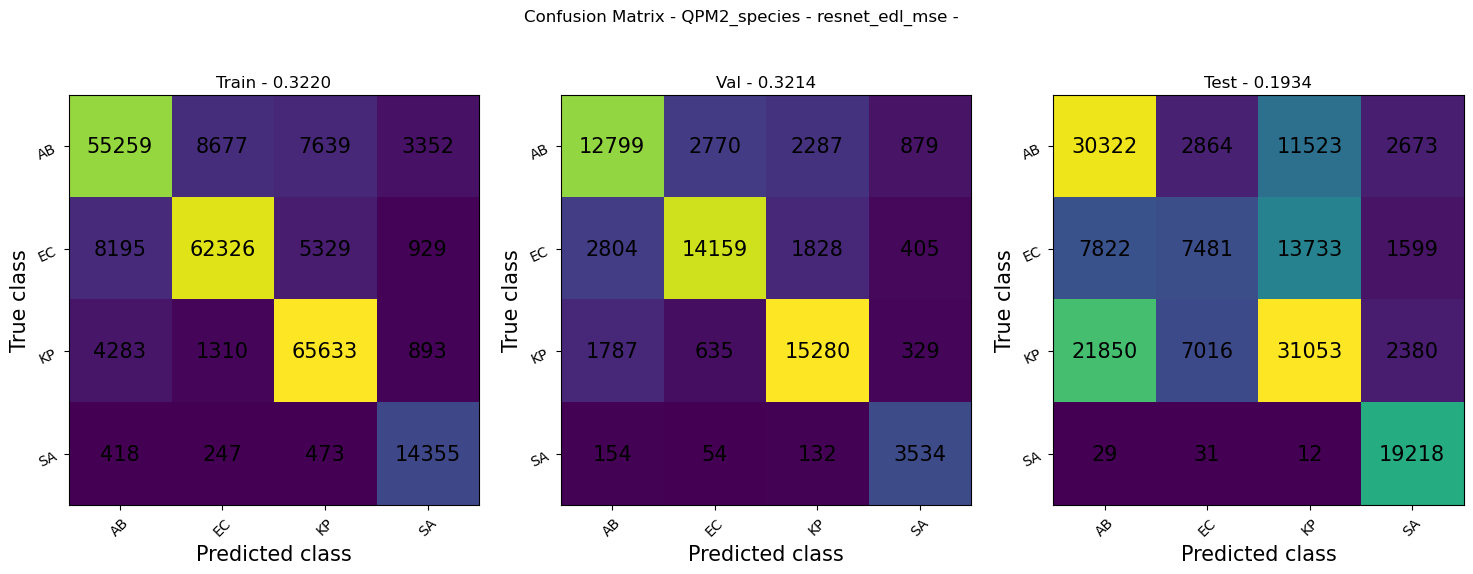

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(159606, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(159606, 2) (0, 2)


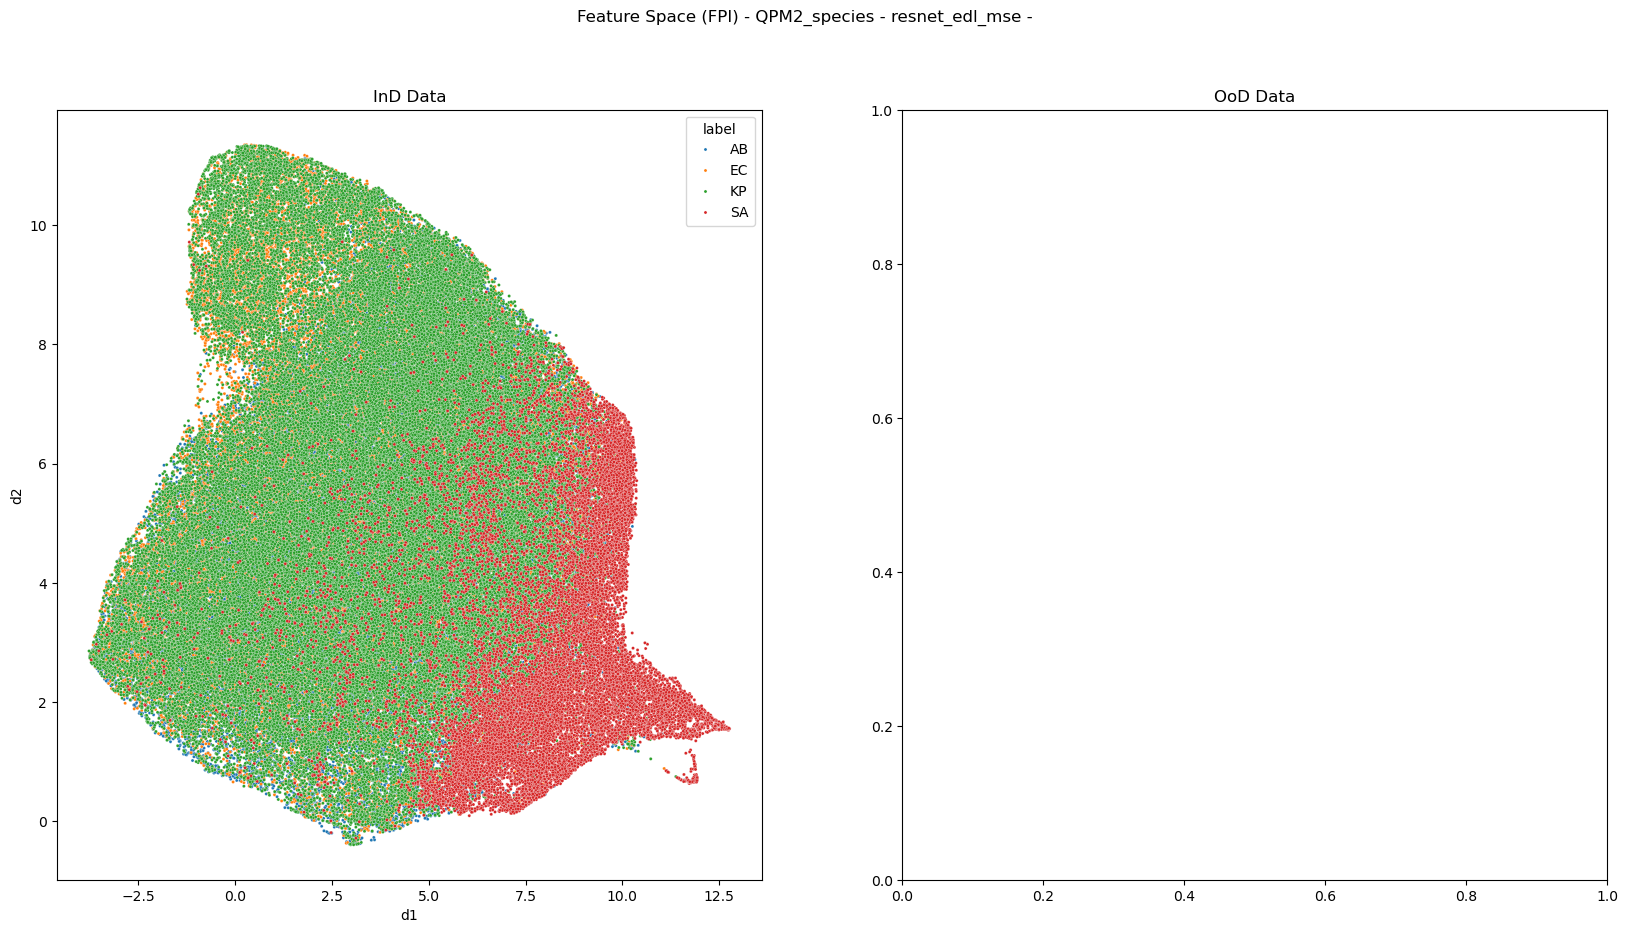

In [13]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

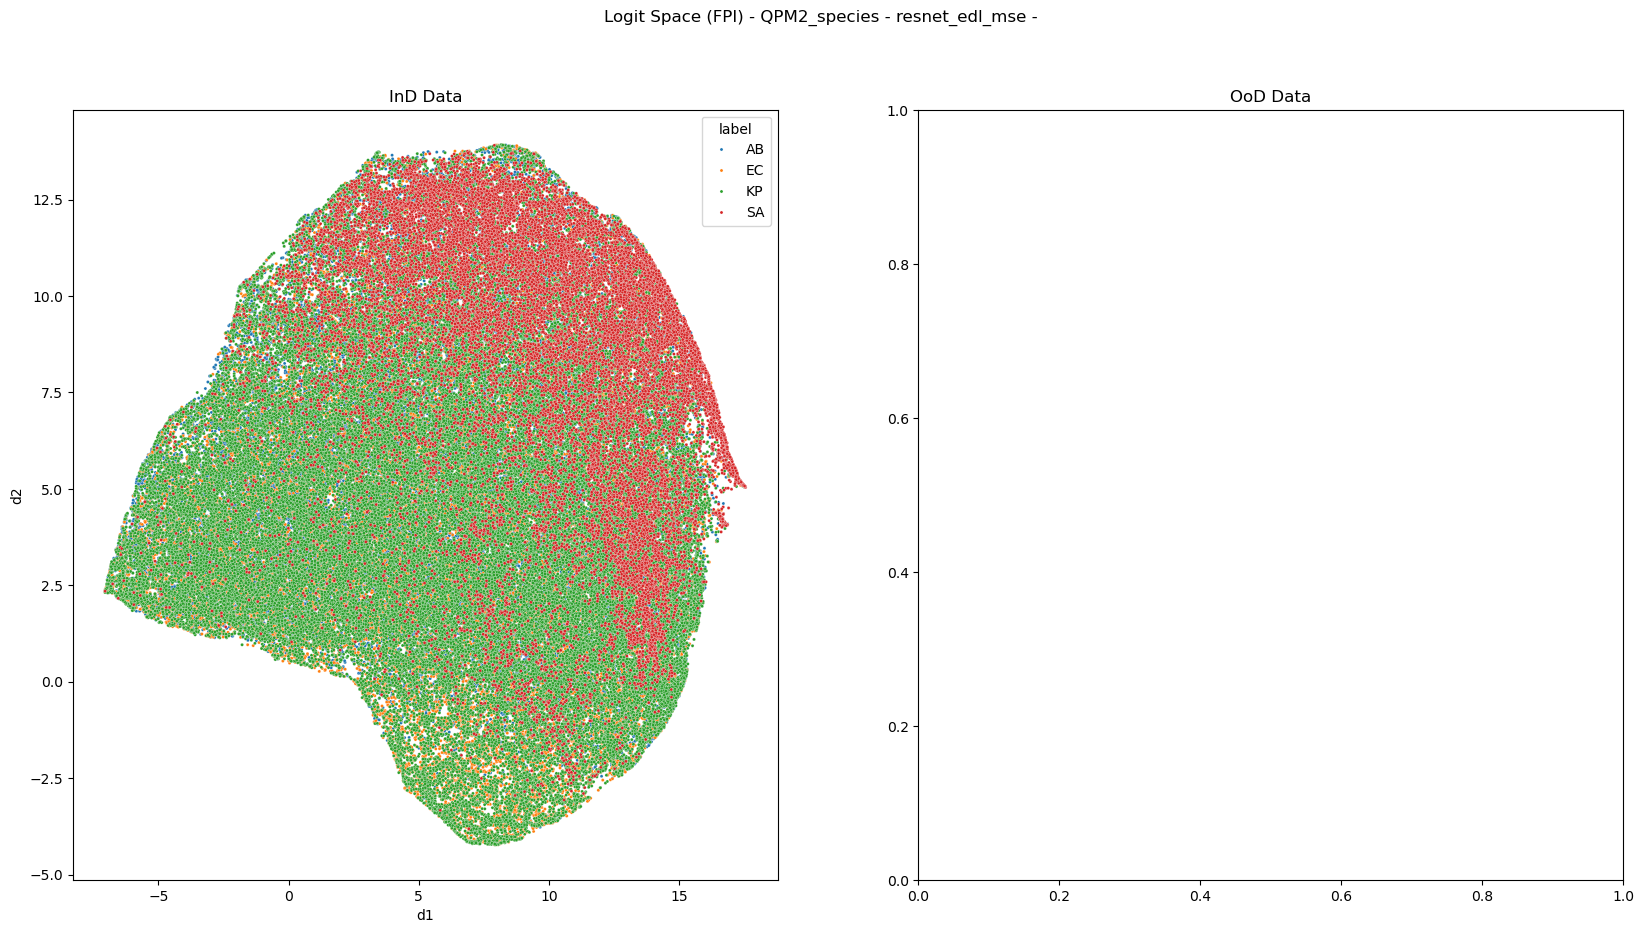

In [14]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

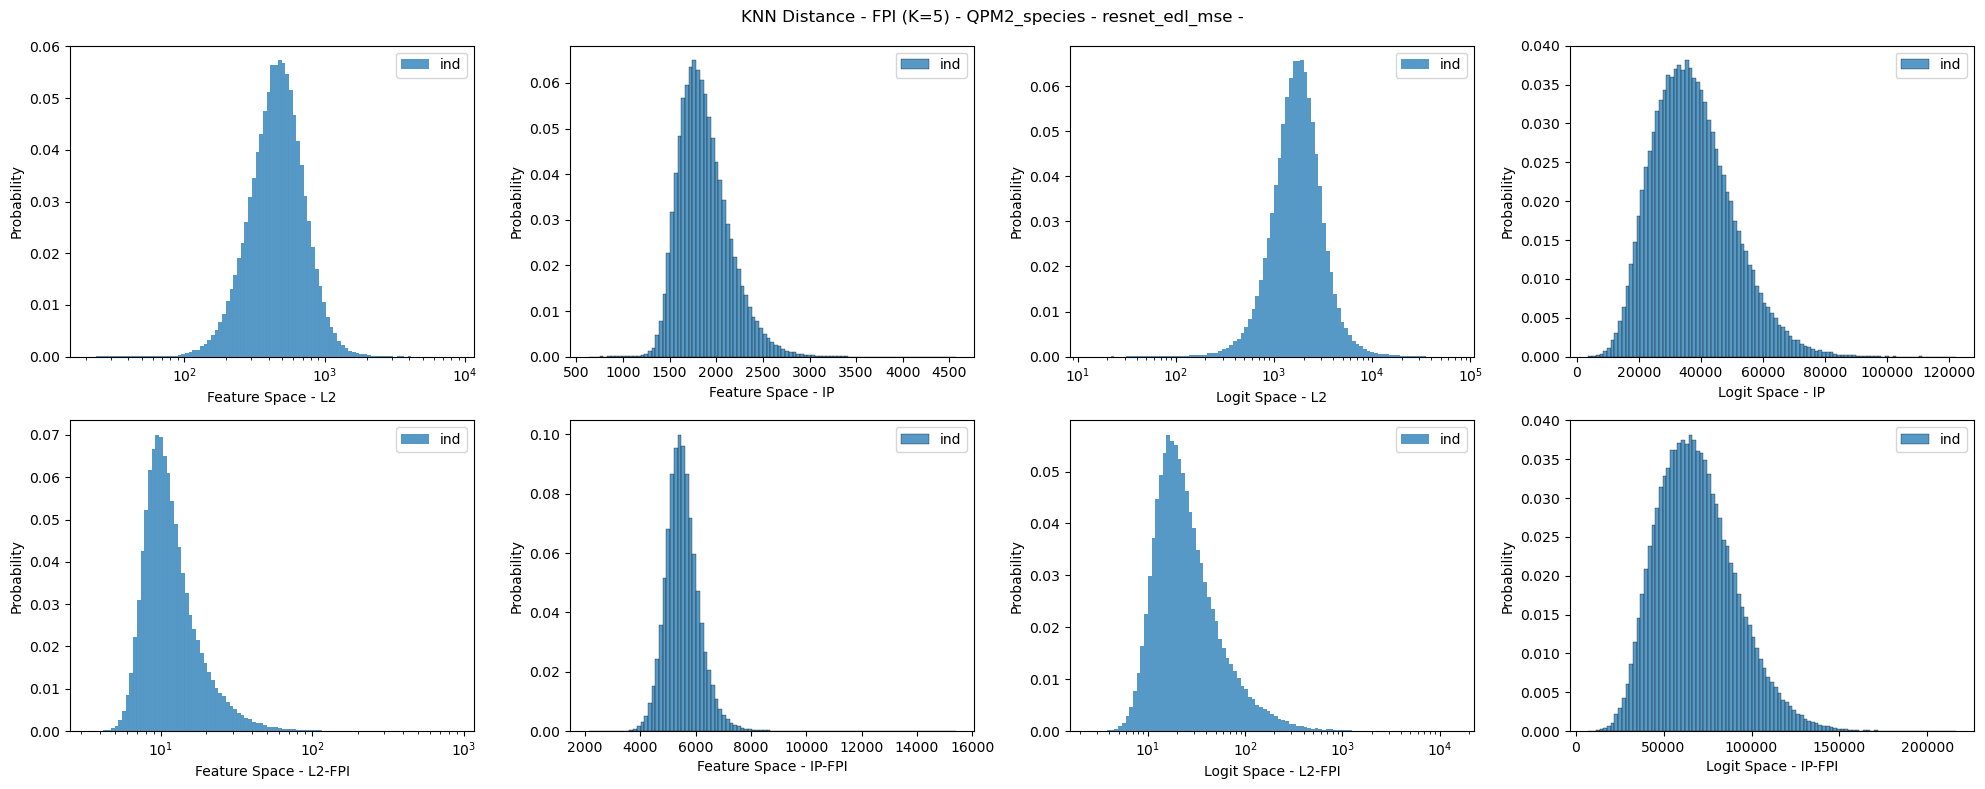

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig.suptitle(f"KNN Distance - FPI (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0][0], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[0][0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][1], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[0][1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[0][2], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[0][2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][3], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[0][3].set_xlabel("Logit Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[1][0], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[1][0].set_xlabel("Feature Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][1], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[1][1].set_xlabel("Feature Space - IP-FPI")
plot_knn_dists(faiss.IndexFlatL2, axs[1][2], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[1][2].set_xlabel("Logit Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][3], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[1][3].set_xlabel("Logit Space - IP-FPI")
plt.tight_layout()
plt.show()

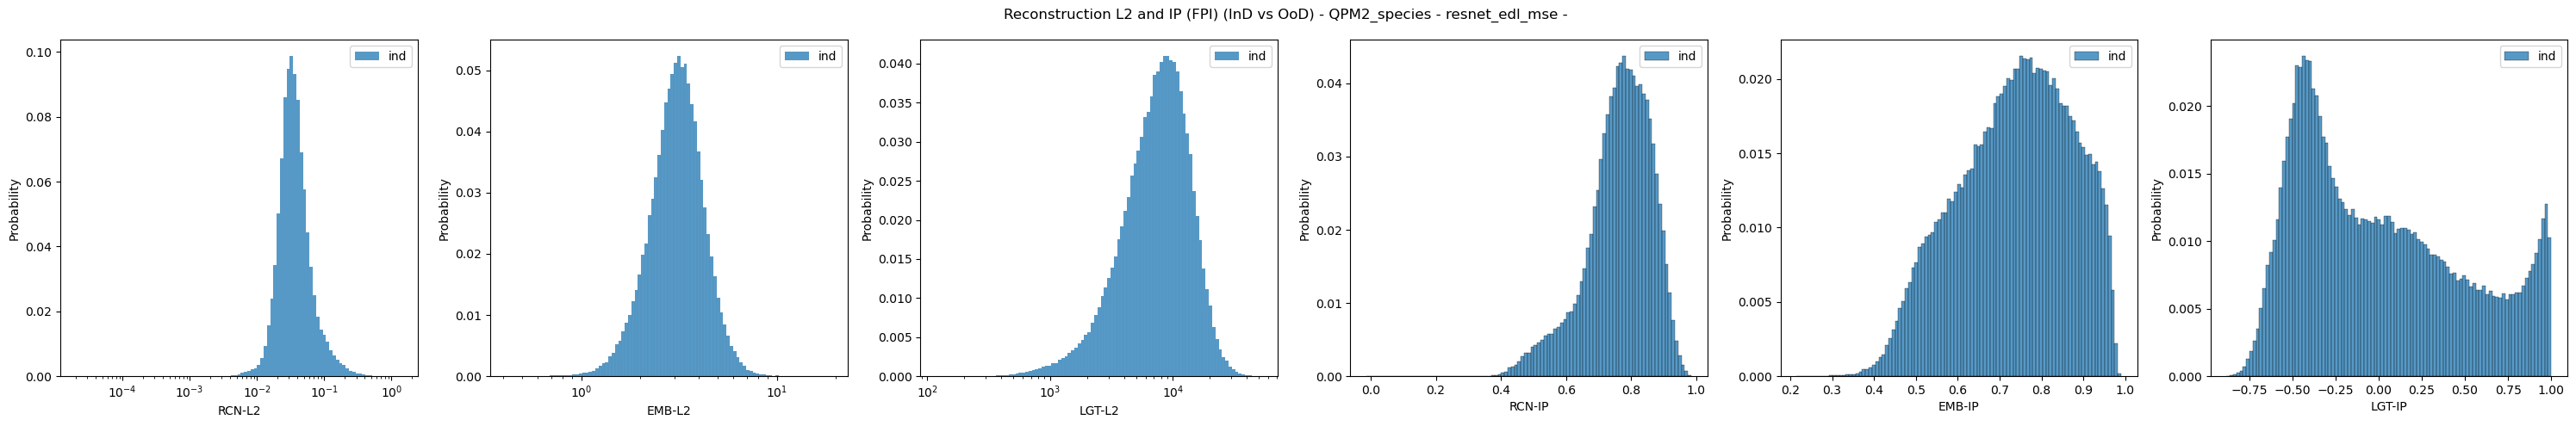

In [16]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
# unit vectors
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    # unit vectors
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
plot_rcn(ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
plot_rcn(ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
plot_rcn(ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
plot_rcn(ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
plot_rcn(ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

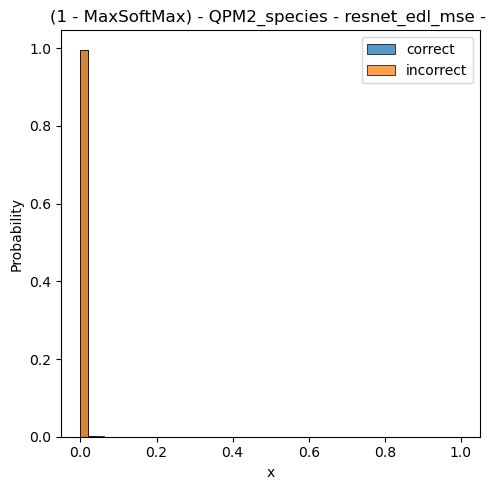

In [17]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

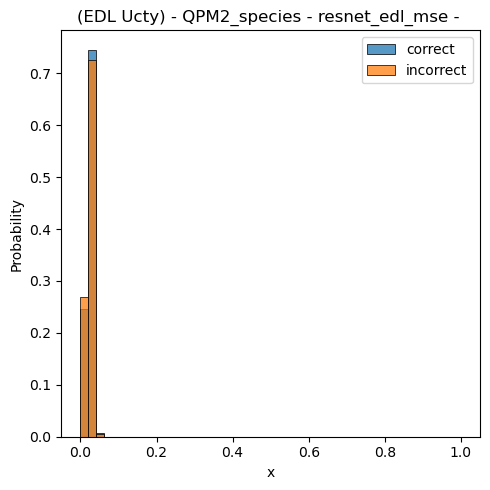

In [18]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data
K = ind_lgt_fpi.shape[-1]
ind_belief_fpi = np.clip(ind_lgt_fpi, 0, None)
ind_pred_fpi = ind_lgt_fpi.argmax(-1)
ind_prob_fpi = ind_belief_fpi / (ind_belief_fpi.sum(-1, keepdims=True) + K)
ind_ucty_fpi = K / (ind_belief_fpi.sum(-1) + K)

if ood_str:
    ood_belief_fpi = np.clip(ood_lgt_fpi, 0, None)
    ood_pred_fpi = ood_lgt_fpi.argmax(-1)
    ood_prob_fpi = ood_belief_fpi / (ood_belief_fpi.sum(-1, keepdims=True) + K)
    ood_ucty_fpi = K / (ood_belief_fpi.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()